Name: Subrat Kishore Dutta  
Matrikelnummer:  7028082
Email:   subratkishoredutta1234@gmail.com,sudu00001@stud.uni-saarland.de
   
Name:   Prathvish Mithare
Matrikelnummer:   7028692
Email: prmi00001@stud.uni-saarland.de

#### Preamble

In [26]:
# TODO: Import necessary libraries
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics import F1Score
import matplotlib.pyplot as plt

In [27]:
torch.cuda.is_available()
device = torch.device("cpu")

# 7.5 Build your own regularized NN

In this exercise you get to use your previously built networks, but this time you need to add regularization in the form of dropout and $L_2$-regularization.

Each layer has the option of using dropout. Your code needs to allow for this flexibility.

Additionally, adding $L_2$-regularization should also be optional upon creation.

**NOTE**: You are allowed to use built-in functions from pytorch to incorporate this functionality.

### 7.5.1 Implement a regularized model (1 point)

Implement your own model (using `torch`) using the skeleton code provided.

In [28]:
class Model(nn.Module):
    """
    Implement a model that incorporates dropout and L2 regularization
    depending on arguments passed.
    
    Args:
    input_dim: dimensionality of the inputs
    hidden_dim: how many units each hidden layer will have
    out_dim: how many output units
    num_layers: how many hidden layers to create/use
    dropout: a list of booleans specifying which hidden layers will have dropout
    dropout_p: the probability used for the `Dropout` layers
    l2_reg: a boolean value that indicates whether L2 regularization should be used
    """
    # TODO: Implement
    def __init__(self, input_dim: int, hidden_dim: int, out_dim: int, num_layers: int, dropout: list, dropout_p: float,
                 l2_reg: bool):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.dropout_p = dropout_p
        self.l2_reg = l2_reg
        self.fci = nn.Linear(self.input_dim, self.hidden_dim)
        self.fch = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.fco = nn.Linear(self.hidden_dim,self.out_dim)
        self.softmax = nn.Softmax()
        self.m = nn.Dropout(p=self.dropout_p)
        
        
    def __call__(self,x):
        out = self.fci(x)
        out = F.relu(out)
        #print(self.out)
        for num in range(self.num_layers):
            out = self.fch(out)
            out = F.relu(out)
            if self.dropout[num]:
                out = self.m(out)
        out = self.fco(out)
        #out = self.softmax(out)
        return out
    
    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=learning_rate)
        ep=[]
        lossrec=[]
        for epoch in range(epochs):
            tloss=0
            ep.append(epoch)
            for i,(xs,ys) in enumerate(train_loader):
                xs=xs.to(device)
                ys=ys.to(device)
                pred = model(xs.view(-1,28*28))
                if self.l2_reg:
                    a=torch.tensor(0.).to(device)
                    for p in model.parameters():
                        a+=torch.norm(p)
                    loss = loss_fn(pred,ys)+lam*a
                else:
                    loss = loss_fn(pred,ys)
                    
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                tloss+=loss
            lossrec.append((tloss/len(train_loader)).log().item())
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item())
        
        plt.figure(figsize=(10,10))
        plt.plot(ep,lossrec,color='orange')
        plt.xlabel('epochs')
        plt.ylabel('log loss')
        return lossrec
            
    def test(self,test_loader):
        loss_fn = nn.CrossEntropyLoss()
        loss=0
        for i,(xs,ys) in enumerate(test_loader):
            xs=xs.to(device)
            ys=ys.to(device)
            pred = model(xs.view(-1,28*28))
            loss+= loss_fn(pred,ys).item()
        print(loss/len(test_loader))
        return loss/len(test_loader)
            
    

In [ ]:
##function to get accuracy:
def get_accuracy(data,model):
    accdata=torch.utils.data.DataLoader(data,batch_size=len(data))
    for X,Y in accdata:
        X=X.to(device)
        Y=Y.to(device)
        ypred=model(X.view(-1,28*28))
        train_acc = torch.sum(ypred.argmax(1) == Y)
        accuracy = train_acc/len(data)
    print(accuracy.item()*100,"%")

In [ ]:
def get_f1(data,model):
    accdata=torch.utils.data.DataLoader(data,batch_size=len(data))
    for X,Y in accdata:
        X=X.to(device)
        Y=Y.to(device)
        f1= F1Score(task="multiclass", num_classes=10)
        ypred=model(X.view(-1,28*28))
        f1 = f1(ypred.argmax(1),Y)
    print("F1 score:",f1.item())

### 7.5.2 Experiment with your model (1 point)

Use the MNIST dataset and evaluation code from the previous assignment to run some experiments. Run the following experiments:

1. Shallow network (not more than 1 hidden layer)
1. Shallow regularized network
1. Deep network (at least 3 hidden layers)
1. Deep regularized network

Report Accuracy and $F_1$ metrics for your experiments and discuss your results. What did you expect to see and what did you end up seeing.

**NOTE**: You can choose how you use regularization. Ideally you would experiment with various parameters for this regularization, the 4 listed variants are merely what you must cover as a minimum. Report results for all your experiments concisely in a table.

**NOTE 2**: Make sure to report your metrics on the training and evaluation/heldout sets.

In [31]:
# Load the data
# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT FOR THE BATCH SIZE IF NECESSARY
transform_fn = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_fn)
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_fn)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=128, shuffle=False)

# Use the above data for your experiments

### Experiments:

#### 1.Choosing the correct learning rate

We took a shallow model to test a range of learning rates within a range and choose the best performing one going ahead to train our models.

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

lr= tensor(1.0000e-05)
epoch: 0 loss: 1.892500877380371
epoch: 1 loss: 1.0335348844528198
epoch: 2 loss: 0.6686577200889587
epoch: 3 loss: 0.5257071256637573
epoch: 4 loss: 0.45419377088546753
epoch: 5 loss: 0.41215193271636963
epoch: 6 loss: 0.3844107687473297
epoch: 7 loss: 0.36399194598197937
epoch: 8 loss: 0.34814777970314026
epoch: 9 loss: 0.3354855477809906


  0%|▍                                                                              | 1/200 [02:12<7:18:23, 132.18s/it]

lr= tensor(1.0353e-05)
epoch: 0 loss: 1.89199697971344
epoch: 1 loss: 1.0307365655899048
epoch: 2 loss: 0.6637700796127319
epoch: 3 loss: 0.520732581615448
epoch: 4 loss: 0.45013925433158875
epoch: 5 loss: 0.4095119833946228
epoch: 6 loss: 0.38265860080718994
epoch: 7 loss: 0.363679438829422
epoch: 8 loss: 0.34881791472435
epoch: 9 loss: 0.3366168141365051


  1%|▊                                                                              | 2/200 [04:29<7:20:50, 133.59s/it]

lr= tensor(1.0719e-05)
epoch: 0 loss: 1.85219144821167
epoch: 1 loss: 0.9750973582267761
epoch: 2 loss: 0.636581301689148
epoch: 3 loss: 0.5067289471626282
epoch: 4 loss: 0.4420516788959503
epoch: 5 loss: 0.4045882523059845
epoch: 6 loss: 0.37923523783683777
epoch: 7 loss: 0.3604154884815216
epoch: 8 loss: 0.34629693627357483
epoch: 9 loss: 0.3347543478012085


  2%|█▏                                                                             | 3/200 [06:45<7:21:35, 134.49s/it]

lr= tensor(1.1098e-05)
epoch: 0 loss: 1.8361923694610596
epoch: 1 loss: 0.9359126091003418
epoch: 2 loss: 0.6117396950721741
epoch: 3 loss: 0.4909825623035431
epoch: 4 loss: 0.43170052766799927
epoch: 5 loss: 0.3964470624923706
epoch: 6 loss: 0.3732058107852936
epoch: 7 loss: 0.3561432659626007
epoch: 8 loss: 0.3432956337928772
epoch: 9 loss: 0.33235856890678406


  2%|█▌                                                                             | 4/200 [09:02<7:21:22, 135.11s/it]

lr= tensor(1.1490e-05)
epoch: 0 loss: 1.8367465734481812
epoch: 1 loss: 0.9490591287612915
epoch: 2 loss: 0.6145464777946472
epoch: 3 loss: 0.49035361409187317
epoch: 4 loss: 0.42977333068847656
epoch: 5 loss: 0.3939368724822998
epoch: 6 loss: 0.37032562494277954
epoch: 7 loss: 0.352522611618042
epoch: 8 loss: 0.3381843864917755
epoch: 9 loss: 0.3271409869194031


  2%|█▉                                                                             | 5/200 [11:19<7:21:41, 135.91s/it]

lr= tensor(1.1895e-05)
epoch: 0 loss: 1.8179616928100586
epoch: 1 loss: 0.9040355682373047
epoch: 2 loss: 0.5916582345962524
epoch: 3 loss: 0.4769085645675659
epoch: 4 loss: 0.41965407133102417
epoch: 5 loss: 0.3862212300300598
epoch: 6 loss: 0.36281466484069824
epoch: 7 loss: 0.34627607464790344
epoch: 8 loss: 0.3328576982021332
epoch: 9 loss: 0.3222067058086395


  3%|██▎                                                                            | 6/200 [13:37<7:21:13, 136.46s/it]

lr= tensor(1.2316e-05)
epoch: 0 loss: 1.769991159439087
epoch: 1 loss: 0.8653280735015869
epoch: 2 loss: 0.5718198418617249
epoch: 3 loss: 0.4643977880477905
epoch: 4 loss: 0.4109906256198883
epoch: 5 loss: 0.37861618399620056
epoch: 6 loss: 0.35679489374160767
epoch: 7 loss: 0.34007418155670166
epoch: 8 loss: 0.32677528262138367
epoch: 9 loss: 0.31532716751098633


  4%|██▊                                                                            | 7/200 [15:54<7:19:42, 136.70s/it]

lr= tensor(1.2751e-05)
epoch: 0 loss: 1.7727138996124268
epoch: 1 loss: 0.8528897762298584
epoch: 2 loss: 0.5620903372764587
epoch: 3 loss: 0.45865416526794434
epoch: 4 loss: 0.4074796438217163
epoch: 5 loss: 0.3774702548980713
epoch: 6 loss: 0.35684338212013245
epoch: 7 loss: 0.34095314145088196
epoch: 8 loss: 0.32806074619293213
epoch: 9 loss: 0.3179311156272888


  4%|███▏                                                                           | 8/200 [18:11<7:17:35, 136.75s/it]

lr= tensor(1.3201e-05)
epoch: 0 loss: 1.7521473169326782
epoch: 1 loss: 0.8312126994132996
epoch: 2 loss: 0.5524774789810181
epoch: 3 loss: 0.4542533755302429
epoch: 4 loss: 0.4049520790576935
epoch: 5 loss: 0.3755675256252289
epoch: 6 loss: 0.35504087805747986
epoch: 7 loss: 0.33955445885658264
epoch: 8 loss: 0.3275136947631836
epoch: 9 loss: 0.31715965270996094


  4%|███▌                                                                           | 9/200 [20:29<7:16:39, 137.17s/it]

lr= tensor(1.3667e-05)
epoch: 0 loss: 1.725970983505249
epoch: 1 loss: 0.800441563129425
epoch: 2 loss: 0.5344855189323425
epoch: 3 loss: 0.441520631313324
epoch: 4 loss: 0.39503368735313416
epoch: 5 loss: 0.3668854534626007
epoch: 6 loss: 0.3467002511024475
epoch: 7 loss: 0.3314056992530823
epoch: 8 loss: 0.31859368085861206
epoch: 9 loss: 0.3078877031803131


  5%|███▉                                                                          | 10/200 [22:47<7:14:48, 137.31s/it]

lr= tensor(1.4150e-05)
epoch: 0 loss: 1.707678198814392
epoch: 1 loss: 0.7888227701187134
epoch: 2 loss: 0.5372301936149597
epoch: 3 loss: 0.44373056292533875
epoch: 4 loss: 0.39554187655448914
epoch: 5 loss: 0.3659362494945526
epoch: 6 loss: 0.3451329171657562
epoch: 7 loss: 0.3295435607433319
epoch: 8 loss: 0.31627389788627625
epoch: 9 loss: 0.3054106831550598


  6%|████▎                                                                         | 11/200 [25:04<7:12:31, 137.31s/it]

lr= tensor(1.4650e-05)
epoch: 0 loss: 1.6924294233322144
epoch: 1 loss: 0.7561503648757935
epoch: 2 loss: 0.510901927947998
epoch: 3 loss: 0.4259834289550781
epoch: 4 loss: 0.384103000164032
epoch: 5 loss: 0.3580992817878723
epoch: 6 loss: 0.3391294479370117
epoch: 7 loss: 0.3246397078037262
epoch: 8 loss: 0.3118414580821991
epoch: 9 loss: 0.30083197355270386


  6%|████▋                                                                         | 12/200 [27:22<7:10:14, 137.31s/it]

lr= tensor(1.5167e-05)
epoch: 0 loss: 1.6601712703704834
epoch: 1 loss: 0.7489654421806335
epoch: 2 loss: 0.5121007561683655
epoch: 3 loss: 0.4259305000305176
epoch: 4 loss: 0.38239189982414246
epoch: 5 loss: 0.35529571771621704
epoch: 6 loss: 0.33652588725090027
epoch: 7 loss: 0.3216092884540558
epoch: 8 loss: 0.3095387816429138
epoch: 9 loss: 0.2985056936740875


  6%|█████                                                                         | 13/200 [29:40<7:08:36, 137.52s/it]

lr= tensor(1.5703e-05)
epoch: 0 loss: 1.6385823488235474
epoch: 1 loss: 0.7151654362678528
epoch: 2 loss: 0.4923218786716461
epoch: 3 loss: 0.4153192639350891
epoch: 4 loss: 0.3757559359073639
epoch: 5 loss: 0.3510565161705017
epoch: 6 loss: 0.33308786153793335
epoch: 7 loss: 0.31859999895095825
epoch: 8 loss: 0.30679866671562195
epoch: 9 loss: 0.29560428857803345


  7%|█████▍                                                                        | 14/200 [31:57<7:06:21, 137.53s/it]

lr= tensor(1.6258e-05)
epoch: 0 loss: 1.6206320524215698
epoch: 1 loss: 0.6974009871482849
epoch: 2 loss: 0.4838207960128784
epoch: 3 loss: 0.4084223210811615
epoch: 4 loss: 0.37073591351509094
epoch: 5 loss: 0.3464881181716919
epoch: 6 loss: 0.32912078499794006
epoch: 7 loss: 0.3152731657028198
epoch: 8 loss: 0.30336111783981323
epoch: 9 loss: 0.29275110363960266


  8%|█████▊                                                                        | 15/200 [34:14<7:03:28, 137.34s/it]

lr= tensor(1.6832e-05)
epoch: 0 loss: 1.6074684858322144
epoch: 1 loss: 0.6824175715446472
epoch: 2 loss: 0.47568997740745544
epoch: 3 loss: 0.404369056224823
epoch: 4 loss: 0.3686349391937256
epoch: 5 loss: 0.34554022550582886
epoch: 6 loss: 0.32835978269577026
epoch: 7 loss: 0.31429198384284973
epoch: 8 loss: 0.3030242323875427
epoch: 9 loss: 0.29210004210472107


  8%|██████▏                                                                       | 16/200 [36:31<7:01:03, 137.30s/it]

lr= tensor(1.7426e-05)
epoch: 0 loss: 1.5802209377288818
epoch: 1 loss: 0.6628199219703674
epoch: 2 loss: 0.4684096574783325
epoch: 3 loss: 0.39987993240356445
epoch: 4 loss: 0.3640998601913452
epoch: 5 loss: 0.34076717495918274
epoch: 6 loss: 0.32324835658073425
epoch: 7 loss: 0.3095664978027344
epoch: 8 loss: 0.29737982153892517
epoch: 9 loss: 0.2862684428691864


  8%|██████▋                                                                       | 17/200 [38:49<6:59:00, 137.38s/it]

lr= tensor(1.8042e-05)
epoch: 0 loss: 1.5330333709716797
epoch: 1 loss: 0.6397529244422913
epoch: 2 loss: 0.459147572517395
epoch: 3 loss: 0.39544275403022766
epoch: 4 loss: 0.36240267753601074
epoch: 5 loss: 0.3400212228298187
epoch: 6 loss: 0.32425984740257263
epoch: 7 loss: 0.31078922748565674
epoch: 8 loss: 0.2996350824832916
epoch: 9 loss: 0.2892053723335266


  9%|███████                                                                       | 18/200 [41:07<6:56:51, 137.42s/it]

lr= tensor(1.8679e-05)
epoch: 0 loss: 1.5096848011016846
epoch: 1 loss: 0.6213876605033875
epoch: 2 loss: 0.44915449619293213
epoch: 3 loss: 0.38658636808395386
epoch: 4 loss: 0.3531477749347687
epoch: 5 loss: 0.3297499418258667
epoch: 6 loss: 0.31291908025741577
epoch: 7 loss: 0.2979294955730438
epoch: 8 loss: 0.28548920154571533
epoch: 9 loss: 0.273432195186615


 10%|███████▍                                                                      | 19/200 [43:25<6:55:27, 137.72s/it]

lr= tensor(1.9339e-05)
epoch: 0 loss: 1.5155645608901978
epoch: 1 loss: 0.6190043091773987
epoch: 2 loss: 0.44628843665122986
epoch: 3 loss: 0.3851749897003174
epoch: 4 loss: 0.3525024354457855
epoch: 5 loss: 0.33061596751213074
epoch: 6 loss: 0.31311115622520447
epoch: 7 loss: 0.29850488901138306
epoch: 8 loss: 0.285453736782074
epoch: 9 loss: 0.27416175603866577


 10%|███████▊                                                                      | 20/200 [45:44<6:54:29, 138.17s/it]

lr= tensor(2.0022e-05)
epoch: 0 loss: 1.512101411819458
epoch: 1 loss: 0.610654354095459
epoch: 2 loss: 0.44256946444511414
epoch: 3 loss: 0.38184866309165955
epoch: 4 loss: 0.3492002487182617
epoch: 5 loss: 0.3277561664581299
epoch: 6 loss: 0.311311811208725
epoch: 7 loss: 0.29713526368141174
epoch: 8 loss: 0.28587278723716736
epoch: 9 loss: 0.27463552355766296


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 10%|████████▏                                                                     | 21/200 [48:04<6:53:22, 138.56s/it]

lr= tensor(2.0729e-05)
epoch: 0 loss: 1.473971962928772
epoch: 1 loss: 0.5873715877532959
epoch: 2 loss: 0.4304628372192383
epoch: 3 loss: 0.37607541680336
epoch: 4 loss: 0.34627407789230347
epoch: 5 loss: 0.32567688822746277
epoch: 6 loss: 0.3094576299190521
epoch: 7 loss: 0.29458311200141907
epoch: 8 loss: 0.28199368715286255
epoch: 9 loss: 0.2695061266422272


 11%|████████▌                                                                     | 22/200 [50:22<6:50:52, 138.50s/it]

lr= tensor(2.1461e-05)
epoch: 0 loss: 1.429487943649292
epoch: 1 loss: 0.5688173770904541
epoch: 2 loss: 0.42125871777534485
epoch: 3 loss: 0.36852142214775085
epoch: 4 loss: 0.33981186151504517
epoch: 5 loss: 0.31981319189071655
epoch: 6 loss: 0.3048916459083557
epoch: 7 loss: 0.29104071855545044
epoch: 8 loss: 0.27919524908065796
epoch: 9 loss: 0.26791349053382874


 12%|████████▉                                                                     | 23/200 [52:41<6:48:43, 138.55s/it]

lr= tensor(2.2219e-05)
epoch: 0 loss: 1.4461358785629272
epoch: 1 loss: 0.5650571584701538
epoch: 2 loss: 0.41820764541625977
epoch: 3 loss: 0.36502552032470703
epoch: 4 loss: 0.3346283733844757
epoch: 5 loss: 0.3132651150226593
epoch: 6 loss: 0.2946965992450714
epoch: 7 loss: 0.27937379479408264
epoch: 8 loss: 0.26616090536117554
epoch: 9 loss: 0.2542261481285095


 12%|█████████▎                                                                    | 24/200 [54:59<6:46:34, 138.61s/it]

lr= tensor(2.3004e-05)
epoch: 0 loss: 1.4048707485198975
epoch: 1 loss: 0.5545513033866882
epoch: 2 loss: 0.41623470187187195
epoch: 3 loss: 0.36503684520721436
epoch: 4 loss: 0.3378226161003113
epoch: 5 loss: 0.31729212403297424
epoch: 6 loss: 0.2999587655067444
epoch: 7 loss: 0.2857626676559448
epoch: 8 loss: 0.27311697602272034
epoch: 9 loss: 0.2607322633266449


 12%|█████████▊                                                                    | 25/200 [57:18<6:44:26, 138.66s/it]

lr= tensor(2.3817e-05)
epoch: 0 loss: 1.3819166421890259
epoch: 1 loss: 0.5452782511711121
epoch: 2 loss: 0.4113885462284088
epoch: 3 loss: 0.3627873659133911
epoch: 4 loss: 0.33605140447616577
epoch: 5 loss: 0.3165085017681122
epoch: 6 loss: 0.3005446195602417
epoch: 7 loss: 0.28657200932502747
epoch: 8 loss: 0.27373167872428894
epoch: 9 loss: 0.26198047399520874


 13%|██████████▏                                                                   | 26/200 [59:37<6:42:11, 138.69s/it]

lr= tensor(2.4658e-05)
epoch: 0 loss: 1.3363755941390991
epoch: 1 loss: 0.523393988609314
epoch: 2 loss: 0.4021032750606537
epoch: 3 loss: 0.35617271065711975
epoch: 4 loss: 0.3287501037120819
epoch: 5 loss: 0.3083990216255188
epoch: 6 loss: 0.29181545972824097
epoch: 7 loss: 0.2770443856716156
epoch: 8 loss: 0.2632090747356415
epoch: 9 loss: 0.2502918243408203


 14%|██████████▎                                                                 | 27/200 [1:01:57<6:41:16, 139.17s/it]

lr= tensor(2.5529e-05)
epoch: 0 loss: 1.3404812812805176
epoch: 1 loss: 0.5176117420196533
epoch: 2 loss: 0.39756253361701965
epoch: 3 loss: 0.35145068168640137
epoch: 4 loss: 0.323060005903244
epoch: 5 loss: 0.3020924925804138
epoch: 6 loss: 0.2850359380245209
epoch: 7 loss: 0.27003180980682373
epoch: 8 loss: 0.25619634985923767
epoch: 9 loss: 0.24307477474212646


 14%|██████████▋                                                                 | 28/200 [1:04:15<6:37:28, 138.65s/it]

lr= tensor(2.6431e-05)
epoch: 0 loss: 1.3131910562515259
epoch: 1 loss: 0.508229672908783
epoch: 2 loss: 0.393312007188797
epoch: 3 loss: 0.34839606285095215
epoch: 4 loss: 0.3210887908935547
epoch: 5 loss: 0.301533967256546
epoch: 6 loss: 0.2846059501171112
epoch: 7 loss: 0.2693376839160919
epoch: 8 loss: 0.25641340017318726
epoch: 9 loss: 0.24425120651721954


 14%|███████████                                                                 | 29/200 [1:06:29<6:31:40, 137.43s/it]

lr= tensor(2.7364e-05)
epoch: 0 loss: 1.3311623334884644
epoch: 1 loss: 0.5150906443595886
epoch: 2 loss: 0.39465805888175964
epoch: 3 loss: 0.35077011585235596
epoch: 4 loss: 0.32303711771965027
epoch: 5 loss: 0.3035575747489929
epoch: 6 loss: 0.28743234276771545
epoch: 7 loss: 0.27258607745170593
epoch: 8 loss: 0.2595768868923187
epoch: 9 loss: 0.24662920832633972


 15%|███████████▍                                                                | 30/200 [1:08:44<6:27:31, 136.77s/it]

lr= tensor(2.8331e-05)
epoch: 0 loss: 1.2708452939987183
epoch: 1 loss: 0.4871448576450348
epoch: 2 loss: 0.38125723600387573
epoch: 3 loss: 0.34009188413619995
epoch: 4 loss: 0.31382930278778076
epoch: 5 loss: 0.29336392879486084
epoch: 6 loss: 0.2761267423629761
epoch: 7 loss: 0.2598452568054199
epoch: 8 loss: 0.24508865177631378
epoch: 9 loss: 0.2317085713148117


 16%|███████████▊                                                                | 31/200 [1:10:59<6:23:14, 136.06s/it]

lr= tensor(2.9332e-05)
epoch: 0 loss: 1.2720123529434204
epoch: 1 loss: 0.4871251583099365
epoch: 2 loss: 0.38104134798049927
epoch: 3 loss: 0.33953845500946045
epoch: 4 loss: 0.31456831097602844
epoch: 5 loss: 0.2944503426551819
epoch: 6 loss: 0.27701520919799805
epoch: 7 loss: 0.2620859146118164
epoch: 8 loss: 0.24729035794734955
epoch: 9 loss: 0.2342129647731781


 16%|████████████▏                                                               | 32/200 [1:13:13<6:19:40, 135.60s/it]

lr= tensor(3.0368e-05)
epoch: 0 loss: 1.2352073192596436
epoch: 1 loss: 0.47451069951057434
epoch: 2 loss: 0.3743005394935608
epoch: 3 loss: 0.33369091153144836
epoch: 4 loss: 0.3066258430480957
epoch: 5 loss: 0.2864586114883423
epoch: 6 loss: 0.26790276169776917
epoch: 7 loss: 0.2527388036251068
epoch: 8 loss: 0.23780205845832825
epoch: 9 loss: 0.2240171879529953


 16%|████████████▌                                                               | 33/200 [1:15:28<6:16:55, 135.42s/it]

lr= tensor(3.1440e-05)
epoch: 0 loss: 1.2046016454696655
epoch: 1 loss: 0.46699798107147217
epoch: 2 loss: 0.37062934041023254
epoch: 3 loss: 0.33046218752861023
epoch: 4 loss: 0.30388495326042175
epoch: 5 loss: 0.28249093890190125
epoch: 6 loss: 0.26538828015327454
epoch: 7 loss: 0.2504069209098816
epoch: 8 loss: 0.23617127537727356
epoch: 9 loss: 0.22268442809581757


 17%|████████████▉                                                               | 34/200 [1:17:43<6:14:05, 135.21s/it]

lr= tensor(3.2551e-05)
epoch: 0 loss: 1.1875258684158325
epoch: 1 loss: 0.45513808727264404
epoch: 2 loss: 0.36536410450935364
epoch: 3 loss: 0.327925443649292
epoch: 4 loss: 0.3036842942237854
epoch: 5 loss: 0.28454068303108215
epoch: 6 loss: 0.26762548089027405
epoch: 7 loss: 0.2530975639820099
epoch: 8 loss: 0.23897148668766022
epoch: 9 loss: 0.22611607611179352


 18%|█████████████▎                                                              | 35/200 [1:19:59<6:12:06, 135.31s/it]

lr= tensor(3.3701e-05)
epoch: 0 loss: 1.1756993532180786
epoch: 1 loss: 0.44664204120635986
epoch: 2 loss: 0.36095187067985535
epoch: 3 loss: 0.3246898949146271
epoch: 4 loss: 0.29991140961647034
epoch: 5 loss: 0.2799827456474304
epoch: 6 loss: 0.2616426944732666
epoch: 7 loss: 0.24591031670570374
epoch: 8 loss: 0.2312798947095871
epoch: 9 loss: 0.21689645946025848


 18%|█████████████▋                                                              | 36/200 [1:22:13<6:09:08, 135.05s/it]

lr= tensor(3.4891e-05)
epoch: 0 loss: 1.1477713584899902
epoch: 1 loss: 0.443742573261261
epoch: 2 loss: 0.358946830034256
epoch: 3 loss: 0.32208096981048584
epoch: 4 loss: 0.29826468229293823
epoch: 5 loss: 0.2770560085773468
epoch: 6 loss: 0.25930118560791016
epoch: 7 loss: 0.24297669529914856
epoch: 8 loss: 0.22864797711372375
epoch: 9 loss: 0.21515843272209167


 18%|██████████████                                                              | 37/200 [1:24:29<6:07:15, 135.19s/it]

lr= tensor(3.6123e-05)
epoch: 0 loss: 1.1484386920928955
epoch: 1 loss: 0.4407094120979309
epoch: 2 loss: 0.35763293504714966
epoch: 3 loss: 0.32227790355682373
epoch: 4 loss: 0.2966638207435608
epoch: 5 loss: 0.2747243046760559
epoch: 6 loss: 0.25573158264160156
epoch: 7 loss: 0.23941893875598907
epoch: 8 loss: 0.22270269691944122
epoch: 9 loss: 0.20943182706832886


 19%|██████████████▍                                                             | 38/200 [1:26:49<6:08:57, 136.65s/it]

lr= tensor(3.7399e-05)
epoch: 0 loss: 1.1179765462875366
epoch: 1 loss: 0.43194514513015747
epoch: 2 loss: 0.35483092069625854
epoch: 3 loss: 0.3198406398296356
epoch: 4 loss: 0.2931874096393585
epoch: 5 loss: 0.2716811001300812
epoch: 6 loss: 0.2517286539077759
epoch: 7 loss: 0.2334931343793869
epoch: 8 loss: 0.2180323600769043
epoch: 9 loss: 0.20397613942623138


 20%|██████████████▊                                                             | 39/200 [1:29:08<6:08:39, 137.39s/it]

lr= tensor(3.8720e-05)
epoch: 0 loss: 1.0934574604034424
epoch: 1 loss: 0.42220041155815125
epoch: 2 loss: 0.3477493226528168
epoch: 3 loss: 0.3123675286769867
epoch: 4 loss: 0.28560853004455566
epoch: 5 loss: 0.26497870683670044
epoch: 6 loss: 0.2448771595954895
epoch: 7 loss: 0.2273472100496292
epoch: 8 loss: 0.2114260196685791
epoch: 9 loss: 0.19790172576904297


 20%|███████████████▏                                                            | 40/200 [1:31:27<6:07:42, 137.89s/it]

lr= tensor(4.0088e-05)
epoch: 0 loss: 1.0749741792678833
epoch: 1 loss: 0.4190496504306793
epoch: 2 loss: 0.3473450839519501
epoch: 3 loss: 0.3139198422431946
epoch: 4 loss: 0.2896552085876465
epoch: 5 loss: 0.26969215273857117
epoch: 6 loss: 0.2506582736968994
epoch: 7 loss: 0.23460187017917633
epoch: 8 loss: 0.21875816583633423
epoch: 9 loss: 0.2049652487039566


 20%|███████████████▌                                                            | 41/200 [1:33:46<6:06:26, 138.28s/it]

lr= tensor(4.1504e-05)
epoch: 0 loss: 1.0733853578567505
epoch: 1 loss: 0.41663244366645813
epoch: 2 loss: 0.34324169158935547
epoch: 3 loss: 0.30663803219795227
epoch: 4 loss: 0.2810921370983124
epoch: 5 loss: 0.26056453585624695
epoch: 6 loss: 0.24177508056163788
epoch: 7 loss: 0.22572478652000427
epoch: 8 loss: 0.21048368513584137
epoch: 9 loss: 0.19623005390167236


 21%|███████████████▉                                                            | 42/200 [1:36:06<6:05:33, 138.82s/it]

lr= tensor(4.2970e-05)
epoch: 0 loss: 1.0532779693603516
epoch: 1 loss: 0.41097232699394226
epoch: 2 loss: 0.34204819798469543
epoch: 3 loss: 0.3107297420501709
epoch: 4 loss: 0.2858695387840271
epoch: 5 loss: 0.26493126153945923
epoch: 6 loss: 0.24593928456306458
epoch: 7 loss: 0.22850166261196136
epoch: 8 loss: 0.2116757184267044
epoch: 9 loss: 0.19558532536029816


 22%|████████████████▎                                                           | 43/200 [1:38:26<6:03:49, 139.04s/it]

lr= tensor(4.4488e-05)
epoch: 0 loss: 1.0231645107269287
epoch: 1 loss: 0.40461254119873047
epoch: 2 loss: 0.3364506661891937
epoch: 3 loss: 0.3016900420188904
epoch: 4 loss: 0.2753801941871643
epoch: 5 loss: 0.25351980328559875
epoch: 6 loss: 0.23477579653263092
epoch: 7 loss: 0.21591515839099884
epoch: 8 loss: 0.20073746144771576
epoch: 9 loss: 0.18661126494407654


 22%|████████████████▋                                                           | 44/200 [1:40:46<6:02:31, 139.43s/it]

lr= tensor(4.6059e-05)
epoch: 0 loss: 1.0264045000076294
epoch: 1 loss: 0.40049469470977783
epoch: 2 loss: 0.32991886138916016
epoch: 3 loss: 0.2945042550563812
epoch: 4 loss: 0.2668463885784149
epoch: 5 loss: 0.24469128251075745
epoch: 6 loss: 0.22629772126674652
epoch: 7 loss: 0.20861852169036865
epoch: 8 loss: 0.19292254745960236
epoch: 9 loss: 0.17957703769207


 22%|█████████████████                                                           | 45/200 [1:43:07<6:01:26, 139.91s/it]

lr= tensor(4.7686e-05)
epoch: 0 loss: 1.0138880014419556
epoch: 1 loss: 0.39721962809562683
epoch: 2 loss: 0.33121827244758606
epoch: 3 loss: 0.2982407212257385
epoch: 4 loss: 0.2721705138683319
epoch: 5 loss: 0.2485826015472412
epoch: 6 loss: 0.22723858058452606
epoch: 7 loss: 0.2091284841299057
epoch: 8 loss: 0.19355478882789612
epoch: 9 loss: 0.1777934730052948


 23%|█████████████████▍                                                          | 46/200 [1:45:28<5:59:45, 140.17s/it]

lr= tensor(4.9370e-05)
epoch: 0 loss: 0.979580819606781
epoch: 1 loss: 0.38861194252967834
epoch: 2 loss: 0.3248388171195984
epoch: 3 loss: 0.2899889349937439
epoch: 4 loss: 0.26175248622894287
epoch: 5 loss: 0.23920434713363647
epoch: 6 loss: 0.2183884233236313
epoch: 7 loss: 0.2012433111667633
epoch: 8 loss: 0.18474075198173523
epoch: 9 loss: 0.17248283326625824


 24%|█████████████████▊                                                          | 47/200 [1:47:51<5:59:55, 141.14s/it]

lr= tensor(5.1114e-05)
epoch: 0 loss: 0.9715874791145325
epoch: 1 loss: 0.38272374868392944
epoch: 2 loss: 0.3208937644958496
epoch: 3 loss: 0.2878727614879608
epoch: 4 loss: 0.25952571630477905
epoch: 5 loss: 0.238061785697937
epoch: 6 loss: 0.2156028002500534
epoch: 7 loss: 0.19847801327705383
epoch: 8 loss: 0.18227143585681915
epoch: 9 loss: 0.16816096007823944


 24%|██████████████████▏                                                         | 48/200 [1:50:18<6:01:41, 142.77s/it]

lr= tensor(5.2920e-05)
epoch: 0 loss: 0.9652401804924011
epoch: 1 loss: 0.3844265043735504
epoch: 2 loss: 0.3200845420360565
epoch: 3 loss: 0.2835986614227295
epoch: 4 loss: 0.25546881556510925
epoch: 5 loss: 0.22925643622875214
epoch: 6 loss: 0.20780335366725922
epoch: 7 loss: 0.1899755895137787
epoch: 8 loss: 0.17368215322494507
epoch: 9 loss: 0.16027426719665527


 24%|██████████████████▌                                                         | 49/200 [1:52:41<5:59:14, 142.75s/it]

lr= tensor(5.4789e-05)
epoch: 0 loss: 0.9424415230751038
epoch: 1 loss: 0.38190215826034546
epoch: 2 loss: 0.32287654280662537
epoch: 3 loss: 0.28703683614730835
epoch: 4 loss: 0.2586155831813812
epoch: 5 loss: 0.23549775779247284
epoch: 6 loss: 0.21660129725933075
epoch: 7 loss: 0.19837258756160736
epoch: 8 loss: 0.18362699449062347
epoch: 9 loss: 0.1697043478488922


 25%|███████████████████                                                         | 50/200 [1:55:01<5:55:19, 142.13s/it]

lr= tensor(5.6724e-05)
epoch: 0 loss: 0.9160169363021851
epoch: 1 loss: 0.3741516172885895
epoch: 2 loss: 0.3155670464038849
epoch: 3 loss: 0.2803897261619568
epoch: 4 loss: 0.25025394558906555
epoch: 5 loss: 0.22407367825508118
epoch: 6 loss: 0.20316211879253387
epoch: 7 loss: 0.18438294529914856
epoch: 8 loss: 0.16887526214122772
epoch: 9 loss: 0.15477219223976135


 26%|███████████████████▍                                                        | 51/200 [1:57:23<5:53:03, 142.17s/it]

lr= tensor(5.8728e-05)
epoch: 0 loss: 0.9059901237487793
epoch: 1 loss: 0.3734438419342041
epoch: 2 loss: 0.3136786222457886
epoch: 3 loss: 0.2764011025428772
epoch: 4 loss: 0.24605213105678558
epoch: 5 loss: 0.22248566150665283
epoch: 6 loss: 0.20191705226898193
epoch: 7 loss: 0.18348369002342224
epoch: 8 loss: 0.16732677817344666
epoch: 9 loss: 0.15399402379989624


 26%|███████████████████▊                                                        | 52/200 [1:59:45<5:50:10, 141.96s/it]

lr= tensor(6.0802e-05)
epoch: 0 loss: 0.899828314781189
epoch: 1 loss: 0.3722047507762909
epoch: 2 loss: 0.31474608182907104
epoch: 3 loss: 0.27956151962280273
epoch: 4 loss: 0.24945247173309326
epoch: 5 loss: 0.22529858350753784
epoch: 6 loss: 0.20398253202438354
epoch: 7 loss: 0.18473628163337708
epoch: 8 loss: 0.16913633048534393
epoch: 9 loss: 0.15490318834781647


 26%|████████████████████▏                                                       | 53/200 [2:02:07<5:47:54, 142.00s/it]

lr= tensor(6.2950e-05)
epoch: 0 loss: 0.8889855146408081
epoch: 1 loss: 0.36443158984184265
epoch: 2 loss: 0.3078318238258362
epoch: 3 loss: 0.271025151014328
epoch: 4 loss: 0.24196025729179382
epoch: 5 loss: 0.21616457402706146
epoch: 6 loss: 0.195794939994812
epoch: 7 loss: 0.17798177897930145
epoch: 8 loss: 0.16140836477279663
epoch: 9 loss: 0.1495186686515808


 27%|████████████████████▌                                                       | 54/200 [2:04:30<5:46:34, 142.43s/it]

lr= tensor(6.5173e-05)
epoch: 0 loss: 0.8645545840263367
epoch: 1 loss: 0.3581845164299011
epoch: 2 loss: 0.30142703652381897
epoch: 3 loss: 0.26352646946907043
epoch: 4 loss: 0.2351353019475937
epoch: 5 loss: 0.21109800040721893
epoch: 6 loss: 0.19121739268302917
epoch: 7 loss: 0.17147263884544373
epoch: 8 loss: 0.15722261369228363
epoch: 9 loss: 0.14419713616371155


 28%|████████████████████▉                                                       | 55/200 [2:06:52<5:43:54, 142.31s/it]

lr= tensor(6.7475e-05)
epoch: 0 loss: 0.852179229259491
epoch: 1 loss: 0.358712762594223
epoch: 2 loss: 0.3025197386741638
epoch: 3 loss: 0.26286324858665466
epoch: 4 loss: 0.23290108144283295
epoch: 5 loss: 0.2068711668252945
epoch: 6 loss: 0.18682454526424408
epoch: 7 loss: 0.16883310675621033
epoch: 8 loss: 0.15338008105754852
epoch: 9 loss: 0.1403939425945282


 28%|█████████████████████▎                                                      | 56/200 [2:09:20<5:45:10, 143.82s/it]

lr= tensor(6.9859e-05)
epoch: 0 loss: 0.8481723666191101
epoch: 1 loss: 0.35528564453125
epoch: 2 loss: 0.3033750057220459
epoch: 3 loss: 0.26738715171813965
epoch: 4 loss: 0.2364136427640915
epoch: 5 loss: 0.21162870526313782
epoch: 6 loss: 0.18959759175777435
epoch: 7 loss: 0.17110809683799744
epoch: 8 loss: 0.15528830885887146
epoch: 9 loss: 0.14170236885547638


 28%|█████████████████████▋                                                      | 57/200 [2:11:50<5:47:24, 145.77s/it]

lr= tensor(7.2326e-05)
epoch: 0 loss: 0.81935715675354
epoch: 1 loss: 0.356815904378891
epoch: 2 loss: 0.30765971541404724
epoch: 3 loss: 0.2740415930747986
epoch: 4 loss: 0.24646446108818054
epoch: 5 loss: 0.2214798629283905
epoch: 6 loss: 0.19911246001720428
epoch: 7 loss: 0.17948579788208008
epoch: 8 loss: 0.1624414026737213
epoch: 9 loss: 0.14847971498966217


 29%|██████████████████████                                                      | 58/200 [2:14:44<6:05:09, 154.29s/it]

lr= tensor(7.4881e-05)
epoch: 0 loss: 0.8156018257141113
epoch: 1 loss: 0.351645827293396
epoch: 2 loss: 0.30012205243110657
epoch: 3 loss: 0.2638123631477356
epoch: 4 loss: 0.23377640545368195
epoch: 5 loss: 0.20720338821411133
epoch: 6 loss: 0.18464715778827667
epoch: 7 loss: 0.16545745730400085
epoch: 8 loss: 0.1488005816936493
epoch: 9 loss: 0.13591298460960388


 30%|██████████████████████▍                                                     | 59/200 [2:17:38<6:15:56, 159.98s/it]

lr= tensor(7.7526e-05)
epoch: 0 loss: 0.8102067112922668
epoch: 1 loss: 0.3451470136642456
epoch: 2 loss: 0.2897948920726776
epoch: 3 loss: 0.25091975927352905
epoch: 4 loss: 0.21885272860527039
epoch: 5 loss: 0.19555401802062988
epoch: 6 loss: 0.1744656264781952
epoch: 7 loss: 0.1581493616104126
epoch: 8 loss: 0.14352990686893463
epoch: 9 loss: 0.13084526360034943


 30%|██████████████████████▊                                                     | 60/200 [2:20:11<6:08:43, 158.03s/it]

lr= tensor(8.0264e-05)
epoch: 0 loss: 0.7944725751876831
epoch: 1 loss: 0.3500319719314575
epoch: 2 loss: 0.29776135087013245
epoch: 3 loss: 0.26051923632621765
epoch: 4 loss: 0.2281028926372528
epoch: 5 loss: 0.20343343913555145
epoch: 6 loss: 0.17994540929794312
epoch: 7 loss: 0.16114938259124756
epoch: 8 loss: 0.1466846466064453
epoch: 9 loss: 0.1322382241487503


 30%|███████████████████████▏                                                    | 61/200 [2:22:44<6:02:35, 156.51s/it]

lr= tensor(8.3099e-05)
epoch: 0 loss: 0.7822593450546265
epoch: 1 loss: 0.34211504459381104
epoch: 2 loss: 0.28338027000427246
epoch: 3 loss: 0.24378222227096558
epoch: 4 loss: 0.21309666335582733
epoch: 5 loss: 0.1890908032655716
epoch: 6 loss: 0.16753773391246796
epoch: 7 loss: 0.15195974707603455
epoch: 8 loss: 0.13707485795021057
epoch: 9 loss: 0.12431420385837555


 31%|███████████████████████▌                                                    | 62/200 [2:25:26<6:04:02, 158.28s/it]

lr= tensor(8.6035e-05)
epoch: 0 loss: 0.7692201733589172
epoch: 1 loss: 0.33945807814598083
epoch: 2 loss: 0.28762057423591614
epoch: 3 loss: 0.2485305815935135
epoch: 4 loss: 0.2150910645723343
epoch: 5 loss: 0.18793129920959473
epoch: 6 loss: 0.16637523472309113
epoch: 7 loss: 0.1478392332792282
epoch: 8 loss: 0.13243405520915985
epoch: 9 loss: 0.12144944071769714


 32%|███████████████████████▉                                                    | 63/200 [2:27:55<5:54:41, 155.34s/it]

lr= tensor(8.9074e-05)
epoch: 0 loss: 0.7691161036491394
epoch: 1 loss: 0.3363463878631592
epoch: 2 loss: 0.2802817225456238
epoch: 3 loss: 0.23956117033958435
epoch: 4 loss: 0.20673826336860657
epoch: 5 loss: 0.1813647747039795
epoch: 6 loss: 0.16040734946727753
epoch: 7 loss: 0.14275284111499786
epoch: 8 loss: 0.12924879789352417
epoch: 9 loss: 0.11847463995218277


 32%|████████████████████████▎                                                   | 64/200 [2:30:18<5:43:44, 151.65s/it]

lr= tensor(9.2220e-05)
epoch: 0 loss: 0.7593828439712524
epoch: 1 loss: 0.3357858657836914
epoch: 2 loss: 0.28161394596099854
epoch: 3 loss: 0.2428298145532608
epoch: 4 loss: 0.2093617022037506
epoch: 5 loss: 0.18510407209396362
epoch: 6 loss: 0.16387201845645905
epoch: 7 loss: 0.14758244156837463
epoch: 8 loss: 0.1326339691877365
epoch: 9 loss: 0.12062951177358627


 32%|████████████████████████▋                                                   | 65/200 [2:32:45<5:38:22, 150.39s/it]

lr= tensor(9.5477e-05)
epoch: 0 loss: 0.7344766855239868
epoch: 1 loss: 0.332856684923172
epoch: 2 loss: 0.2731187045574188
epoch: 3 loss: 0.22986900806427002
epoch: 4 loss: 0.19776701927185059
epoch: 5 loss: 0.17324888706207275
epoch: 6 loss: 0.15479211509227753
epoch: 7 loss: 0.13763445615768433
epoch: 8 loss: 0.1249053105711937
epoch: 9 loss: 0.11509796977043152


 33%|█████████████████████████                                                   | 66/200 [2:35:09<5:31:08, 148.27s/it]

lr= tensor(9.8850e-05)
epoch: 0 loss: 0.7335745096206665
epoch: 1 loss: 0.33343833684921265
epoch: 2 loss: 0.2809411883354187
epoch: 3 loss: 0.24027754366397858
epoch: 4 loss: 0.20614580810070038
epoch: 5 loss: 0.18114496767520905
epoch: 6 loss: 0.15792416036128998
epoch: 7 loss: 0.14000847935676575
epoch: 8 loss: 0.12519361078739166
epoch: 9 loss: 0.1114741861820221


 34%|█████████████████████████▍                                                  | 67/200 [2:37:33<5:26:04, 147.10s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.7246021628379822
epoch: 1 loss: 0.32855919003486633
epoch: 2 loss: 0.2749662697315216
epoch: 3 loss: 0.2347756028175354
epoch: 4 loss: 0.20239239931106567
epoch: 5 loss: 0.17720936238765717
epoch: 6 loss: 0.15646855533123016
epoch: 7 loss: 0.13982917368412018
epoch: 8 loss: 0.12492991238832474
epoch: 9 loss: 0.11435922235250473


 34%|█████████████████████████▊                                                  | 68/200 [2:39:57<5:21:23, 146.08s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.7049056887626648
epoch: 1 loss: 0.3236566483974457
epoch: 2 loss: 0.2694016098976135
epoch: 3 loss: 0.22462771832942963
epoch: 4 loss: 0.19060717523097992
epoch: 5 loss: 0.16479769349098206
epoch: 6 loss: 0.14511124789714813
epoch: 7 loss: 0.12752395868301392
epoch: 8 loss: 0.11428873986005783
epoch: 9 loss: 0.10429946333169937


 34%|██████████████████████████▏                                                 | 69/200 [2:42:24<5:19:21, 146.27s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.7039016485214233
epoch: 1 loss: 0.32205718755722046
epoch: 2 loss: 0.26482802629470825
epoch: 3 loss: 0.22256328165531158
epoch: 4 loss: 0.18838992714881897
epoch: 5 loss: 0.16411614418029785
epoch: 6 loss: 0.14362996816635132
epoch: 7 loss: 0.12685078382492065
epoch: 8 loss: 0.11489947885274887
epoch: 9 loss: 0.10330212861299515


 35%|██████████████████████████▌                                                 | 70/200 [2:44:47<5:15:20, 145.55s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6868365406990051
epoch: 1 loss: 0.32197293639183044
epoch: 2 loss: 0.26690131425857544
epoch: 3 loss: 0.22571906447410583
epoch: 4 loss: 0.1941198855638504
epoch: 5 loss: 0.16813167929649353
epoch: 6 loss: 0.1478300243616104
epoch: 7 loss: 0.13101831078529358
epoch: 8 loss: 0.11812980473041534
epoch: 9 loss: 0.1069980189204216


 36%|██████████████████████████▉                                                 | 71/200 [2:47:11<5:11:50, 145.04s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.695719838142395
epoch: 1 loss: 0.32029417157173157
epoch: 2 loss: 0.26217442750930786
epoch: 3 loss: 0.21924762427806854
epoch: 4 loss: 0.18657369911670685
epoch: 5 loss: 0.16330328583717346
epoch: 6 loss: 0.14242659509181976
epoch: 7 loss: 0.1274840086698532
epoch: 8 loss: 0.11377659440040588
epoch: 9 loss: 0.10289415717124939


 36%|███████████████████████████▎                                                | 72/200 [2:49:34<5:08:13, 144.48s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6830955743789673
epoch: 1 loss: 0.3178459405899048
epoch: 2 loss: 0.26150545477867126
epoch: 3 loss: 0.2189505696296692
epoch: 4 loss: 0.18394024670124054
epoch: 5 loss: 0.15807560086250305
epoch: 6 loss: 0.13689471781253815
epoch: 7 loss: 0.12061701714992523
epoch: 8 loss: 0.10887248814105988
epoch: 9 loss: 0.09792082756757736


 36%|███████████████████████████▋                                                | 73/200 [2:51:59<5:05:44, 144.45s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6694144010543823
epoch: 1 loss: 0.32634812593460083
epoch: 2 loss: 0.2679004371166229
epoch: 3 loss: 0.22302016615867615
epoch: 4 loss: 0.18674692511558533
epoch: 5 loss: 0.16195349395275116
epoch: 6 loss: 0.14163361489772797
epoch: 7 loss: 0.1256813108921051
epoch: 8 loss: 0.1110680028796196
epoch: 9 loss: 0.10032639652490616


 37%|████████████████████████████                                                | 74/200 [2:54:23<5:03:05, 144.33s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6633046865463257
epoch: 1 loss: 0.3126569092273712
epoch: 2 loss: 0.25101137161254883
epoch: 3 loss: 0.20741382241249084
epoch: 4 loss: 0.1761033982038498
epoch: 5 loss: 0.14985209703445435
epoch: 6 loss: 0.13025592267513275
epoch: 7 loss: 0.11467812955379486
epoch: 8 loss: 0.10286667943000793
epoch: 9 loss: 0.09191982448101044


 38%|████████████████████████████▌                                               | 75/200 [2:56:46<5:00:06, 144.05s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6531415581703186
epoch: 1 loss: 0.31554365158081055
epoch: 2 loss: 0.25961965322494507
epoch: 3 loss: 0.2156001627445221
epoch: 4 loss: 0.17881222069263458
epoch: 5 loss: 0.15300190448760986
epoch: 6 loss: 0.13193802535533905
epoch: 7 loss: 0.11814846098423004
epoch: 8 loss: 0.10362009704113007
epoch: 9 loss: 0.09396398812532425


 38%|████████████████████████████▉                                               | 76/200 [2:59:10<4:57:28, 143.94s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.643193244934082
epoch: 1 loss: 0.3116755187511444
epoch: 2 loss: 0.25127172470092773
epoch: 3 loss: 0.20850294828414917
epoch: 4 loss: 0.17246809601783752
epoch: 5 loss: 0.14843317866325378
epoch: 6 loss: 0.12999142706394196
epoch: 7 loss: 0.11575590074062347
epoch: 8 loss: 0.10189790278673172
epoch: 9 loss: 0.09118004888296127


 38%|█████████████████████████████▎                                              | 77/200 [3:01:34<4:55:24, 144.10s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6350488662719727
epoch: 1 loss: 0.3098776340484619
epoch: 2 loss: 0.252682626247406
epoch: 3 loss: 0.20879580080509186
epoch: 4 loss: 0.17382965981960297
epoch: 5 loss: 0.14986065030097961
epoch: 6 loss: 0.13014231622219086
epoch: 7 loss: 0.11410685628652573
epoch: 8 loss: 0.10168290883302689
epoch: 9 loss: 0.09346374124288559


 39%|█████████████████████████████▋                                              | 78/200 [3:03:56<4:51:36, 143.42s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6147265434265137
epoch: 1 loss: 0.30316078662872314
epoch: 2 loss: 0.24215537309646606
epoch: 3 loss: 0.20145948231220245
epoch: 4 loss: 0.1692117303609848
epoch: 5 loss: 0.14457391202449799
epoch: 6 loss: 0.1266898661851883
epoch: 7 loss: 0.1107395589351654
epoch: 8 loss: 0.09843230247497559
epoch: 9 loss: 0.08961710333824158


 40%|██████████████████████████████                                              | 79/200 [3:06:15<4:46:25, 142.03s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.6237071752548218
epoch: 1 loss: 0.30535832047462463
epoch: 2 loss: 0.24537071585655212
epoch: 3 loss: 0.20316603779792786
epoch: 4 loss: 0.16848613321781158
epoch: 5 loss: 0.14640437066555023
epoch: 6 loss: 0.1259269267320633
epoch: 7 loss: 0.10893647372722626
epoch: 8 loss: 0.09765664488077164
epoch: 9 loss: 0.08745085448026657


 40%|██████████████████████████████▍                                             | 80/200 [3:08:33<4:41:36, 140.81s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.6221117973327637
epoch: 1 loss: 0.29572179913520813
epoch: 2 loss: 0.23126403987407684
epoch: 3 loss: 0.1897423267364502
epoch: 4 loss: 0.15720432996749878
epoch: 5 loss: 0.13525600731372833
epoch: 6 loss: 0.11711623519659042
epoch: 7 loss: 0.104314424097538
epoch: 8 loss: 0.09160710871219635
epoch: 9 loss: 0.08432766795158386


 40%|██████████████████████████████▊                                             | 81/200 [3:10:54<4:39:13, 140.79s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.600694477558136
epoch: 1 loss: 0.3012636601924896
epoch: 2 loss: 0.24062579870224
epoch: 3 loss: 0.19564929604530334
epoch: 4 loss: 0.165679469704628
epoch: 5 loss: 0.13981260359287262
epoch: 6 loss: 0.12160331010818481
epoch: 7 loss: 0.10692936182022095
epoch: 8 loss: 0.09383874386548996
epoch: 9 loss: 0.08503002673387527


 41%|███████████████████████████████▏                                            | 82/200 [3:13:12<4:35:23, 140.03s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.6083237528800964
epoch: 1 loss: 0.2996988296508789
epoch: 2 loss: 0.23868486285209656
epoch: 3 loss: 0.19110867381095886
epoch: 4 loss: 0.15802885591983795
epoch: 5 loss: 0.1341925710439682
epoch: 6 loss: 0.11659646779298782
epoch: 7 loss: 0.09889617562294006
epoch: 8 loss: 0.09000270068645477
epoch: 9 loss: 0.07990217208862305


 42%|███████████████████████████████▌                                            | 83/200 [3:15:31<4:32:23, 139.69s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5939809083938599
epoch: 1 loss: 0.29241111874580383
epoch: 2 loss: 0.2356005162000656
epoch: 3 loss: 0.1874607503414154
epoch: 4 loss: 0.15601028501987457
epoch: 5 loss: 0.13146018981933594
epoch: 6 loss: 0.11296001076698303
epoch: 7 loss: 0.10118629783391953
epoch: 8 loss: 0.0897754430770874
epoch: 9 loss: 0.08052048087120056


 42%|███████████████████████████████▉                                            | 84/200 [3:17:50<4:29:39, 139.48s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5796006321907043
epoch: 1 loss: 0.2884710729122162
epoch: 2 loss: 0.22613602876663208
epoch: 3 loss: 0.1800651252269745
epoch: 4 loss: 0.1477886587381363
epoch: 5 loss: 0.12769146263599396
epoch: 6 loss: 0.11038179695606232
epoch: 7 loss: 0.09834195673465729
epoch: 8 loss: 0.08748896420001984
epoch: 9 loss: 0.07666631042957306


 42%|████████████████████████████████▎                                           | 85/200 [3:20:09<4:27:08, 139.37s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5870553255081177
epoch: 1 loss: 0.2906266450881958
epoch: 2 loss: 0.22463761270046234
epoch: 3 loss: 0.17692019045352936
epoch: 4 loss: 0.14558012783527374
epoch: 5 loss: 0.12480002641677856
epoch: 6 loss: 0.1065431609749794
epoch: 7 loss: 0.09360087662935257
epoch: 8 loss: 0.08263207972049713
epoch: 9 loss: 0.07468629628419876


 43%|████████████████████████████████▋                                           | 86/200 [3:22:28<4:24:46, 139.36s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5828818082809448
epoch: 1 loss: 0.28798919916152954
epoch: 2 loss: 0.22259631752967834
epoch: 3 loss: 0.1759786605834961
epoch: 4 loss: 0.14506737887859344
epoch: 5 loss: 0.12449522316455841
epoch: 6 loss: 0.10601377487182617
epoch: 7 loss: 0.09345123171806335
epoch: 8 loss: 0.0833364874124527
epoch: 9 loss: 0.07324348390102386


 44%|█████████████████████████████████                                           | 87/200 [3:24:47<4:22:14, 139.24s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5722140669822693
epoch: 1 loss: 0.29274314641952515
epoch: 2 loss: 0.2295631617307663
epoch: 3 loss: 0.1812204122543335
epoch: 4 loss: 0.14811615645885468
epoch: 5 loss: 0.12415570020675659
epoch: 6 loss: 0.10730478912591934
epoch: 7 loss: 0.0948013886809349
epoch: 8 loss: 0.08317648619413376
epoch: 9 loss: 0.07454202324151993


 44%|█████████████████████████████████▍                                          | 88/200 [3:27:07<4:20:11, 139.39s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5666323900222778
epoch: 1 loss: 0.2795168161392212
epoch: 2 loss: 0.21634849905967712
epoch: 3 loss: 0.1711176186800003
epoch: 4 loss: 0.14107316732406616
epoch: 5 loss: 0.11777643859386444
epoch: 6 loss: 0.10174747556447983
epoch: 7 loss: 0.08760934323072433
epoch: 8 loss: 0.07916808873414993
epoch: 9 loss: 0.06913585215806961


 44%|█████████████████████████████████▊                                          | 89/200 [3:29:28<4:18:34, 139.77s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.57085782289505
epoch: 1 loss: 0.2821527421474457
epoch: 2 loss: 0.2142232060432434
epoch: 3 loss: 0.17168499529361725
epoch: 4 loss: 0.14001092314720154
epoch: 5 loss: 0.11855504661798477
epoch: 6 loss: 0.10350365191698074
epoch: 7 loss: 0.09034699201583862
epoch: 8 loss: 0.0791507139801979
epoch: 9 loss: 0.07167099416255951


 45%|██████████████████████████████████▏                                         | 90/200 [3:31:48<4:16:21, 139.83s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5465855598449707
epoch: 1 loss: 0.27817967534065247
epoch: 2 loss: 0.20875054597854614
epoch: 3 loss: 0.1616056263446808
epoch: 4 loss: 0.13211515545845032
epoch: 5 loss: 0.11066050082445145
epoch: 6 loss: 0.09487267583608627
epoch: 7 loss: 0.0843830332159996
epoch: 8 loss: 0.07711641490459442
epoch: 9 loss: 0.06852728873491287


 46%|██████████████████████████████████▌                                         | 91/200 [3:34:06<4:13:28, 139.53s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5518822073936462
epoch: 1 loss: 0.2674112319946289
epoch: 2 loss: 0.19882802665233612
epoch: 3 loss: 0.15577925741672516
epoch: 4 loss: 0.12737156450748444
epoch: 5 loss: 0.10798488557338715
epoch: 6 loss: 0.09549891948699951
epoch: 7 loss: 0.08209852874279022
epoch: 8 loss: 0.0742812231183052
epoch: 9 loss: 0.0668724924325943


 46%|██████████████████████████████████▉                                         | 92/200 [3:36:25<4:10:36, 139.23s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5461678504943848
epoch: 1 loss: 0.2773818075656891
epoch: 2 loss: 0.21165718138217926
epoch: 3 loss: 0.1642410010099411
epoch: 4 loss: 0.13538886606693268
epoch: 5 loss: 0.11367299407720566
epoch: 6 loss: 0.09651848673820496
epoch: 7 loss: 0.08499568700790405
epoch: 8 loss: 0.07502450048923492
epoch: 9 loss: 0.06857264786958694


 46%|███████████████████████████████████▎                                        | 93/200 [3:38:44<4:08:24, 139.30s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5478166341781616
epoch: 1 loss: 0.27273431420326233
epoch: 2 loss: 0.20419839024543762
epoch: 3 loss: 0.15806515514850616
epoch: 4 loss: 0.13183435797691345
epoch: 5 loss: 0.10847624391317368
epoch: 6 loss: 0.0936998724937439
epoch: 7 loss: 0.08229560405015945
epoch: 8 loss: 0.07381901144981384
epoch: 9 loss: 0.0654112696647644


 47%|███████████████████████████████████▋                                        | 94/200 [3:41:06<4:07:13, 139.94s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5351575016975403
epoch: 1 loss: 0.27356740832328796
epoch: 2 loss: 0.20277991890907288
epoch: 3 loss: 0.15480957925319672
epoch: 4 loss: 0.12635473906993866
epoch: 5 loss: 0.10904625058174133
epoch: 6 loss: 0.09282048046588898
epoch: 7 loss: 0.08309296518564224
epoch: 8 loss: 0.0742710754275322
epoch: 9 loss: 0.06432429701089859


 48%|████████████████████████████████████                                        | 95/200 [3:43:27<4:05:23, 140.23s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5296145081520081
epoch: 1 loss: 0.2733714282512665
epoch: 2 loss: 0.20407076179981232
epoch: 3 loss: 0.15537036955356598
epoch: 4 loss: 0.12604479491710663
epoch: 5 loss: 0.10416711866855621
epoch: 6 loss: 0.09171034395694733
epoch: 7 loss: 0.07914072275161743
epoch: 8 loss: 0.07009824365377426
epoch: 9 loss: 0.06473643332719803


 48%|████████████████████████████████████▍                                       | 96/200 [3:45:46<4:02:34, 139.94s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5265752077102661
epoch: 1 loss: 0.2656983733177185
epoch: 2 loss: 0.19819003343582153
epoch: 3 loss: 0.15572917461395264
epoch: 4 loss: 0.12789902091026306
epoch: 5 loss: 0.1056080311536789
epoch: 6 loss: 0.0922524705529213
epoch: 7 loss: 0.08140547573566437
epoch: 8 loss: 0.07236425578594208
epoch: 9 loss: 0.06393949687480927


 48%|████████████████████████████████████▊                                       | 97/200 [3:48:06<4:00:19, 140.00s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5209919810295105
epoch: 1 loss: 0.2633669376373291
epoch: 2 loss: 0.19338615238666534
epoch: 3 loss: 0.14952844381332397
epoch: 4 loss: 0.12246832251548767
epoch: 5 loss: 0.10414554923772812
epoch: 6 loss: 0.0902930274605751
epoch: 7 loss: 0.07950479537248611
epoch: 8 loss: 0.0686199963092804
epoch: 9 loss: 0.06141175702214241


 49%|█████████████████████████████████████▏                                      | 98/200 [3:50:26<3:58:00, 140.01s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5209910273551941
epoch: 1 loss: 0.26534828543663025
epoch: 2 loss: 0.19406189024448395
epoch: 3 loss: 0.15079742670059204
epoch: 4 loss: 0.12291273474693298
epoch: 5 loss: 0.10339317470788956
epoch: 6 loss: 0.0895557552576065
epoch: 7 loss: 0.08144118636846542
epoch: 8 loss: 0.06955647468566895
epoch: 9 loss: 0.06312721222639084


 50%|█████████████████████████████████████▌                                      | 99/200 [3:52:47<3:56:03, 140.24s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5114518404006958
epoch: 1 loss: 0.25008222460746765
epoch: 2 loss: 0.17858746647834778
epoch: 3 loss: 0.14068375527858734
epoch: 4 loss: 0.11523550003767014
epoch: 5 loss: 0.09955236315727234
epoch: 6 loss: 0.08744886517524719
epoch: 7 loss: 0.073020339012146
epoch: 8 loss: 0.06528114527463913
epoch: 9 loss: 0.061385247856378555


 50%|█████████████████████████████████████▌                                     | 100/200 [3:55:07<3:53:27, 140.08s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.49913153052330017
epoch: 1 loss: 0.24809226393699646
epoch: 2 loss: 0.1828666478395462
epoch: 3 loss: 0.13930059969425201
epoch: 4 loss: 0.11307577788829803
epoch: 5 loss: 0.09749352186918259
epoch: 6 loss: 0.08674225211143494
epoch: 7 loss: 0.07486341148614883
epoch: 8 loss: 0.0678568109869957
epoch: 9 loss: 0.06009497866034508


 50%|█████████████████████████████████████▉                                     | 101/200 [3:57:26<3:50:57, 139.97s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5089507102966309
epoch: 1 loss: 0.2534732520580292
epoch: 2 loss: 0.1863546520471573
epoch: 3 loss: 0.14219926297664642
epoch: 4 loss: 0.11501874774694443
epoch: 5 loss: 0.09774255007505417
epoch: 6 loss: 0.08378966152667999
epoch: 7 loss: 0.07362916320562363
epoch: 8 loss: 0.06457041949033737
epoch: 9 loss: 0.06071419641375542


 51%|██████████████████████████████████████▎                                    | 102/200 [3:59:47<3:48:48, 140.09s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.4895678758621216
epoch: 1 loss: 0.24424070119857788
epoch: 2 loss: 0.1792345643043518
epoch: 3 loss: 0.14032845199108124
epoch: 4 loss: 0.11527398973703384
epoch: 5 loss: 0.09786537289619446
epoch: 6 loss: 0.08368423581123352
epoch: 7 loss: 0.07492483407258987
epoch: 8 loss: 0.06385760754346848
epoch: 9 loss: 0.057905163615942


 52%|██████████████████████████████████████▋                                    | 103/200 [4:02:07<3:46:41, 140.22s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.48184123635292053
epoch: 1 loss: 0.23855294287204742
epoch: 2 loss: 0.16973842680454254
epoch: 3 loss: 0.1323932558298111
epoch: 4 loss: 0.11059248447418213
epoch: 5 loss: 0.09283417463302612
epoch: 6 loss: 0.07990908622741699
epoch: 7 loss: 0.0691937655210495
epoch: 8 loss: 0.0632331371307373
epoch: 9 loss: 0.05657263472676277


 52%|███████████████████████████████████████                                    | 104/200 [4:04:27<3:44:12, 140.13s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.481399804353714
epoch: 1 loss: 0.23704548180103302
epoch: 2 loss: 0.1703844517469406
epoch: 3 loss: 0.12986330687999725
epoch: 4 loss: 0.10866402834653854
epoch: 5 loss: 0.09449660778045654
epoch: 6 loss: 0.07828235626220703
epoch: 7 loss: 0.07144199311733246
epoch: 8 loss: 0.06695719063282013
epoch: 9 loss: 0.05493614077568054


 52%|███████████████████████████████████████▍                                   | 105/200 [4:06:47<3:41:41, 140.02s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.4819342792034149
epoch: 1 loss: 0.2425624579191208
epoch: 2 loss: 0.1694209724664688
epoch: 3 loss: 0.131490096449852
epoch: 4 loss: 0.10787990689277649
epoch: 5 loss: 0.09069235622882843
epoch: 6 loss: 0.08023743331432343
epoch: 7 loss: 0.06966937333345413
epoch: 8 loss: 0.06359465420246124
epoch: 9 loss: 0.058312028646469116


 53%|███████████████████████████████████████▊                                   | 106/200 [4:09:07<3:39:12, 139.92s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.48319312930107117
epoch: 1 loss: 0.23418596386909485
epoch: 2 loss: 0.16743743419647217
epoch: 3 loss: 0.1316208690404892
epoch: 4 loss: 0.10763876885175705
epoch: 5 loss: 0.09234008193016052
epoch: 6 loss: 0.08041615784168243
epoch: 7 loss: 0.06942775845527649
epoch: 8 loss: 0.060757897794246674
epoch: 9 loss: 0.057374078780412674


 54%|████████████████████████████████████████▏                                  | 107/200 [4:11:27<3:37:03, 140.03s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.48677539825439453
epoch: 1 loss: 0.23407042026519775
epoch: 2 loss: 0.1657543033361435
epoch: 3 loss: 0.12898790836334229
epoch: 4 loss: 0.10599597543478012
epoch: 5 loss: 0.09249426424503326
epoch: 6 loss: 0.0796220451593399
epoch: 7 loss: 0.06722074747085571
epoch: 8 loss: 0.06332908570766449
epoch: 9 loss: 0.055188216269016266


 54%|████████████████████████████████████████▌                                  | 108/200 [4:13:49<3:35:43, 140.69s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.4747251570224762
epoch: 1 loss: 0.22849950194358826
epoch: 2 loss: 0.16221988201141357
epoch: 3 loss: 0.1233791634440422
epoch: 4 loss: 0.10354045033454895
epoch: 5 loss: 0.08571071177721024
epoch: 6 loss: 0.07644996792078018
epoch: 7 loss: 0.0664549320936203
epoch: 8 loss: 0.06223132833838463
epoch: 9 loss: 0.05343804135918617


 55%|████████████████████████████████████████▉                                  | 109/200 [4:16:10<3:33:13, 140.59s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.47500863671302795
epoch: 1 loss: 0.2278154194355011
epoch: 2 loss: 0.16005876660346985
epoch: 3 loss: 0.12337826192378998
epoch: 4 loss: 0.10453420877456665
epoch: 5 loss: 0.08703955262899399
epoch: 6 loss: 0.07635346055030823
epoch: 7 loss: 0.06932344287633896
epoch: 8 loss: 0.06134024262428284
epoch: 9 loss: 0.055804815143346786


 55%|█████████████████████████████████████████▎                                 | 110/200 [4:18:30<3:31:00, 140.67s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.4714438319206238
epoch: 1 loss: 0.22548945248126984
epoch: 2 loss: 0.1583530157804489
epoch: 3 loss: 0.12350857257843018
epoch: 4 loss: 0.10336262732744217
epoch: 5 loss: 0.08788572996854782
epoch: 6 loss: 0.07797007262706757
epoch: 7 loss: 0.06562412530183792
epoch: 8 loss: 0.06322174519300461
epoch: 9 loss: 0.05377553403377533


 56%|█████████████████████████████████████████▋                                 | 111/200 [4:20:51<3:28:44, 140.73s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.4550960063934326
epoch: 1 loss: 0.21972644329071045
epoch: 2 loss: 0.15586476027965546
epoch: 3 loss: 0.1253035068511963
epoch: 4 loss: 0.10232789814472198
epoch: 5 loss: 0.08700872957706451
epoch: 6 loss: 0.07821214199066162
epoch: 7 loss: 0.06681117415428162
epoch: 8 loss: 0.060603003948926926
epoch: 9 loss: 0.05529488995671272


 56%|██████████████████████████████████████████                                 | 112/200 [4:23:12<3:26:29, 140.79s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.4702843129634857
epoch: 1 loss: 0.2179902344942093
epoch: 2 loss: 0.155558779835701
epoch: 3 loss: 0.12393970042467117
epoch: 4 loss: 0.10142455250024796
epoch: 5 loss: 0.08722419291734695
epoch: 6 loss: 0.07722536474466324
epoch: 7 loss: 0.06517294049263
epoch: 8 loss: 0.06083037704229355
epoch: 9 loss: 0.055174969136714935


 56%|██████████████████████████████████████████▎                                | 113/200 [4:25:33<3:24:16, 140.88s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.4581904411315918
epoch: 1 loss: 0.2189241647720337
epoch: 2 loss: 0.15470574796199799
epoch: 3 loss: 0.12117548286914825
epoch: 4 loss: 0.10091426968574524
epoch: 5 loss: 0.08625869452953339
epoch: 6 loss: 0.07429321855306625
epoch: 7 loss: 0.06807901710271835
epoch: 8 loss: 0.058482576161623
epoch: 9 loss: 0.054072387516498566


 57%|██████████████████████████████████████████▋                                | 114/200 [4:27:54<3:21:54, 140.86s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.4692593514919281
epoch: 1 loss: 0.22107580304145813
epoch: 2 loss: 0.1558980494737625
epoch: 3 loss: 0.12150269001722336
epoch: 4 loss: 0.09874854981899261
epoch: 5 loss: 0.0857708677649498
epoch: 6 loss: 0.07562551647424698
epoch: 7 loss: 0.06617815047502518
epoch: 8 loss: 0.05842161923646927
epoch: 9 loss: 0.052310504019260406


 57%|███████████████████████████████████████████▏                               | 115/200 [4:30:16<3:20:00, 141.18s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.4522416293621063
epoch: 1 loss: 0.21632586419582367
epoch: 2 loss: 0.15085017681121826
epoch: 3 loss: 0.1184377521276474
epoch: 4 loss: 0.10019364207983017
epoch: 5 loss: 0.08351985365152359
epoch: 6 loss: 0.0750831589102745
epoch: 7 loss: 0.0641067624092102
epoch: 8 loss: 0.056702908128499985
epoch: 9 loss: 0.052476778626441956


 58%|███████████████████████████████████████████▌                               | 116/200 [4:32:38<3:18:08, 141.53s/it]

lr= tensor(0.0006)
epoch: 0 loss: 0.44688650965690613
epoch: 1 loss: 0.21115680038928986
epoch: 2 loss: 0.15060681104660034
epoch: 3 loss: 0.12095404416322708
epoch: 4 loss: 0.10140004754066467
epoch: 5 loss: 0.08573024719953537
epoch: 6 loss: 0.07893852889537811
epoch: 7 loss: 0.06707260012626648
epoch: 8 loss: 0.06338347494602203
epoch: 9 loss: 0.05501390993595123


 58%|███████████████████████████████████████████▉                               | 117/200 [4:35:00<3:15:37, 141.42s/it]

lr= tensor(0.0006)
epoch: 0 loss: 0.45039719343185425
epoch: 1 loss: 0.21149829030036926
epoch: 2 loss: 0.14804449677467346
epoch: 3 loss: 0.11613525450229645
epoch: 4 loss: 0.09799626469612122
epoch: 5 loss: 0.08237826824188232
epoch: 6 loss: 0.07160184532403946
epoch: 7 loss: 0.06665726751089096
epoch: 8 loss: 0.057285308837890625
epoch: 9 loss: 0.0501641184091568


 59%|████████████████████████████████████████████▎                              | 118/200 [4:37:22<3:13:46, 141.78s/it]

lr= tensor(0.0006)
epoch: 0 loss: 0.444114625453949
epoch: 1 loss: 0.20854529738426208
epoch: 2 loss: 0.1477183848619461
epoch: 3 loss: 0.11437000334262848
epoch: 4 loss: 0.09877291321754456
epoch: 5 loss: 0.08316587656736374
epoch: 6 loss: 0.07293189316987991
epoch: 7 loss: 0.06524050235748291
epoch: 8 loss: 0.060287509113550186
epoch: 9 loss: 0.05262455344200134


 60%|████████████████████████████████████████████▋                              | 119/200 [4:39:45<3:11:54, 142.16s/it]

lr= tensor(0.0006)
epoch: 0 loss: 0.4388241171836853
epoch: 1 loss: 0.20794373750686646
epoch: 2 loss: 0.1440170705318451
epoch: 3 loss: 0.1128930076956749
epoch: 4 loss: 0.09987302869558334
epoch: 5 loss: 0.08478975296020508
epoch: 6 loss: 0.07400734722614288
epoch: 7 loss: 0.06458126753568649
epoch: 8 loss: 0.058789823204278946
epoch: 9 loss: 0.05390836298465729


 60%|█████████████████████████████████████████████                              | 120/200 [4:42:06<3:09:07, 141.84s/it]

lr= tensor(0.0006)
epoch: 0 loss: 0.4352414309978485
epoch: 1 loss: 0.19977033138275146
epoch: 2 loss: 0.14726899564266205
epoch: 3 loss: 0.11089824885129929
epoch: 4 loss: 0.09463304281234741
epoch: 5 loss: 0.08030222356319427
epoch: 6 loss: 0.07087629288434982
epoch: 7 loss: 0.06374511867761612
epoch: 8 loss: 0.05866440385580063
epoch: 9 loss: 0.05121232941746712


 60%|█████████████████████████████████████████████▍                             | 121/200 [4:44:28<3:06:40, 141.78s/it]

lr= tensor(0.0007)
epoch: 0 loss: 0.4266928434371948
epoch: 1 loss: 0.19470679759979248
epoch: 2 loss: 0.14453019201755524
epoch: 3 loss: 0.11548026651144028
epoch: 4 loss: 0.09739498049020767
epoch: 5 loss: 0.0850915014743805
epoch: 6 loss: 0.07363313436508179
epoch: 7 loss: 0.06546986848115921
epoch: 8 loss: 0.057976219803094864
epoch: 9 loss: 0.05748498812317848


 61%|█████████████████████████████████████████████▊                             | 122/200 [4:46:49<3:03:58, 141.52s/it]

lr= tensor(0.0007)
epoch: 0 loss: 0.43379664421081543
epoch: 1 loss: 0.1971997767686844
epoch: 2 loss: 0.14419859647750854
epoch: 3 loss: 0.11326338350772858
epoch: 4 loss: 0.09500674903392792
epoch: 5 loss: 0.08527141809463501
epoch: 6 loss: 0.07349226623773575
epoch: 7 loss: 0.0655922219157219
epoch: 8 loss: 0.05808922275900841
epoch: 9 loss: 0.05119810998439789


 62%|██████████████████████████████████████████████▏                            | 123/200 [4:49:11<3:01:58, 141.80s/it]

lr= tensor(0.0007)
epoch: 0 loss: 0.4312714636325836
epoch: 1 loss: 0.19825774431228638
epoch: 2 loss: 0.1408601552248001
epoch: 3 loss: 0.11311659216880798
epoch: 4 loss: 0.09649860113859177
epoch: 5 loss: 0.08166524022817612
epoch: 6 loss: 0.07168350368738174
epoch: 7 loss: 0.0657203420996666
epoch: 8 loss: 0.058634787797927856
epoch: 9 loss: 0.05059964209794998


 62%|██████████████████████████████████████████████▌                            | 124/200 [4:51:36<3:00:31, 142.52s/it]

lr= tensor(0.0007)
epoch: 0 loss: 0.43364417552948
epoch: 1 loss: 0.2019399106502533
epoch: 2 loss: 0.1415824145078659
epoch: 3 loss: 0.11589323729276657
epoch: 4 loss: 0.09616092592477798
epoch: 5 loss: 0.08330006152391434
epoch: 6 loss: 0.07424511015415192
epoch: 7 loss: 0.0660739466547966
epoch: 8 loss: 0.060097258538007736
epoch: 9 loss: 0.053573980927467346


 62%|██████████████████████████████████████████████▉                            | 125/200 [4:53:57<2:57:56, 142.35s/it]

lr= tensor(0.0008)
epoch: 0 loss: 0.4230554699897766
epoch: 1 loss: 0.19506308436393738
epoch: 2 loss: 0.14034700393676758
epoch: 3 loss: 0.11764951795339584
epoch: 4 loss: 0.09763605147600174
epoch: 5 loss: 0.08330535888671875
epoch: 6 loss: 0.07333654165267944
epoch: 7 loss: 0.06456097215414047
epoch: 8 loss: 0.057450227439403534
epoch: 9 loss: 0.051772765815258026


 63%|███████████████████████████████████████████████▎                           | 126/200 [4:56:21<2:55:52, 142.60s/it]

lr= tensor(0.0008)
epoch: 0 loss: 0.4284391403198242
epoch: 1 loss: 0.19246038794517517
epoch: 2 loss: 0.13932093977928162
epoch: 3 loss: 0.11148229986429214
epoch: 4 loss: 0.09324482828378677
epoch: 5 loss: 0.08518948405981064
epoch: 6 loss: 0.06992721557617188
epoch: 7 loss: 0.06556646525859833
epoch: 8 loss: 0.05713637173175812
epoch: 9 loss: 0.0546579472720623


 64%|███████████████████████████████████████████████▋                           | 127/200 [4:58:44<2:53:39, 142.73s/it]

lr= tensor(0.0008)
epoch: 0 loss: 0.4147161543369293
epoch: 1 loss: 0.19082194566726685
epoch: 2 loss: 0.13919374346733093
epoch: 3 loss: 0.11259175837039948
epoch: 4 loss: 0.09369096904993057
epoch: 5 loss: 0.0822163075208664
epoch: 6 loss: 0.07342942804098129
epoch: 7 loss: 0.06564085185527802
epoch: 8 loss: 0.05777794495224953
epoch: 9 loss: 0.056916672736406326


 64%|████████████████████████████████████████████████                           | 128/200 [5:01:05<2:50:52, 142.40s/it]

lr= tensor(0.0009)
epoch: 0 loss: 0.41898313164711
epoch: 1 loss: 0.1814834475517273
epoch: 2 loss: 0.13413970172405243
epoch: 3 loss: 0.10718086361885071
epoch: 4 loss: 0.08938756585121155
epoch: 5 loss: 0.0840449407696724
epoch: 6 loss: 0.07161390036344528
epoch: 7 loss: 0.06390783190727234
epoch: 8 loss: 0.05809402838349342
epoch: 9 loss: 0.053729549050331116


 64%|████████████████████████████████████████████████▍                          | 129/200 [5:03:27<2:48:24, 142.32s/it]

lr= tensor(0.0009)
epoch: 0 loss: 0.418721467256546
epoch: 1 loss: 0.18737420439720154
epoch: 2 loss: 0.13856589794158936
epoch: 3 loss: 0.11036975681781769
epoch: 4 loss: 0.09410111606121063
epoch: 5 loss: 0.08149322122335434
epoch: 6 loss: 0.07306846231222153
epoch: 7 loss: 0.06577298790216446
epoch: 8 loss: 0.056471843272447586
epoch: 9 loss: 0.05559350177645683


 65%|████████████████████████████████████████████████▊                          | 130/200 [5:05:50<2:46:06, 142.38s/it]

lr= tensor(0.0009)
epoch: 0 loss: 0.4144715964794159
epoch: 1 loss: 0.1862207055091858
epoch: 2 loss: 0.13659363985061646
epoch: 3 loss: 0.10838440805673599
epoch: 4 loss: 0.0919589251279831
epoch: 5 loss: 0.07991116493940353
epoch: 6 loss: 0.07384245097637177
epoch: 7 loss: 0.06629189848899841
epoch: 8 loss: 0.057024408131837845
epoch: 9 loss: 0.05365060269832611


 66%|█████████████████████████████████████████████████▏                         | 131/200 [5:08:13<2:43:51, 142.48s/it]

lr= tensor(0.0009)
epoch: 0 loss: 0.4004385769367218
epoch: 1 loss: 0.18397754430770874
epoch: 2 loss: 0.13241569697856903
epoch: 3 loss: 0.11065888404846191
epoch: 4 loss: 0.08946314454078674
epoch: 5 loss: 0.07586652785539627
epoch: 6 loss: 0.07171068340539932
epoch: 7 loss: 0.0626642033457756
epoch: 8 loss: 0.058238375931978226
epoch: 9 loss: 0.05314395949244499


 66%|█████████████████████████████████████████████████▌                         | 132/200 [5:10:35<2:41:17, 142.31s/it]

lr= tensor(0.0010)
epoch: 0 loss: 0.4070374369621277
epoch: 1 loss: 0.18702660501003265
epoch: 2 loss: 0.13735321164131165
epoch: 3 loss: 0.10985735803842545
epoch: 4 loss: 0.08984467387199402
epoch: 5 loss: 0.08141821622848511
epoch: 6 loss: 0.07082774490118027
epoch: 7 loss: 0.0661172941327095
epoch: 8 loss: 0.05632058531045914
epoch: 9 loss: 0.05490145832300186


 66%|█████████████████████████████████████████████████▉                         | 133/200 [5:12:56<2:38:39, 142.09s/it]

lr= tensor(0.0010)
epoch: 0 loss: 0.40563350915908813
epoch: 1 loss: 0.18807917833328247
epoch: 2 loss: 0.1357589215040207
epoch: 3 loss: 0.1142025738954544
epoch: 4 loss: 0.09177020192146301
epoch: 5 loss: 0.08206097781658173
epoch: 6 loss: 0.07018058747053146
epoch: 7 loss: 0.06479279696941376
epoch: 8 loss: 0.05900207534432411
epoch: 9 loss: 0.05393322557210922


 67%|██████████████████████████████████████████████████▎                        | 134/200 [5:15:20<2:36:44, 142.49s/it]

lr= tensor(0.0010)
epoch: 0 loss: 0.4043273329734802
epoch: 1 loss: 0.1813870370388031
epoch: 2 loss: 0.13613395392894745
epoch: 3 loss: 0.11016406118869781
epoch: 4 loss: 0.09302029013633728
epoch: 5 loss: 0.08058640360832214
epoch: 6 loss: 0.07184068113565445
epoch: 7 loss: 0.06586606055498123
epoch: 8 loss: 0.06095027178525925
epoch: 9 loss: 0.05124450847506523


 68%|██████████████████████████████████████████████████▋                        | 135/200 [5:17:44<2:34:51, 142.95s/it]

lr= tensor(0.0011)
epoch: 0 loss: 0.39760637283325195
epoch: 1 loss: 0.1853141039609909
epoch: 2 loss: 0.13552908599376678
epoch: 3 loss: 0.10968360304832458
epoch: 4 loss: 0.09406406432390213
epoch: 5 loss: 0.08246725797653198
epoch: 6 loss: 0.07202468067407608
epoch: 7 loss: 0.06495992094278336
epoch: 8 loss: 0.05819627642631531
epoch: 9 loss: 0.05530571565032005


 68%|███████████████████████████████████████████████████                        | 136/200 [5:20:07<2:32:44, 143.20s/it]

lr= tensor(0.0011)
epoch: 0 loss: 0.39512529969215393
epoch: 1 loss: 0.17884624004364014
epoch: 2 loss: 0.13221372663974762
epoch: 3 loss: 0.10772965103387833
epoch: 4 loss: 0.0931638553738594
epoch: 5 loss: 0.08085440844297409
epoch: 6 loss: 0.0770110934972763
epoch: 7 loss: 0.065333291888237
epoch: 8 loss: 0.06184421107172966
epoch: 9 loss: 0.05430210754275322


 68%|███████████████████████████████████████████████████▍                       | 137/200 [5:22:29<2:29:57, 142.82s/it]

lr= tensor(0.0012)
epoch: 0 loss: 0.39791229367256165
epoch: 1 loss: 0.18277564644813538
epoch: 2 loss: 0.13712123036384583
epoch: 3 loss: 0.10852450132369995
epoch: 4 loss: 0.09583580493927002
epoch: 5 loss: 0.08140239119529724
epoch: 6 loss: 0.07301023602485657
epoch: 7 loss: 0.06699429452419281
epoch: 8 loss: 0.06012999266386032
epoch: 9 loss: 0.051919396966695786


 69%|███████████████████████████████████████████████████▋                       | 138/200 [5:24:53<2:27:43, 142.95s/it]

lr= tensor(0.0012)
epoch: 0 loss: 0.41378507018089294
epoch: 1 loss: 0.18417958915233612
epoch: 2 loss: 0.13815198838710785
epoch: 3 loss: 0.11158069968223572
epoch: 4 loss: 0.0961262509226799
epoch: 5 loss: 0.08600830286741257
epoch: 6 loss: 0.0754203125834465
epoch: 7 loss: 0.06832080334424973
epoch: 8 loss: 0.062066853046417236
epoch: 9 loss: 0.05617652088403702


 70%|████████████████████████████████████████████████████                       | 139/200 [5:27:17<2:25:39, 143.26s/it]

lr= tensor(0.0012)
epoch: 0 loss: 0.39788663387298584
epoch: 1 loss: 0.1829122006893158
epoch: 2 loss: 0.13412192463874817
epoch: 3 loss: 0.1077047735452652
epoch: 4 loss: 0.09271477907896042
epoch: 5 loss: 0.08355163037776947
epoch: 6 loss: 0.07378767430782318
epoch: 7 loss: 0.0667528361082077
epoch: 8 loss: 0.06012902036309242
epoch: 9 loss: 0.05456014722585678


 70%|████████████████████████████████████████████████████▌                      | 140/200 [5:29:41<2:23:38, 143.64s/it]

lr= tensor(0.0013)
epoch: 0 loss: 0.3936904966831207
epoch: 1 loss: 0.18025679886341095
epoch: 2 loss: 0.1358170211315155
epoch: 3 loss: 0.11112521588802338
epoch: 4 loss: 0.09403327107429504
epoch: 5 loss: 0.08289450407028198
epoch: 6 loss: 0.07338522374629974
epoch: 7 loss: 0.06990225613117218
epoch: 8 loss: 0.060094162821769714
epoch: 9 loss: 0.055979173630476


 70%|████████████████████████████████████████████████████▉                      | 141/200 [5:32:04<2:21:09, 143.56s/it]

lr= tensor(0.0013)
epoch: 0 loss: 0.3890043795108795
epoch: 1 loss: 0.1801060438156128
epoch: 2 loss: 0.13811400532722473
epoch: 3 loss: 0.10911745578050613
epoch: 4 loss: 0.09755117446184158
epoch: 5 loss: 0.08221902698278427
epoch: 6 loss: 0.07249617576599121
epoch: 7 loss: 0.0662030503153801
epoch: 8 loss: 0.059139784425497055
epoch: 9 loss: 0.059939514845609665


 71%|█████████████████████████████████████████████████████▎                     | 142/200 [5:34:28<2:18:49, 143.62s/it]

lr= tensor(0.0014)
epoch: 0 loss: 0.3957340717315674
epoch: 1 loss: 0.18191123008728027
epoch: 2 loss: 0.13654203712940216
epoch: 3 loss: 0.11260806024074554
epoch: 4 loss: 0.09422878921031952
epoch: 5 loss: 0.08462903648614883
epoch: 6 loss: 0.07658180594444275
epoch: 7 loss: 0.0711599811911583
epoch: 8 loss: 0.06093979626893997
epoch: 9 loss: 0.056005362421274185


 72%|█████████████████████████████████████████████████████▋                     | 143/200 [5:36:53<2:16:38, 143.84s/it]

lr= tensor(0.0014)
epoch: 0 loss: 0.4093759059906006
epoch: 1 loss: 0.18070738017559052
epoch: 2 loss: 0.13797762989997864
epoch: 3 loss: 0.10970579087734222
epoch: 4 loss: 0.09602756798267365
epoch: 5 loss: 0.08644956350326538
epoch: 6 loss: 0.07297951728105545
epoch: 7 loss: 0.07081000506877899
epoch: 8 loss: 0.06716609001159668
epoch: 9 loss: 0.05479314178228378


 72%|██████████████████████████████████████████████████████                     | 144/200 [5:39:17<2:14:22, 143.97s/it]

lr= tensor(0.0015)
epoch: 0 loss: 0.3945809006690979
epoch: 1 loss: 0.183710515499115
epoch: 2 loss: 0.13626691699028015
epoch: 3 loss: 0.11251197755336761
epoch: 4 loss: 0.09775885194540024
epoch: 5 loss: 0.08763068914413452
epoch: 6 loss: 0.07561232149600983
epoch: 7 loss: 0.06703728437423706
epoch: 8 loss: 0.06489139795303345
epoch: 9 loss: 0.06331542134284973


 72%|██████████████████████████████████████████████████████▍                    | 145/200 [5:41:41<2:12:06, 144.11s/it]

lr= tensor(0.0015)
epoch: 0 loss: 0.4002985954284668
epoch: 1 loss: 0.18127262592315674
epoch: 2 loss: 0.13476362824440002
epoch: 3 loss: 0.1101263016462326
epoch: 4 loss: 0.09553811699151993
epoch: 5 loss: 0.08679855614900589
epoch: 6 loss: 0.07829053699970245
epoch: 7 loss: 0.06876320391893387
epoch: 8 loss: 0.06702148914337158
epoch: 9 loss: 0.060637228190898895


 73%|██████████████████████████████████████████████████████▊                    | 146/200 [5:44:06<2:09:51, 144.29s/it]

lr= tensor(0.0016)
epoch: 0 loss: 0.41104015707969666
epoch: 1 loss: 0.18832819163799286
epoch: 2 loss: 0.1376814842224121
epoch: 3 loss: 0.11589852720499039
epoch: 4 loss: 0.10090846568346024
epoch: 5 loss: 0.08615579456090927
epoch: 6 loss: 0.07841580361127853
epoch: 7 loss: 0.06765997409820557
epoch: 8 loss: 0.06507158279418945
epoch: 9 loss: 0.059187598526477814


 74%|███████████████████████████████████████████████████████▏                   | 147/200 [5:46:32<2:07:48, 144.69s/it]

lr= tensor(0.0016)
epoch: 0 loss: 0.3983408510684967
epoch: 1 loss: 0.1784336417913437
epoch: 2 loss: 0.13652221858501434
epoch: 3 loss: 0.11367899179458618
epoch: 4 loss: 0.09491392970085144
epoch: 5 loss: 0.08471783250570297
epoch: 6 loss: 0.08057799935340881
epoch: 7 loss: 0.06768448650836945
epoch: 8 loss: 0.06420352309942245
epoch: 9 loss: 0.05827532708644867


 74%|███████████████████████████████████████████████████████▌                   | 148/200 [5:48:56<2:05:23, 144.69s/it]

lr= tensor(0.0017)
epoch: 0 loss: 0.3904690742492676
epoch: 1 loss: 0.17575286328792572
epoch: 2 loss: 0.14081284403800964
epoch: 3 loss: 0.11260536313056946
epoch: 4 loss: 0.09934266656637192
epoch: 5 loss: 0.09100601822137833
epoch: 6 loss: 0.07603747397661209
epoch: 7 loss: 0.07176122814416885
epoch: 8 loss: 0.06692194938659668
epoch: 9 loss: 0.0597209557890892


 74%|███████████████████████████████████████████████████████▉                   | 149/200 [5:51:22<2:03:13, 144.98s/it]

lr= tensor(0.0018)
epoch: 0 loss: 0.42005041241645813
epoch: 1 loss: 0.18265415728092194
epoch: 2 loss: 0.1383567601442337
epoch: 3 loss: 0.1185506284236908
epoch: 4 loss: 0.09851229935884476
epoch: 5 loss: 0.08910610526800156
epoch: 6 loss: 0.07953821867704391
epoch: 7 loss: 0.07860741019248962
epoch: 8 loss: 0.071332648396492
epoch: 9 loss: 0.06653610616922379


 75%|████████████████████████████████████████████████████████▎                  | 150/200 [5:53:49<2:01:21, 145.63s/it]

lr= tensor(0.0018)
epoch: 0 loss: 0.3938535451889038
epoch: 1 loss: 0.17707572877407074
epoch: 2 loss: 0.13949353992938995
epoch: 3 loss: 0.11572635173797607
epoch: 4 loss: 0.1023888885974884
epoch: 5 loss: 0.0868995413184166
epoch: 6 loss: 0.07929184287786484
epoch: 7 loss: 0.07145056128501892
epoch: 8 loss: 0.06778807193040848
epoch: 9 loss: 0.06342542171478271


 76%|████████████████████████████████████████████████████████▋                  | 151/200 [5:56:14<1:58:49, 145.49s/it]

lr= tensor(0.0019)
epoch: 0 loss: 0.3971887528896332
epoch: 1 loss: 0.18391159176826477
epoch: 2 loss: 0.14368034899234772
epoch: 3 loss: 0.11553379893302917
epoch: 4 loss: 0.09875871241092682
epoch: 5 loss: 0.08571334183216095
epoch: 6 loss: 0.08509119600057602
epoch: 7 loss: 0.07467039674520493
epoch: 8 loss: 0.06795881688594818
epoch: 9 loss: 0.0679464340209961


 76%|█████████████████████████████████████████████████████████                  | 152/200 [5:58:40<1:56:26, 145.54s/it]

lr= tensor(0.0020)
epoch: 0 loss: 0.39534786343574524
epoch: 1 loss: 0.17954835295677185
epoch: 2 loss: 0.14343631267547607
epoch: 3 loss: 0.1162293404340744
epoch: 4 loss: 0.10166247189044952
epoch: 5 loss: 0.09253042191267014
epoch: 6 loss: 0.08276095241308212
epoch: 7 loss: 0.07786368578672409
epoch: 8 loss: 0.06784375756978989
epoch: 9 loss: 0.0631544440984726


 76%|█████████████████████████████████████████████████████████▍                 | 153/200 [6:01:05<1:53:55, 145.43s/it]

lr= tensor(0.0020)
epoch: 0 loss: 0.3944922387599945
epoch: 1 loss: 0.18071483075618744
epoch: 2 loss: 0.14540442824363708
epoch: 3 loss: 0.11603409051895142
epoch: 4 loss: 0.09618762880563736
epoch: 5 loss: 0.09091665595769882
epoch: 6 loss: 0.08147460222244263
epoch: 7 loss: 0.07585503906011581
epoch: 8 loss: 0.06722303479909897
epoch: 9 loss: 0.0671127587556839


 77%|█████████████████████████████████████████████████████████▊                 | 154/200 [6:03:32<1:51:43, 145.72s/it]

lr= tensor(0.0021)
epoch: 0 loss: 0.3870859146118164
epoch: 1 loss: 0.17653901875019073
epoch: 2 loss: 0.13590092957019806
epoch: 3 loss: 0.11774784326553345
epoch: 4 loss: 0.10456809401512146
epoch: 5 loss: 0.09199247509241104
epoch: 6 loss: 0.08608931303024292
epoch: 7 loss: 0.07523219287395477
epoch: 8 loss: 0.06918048858642578
epoch: 9 loss: 0.06519652903079987


 78%|██████████████████████████████████████████████████████████▏                | 155/200 [6:05:57<1:49:16, 145.71s/it]

lr= tensor(0.0022)
epoch: 0 loss: 0.3967142105102539
epoch: 1 loss: 0.18177944421768188
epoch: 2 loss: 0.13660915195941925
epoch: 3 loss: 0.12054214626550674
epoch: 4 loss: 0.10224904119968414
epoch: 5 loss: 0.0941968560218811
epoch: 6 loss: 0.08734644949436188
epoch: 7 loss: 0.07526826858520508
epoch: 8 loss: 0.0715235099196434
epoch: 9 loss: 0.0645592138171196


 78%|██████████████████████████████████████████████████████████▌                | 156/200 [6:08:23<1:46:56, 145.82s/it]

lr= tensor(0.0022)
epoch: 0 loss: 0.40431368350982666
epoch: 1 loss: 0.18599194288253784
epoch: 2 loss: 0.15009856224060059
epoch: 3 loss: 0.1216563805937767
epoch: 4 loss: 0.10430096089839935
epoch: 5 loss: 0.09286607801914215
epoch: 6 loss: 0.08475393056869507
epoch: 7 loss: 0.08120802044868469
epoch: 8 loss: 0.07267747074365616
epoch: 9 loss: 0.0658949688076973


 78%|██████████████████████████████████████████████████████████▉                | 157/200 [6:10:50<1:44:43, 146.14s/it]

lr= tensor(0.0023)
epoch: 0 loss: 0.4173900783061981
epoch: 1 loss: 0.1879260390996933
epoch: 2 loss: 0.14454565942287445
epoch: 3 loss: 0.12775075435638428
epoch: 4 loss: 0.10823553800582886
epoch: 5 loss: 0.09577466547489166
epoch: 6 loss: 0.09103532880544662
epoch: 7 loss: 0.07911736518144608
epoch: 8 loss: 0.07828012853860855
epoch: 9 loss: 0.07551141083240509


 79%|███████████████████████████████████████████████████████████▎               | 158/200 [6:13:18<1:42:41, 146.70s/it]

lr= tensor(0.0024)
epoch: 0 loss: 0.412024587392807
epoch: 1 loss: 0.19330911338329315
epoch: 2 loss: 0.14353537559509277
epoch: 3 loss: 0.1267813891172409
epoch: 4 loss: 0.10976774245500565
epoch: 5 loss: 0.09512118250131607
epoch: 6 loss: 0.08729901909828186
epoch: 7 loss: 0.08597064018249512
epoch: 8 loss: 0.07684921473264694
epoch: 9 loss: 0.07465190440416336


 80%|███████████████████████████████████████████████████████████▋               | 159/200 [6:15:46<1:40:31, 147.11s/it]

lr= tensor(0.0025)
epoch: 0 loss: 0.38697656989097595
epoch: 1 loss: 0.1805771142244339
epoch: 2 loss: 0.14722363650798798
epoch: 3 loss: 0.12269008904695511
epoch: 4 loss: 0.10243552178144455
epoch: 5 loss: 0.09764814376831055
epoch: 6 loss: 0.08882538229227066
epoch: 7 loss: 0.08693981915712357
epoch: 8 loss: 0.0797838345170021
epoch: 9 loss: 0.07428549975156784


 80%|████████████████████████████████████████████████████████████               | 160/200 [6:18:13<1:38:00, 147.01s/it]

lr= tensor(0.0026)
epoch: 0 loss: 0.4105924665927887
epoch: 1 loss: 0.1878717541694641
epoch: 2 loss: 0.1428256779909134
epoch: 3 loss: 0.12105873227119446
epoch: 4 loss: 0.1070488914847374
epoch: 5 loss: 0.09287038445472717
epoch: 6 loss: 0.09401534497737885
epoch: 7 loss: 0.08165064454078674
epoch: 8 loss: 0.07503923028707504
epoch: 9 loss: 0.07380275428295135


 80%|████████████████████████████████████████████████████████████▍              | 161/200 [6:20:40<1:35:36, 147.09s/it]

lr= tensor(0.0027)
epoch: 0 loss: 0.3973073959350586
epoch: 1 loss: 0.19008715450763702
epoch: 2 loss: 0.1455531120300293
epoch: 3 loss: 0.12440751492977142
epoch: 4 loss: 0.10800830274820328
epoch: 5 loss: 0.09628129005432129
epoch: 6 loss: 0.09422162175178528
epoch: 7 loss: 0.08382376283407211
epoch: 8 loss: 0.07714781165122986
epoch: 9 loss: 0.07416283339262009


 81%|████████████████████████████████████████████████████████████▊              | 162/200 [6:23:09<1:33:25, 147.52s/it]

lr= tensor(0.0028)
epoch: 0 loss: 0.41336163878440857
epoch: 1 loss: 0.18454775214195251
epoch: 2 loss: 0.14445701241493225
epoch: 3 loss: 0.12775428593158722
epoch: 4 loss: 0.11675897240638733
epoch: 5 loss: 0.10280502587556839
epoch: 6 loss: 0.10060951858758926
epoch: 7 loss: 0.08728476613759995
epoch: 8 loss: 0.08763760328292847
epoch: 9 loss: 0.07946163415908813


 82%|█████████████████████████████████████████████████████████████              | 163/200 [6:25:38<1:31:18, 148.06s/it]

lr= tensor(0.0029)
epoch: 0 loss: 0.4407406449317932
epoch: 1 loss: 0.19390693306922913
epoch: 2 loss: 0.1482507884502411
epoch: 3 loss: 0.12569259107112885
epoch: 4 loss: 0.11611921340227127
epoch: 5 loss: 0.09887988865375519
epoch: 6 loss: 0.09781160205602646
epoch: 7 loss: 0.08964120596647263
epoch: 8 loss: 0.07966619729995728
epoch: 9 loss: 0.07905149459838867


 82%|█████████████████████████████████████████████████████████████▍             | 164/200 [6:28:06<1:28:52, 148.13s/it]

lr= tensor(0.0030)
epoch: 0 loss: 0.4071739912033081
epoch: 1 loss: 0.18843331933021545
epoch: 2 loss: 0.14899712800979614
epoch: 3 loss: 0.12640422582626343
epoch: 4 loss: 0.11074744164943695
epoch: 5 loss: 0.10820974409580231
epoch: 6 loss: 0.09452609717845917
epoch: 7 loss: 0.09043114632368088
epoch: 8 loss: 0.08767519146203995
epoch: 9 loss: 0.082081139087677


 82%|█████████████████████████████████████████████████████████████▉             | 165/200 [6:30:35<1:26:26, 148.17s/it]

lr= tensor(0.0031)
epoch: 0 loss: 0.42174863815307617
epoch: 1 loss: 0.18612469732761383
epoch: 2 loss: 0.1485847383737564
epoch: 3 loss: 0.12824785709381104
epoch: 4 loss: 0.1193157285451889
epoch: 5 loss: 0.10390570759773254
epoch: 6 loss: 0.09856723994016647
epoch: 7 loss: 0.08927395939826965
epoch: 8 loss: 0.09096869826316833
epoch: 9 loss: 0.08290937542915344


 83%|██████████████████████████████████████████████████████████████▎            | 166/200 [6:33:03<1:23:58, 148.20s/it]

lr= tensor(0.0032)
epoch: 0 loss: 0.41214221715927124
epoch: 1 loss: 0.1888396441936493
epoch: 2 loss: 0.15285369753837585
epoch: 3 loss: 0.12858819961547852
epoch: 4 loss: 0.11909009516239166
epoch: 5 loss: 0.10590888559818268
epoch: 6 loss: 0.10141697525978088
epoch: 7 loss: 0.09727804362773895
epoch: 8 loss: 0.0915566012263298
epoch: 9 loss: 0.08562936633825302


 84%|██████████████████████████████████████████████████████████████▋            | 167/200 [6:35:32<1:21:37, 148.42s/it]

lr= tensor(0.0033)
epoch: 0 loss: 0.4330058991909027
epoch: 1 loss: 0.19857481122016907
epoch: 2 loss: 0.1553739607334137
epoch: 3 loss: 0.12753014266490936
epoch: 4 loss: 0.12188488245010376
epoch: 5 loss: 0.11145766079425812
epoch: 6 loss: 0.10368020087480545
epoch: 7 loss: 0.1007627621293068
epoch: 8 loss: 0.09342716634273529
epoch: 9 loss: 0.08694225549697876


 84%|███████████████████████████████████████████████████████████████            | 168/200 [6:38:01<1:19:17, 148.69s/it]

lr= tensor(0.0034)
epoch: 0 loss: 0.4362921416759491
epoch: 1 loss: 0.20228466391563416
epoch: 2 loss: 0.1554453819990158
epoch: 3 loss: 0.13658498227596283
epoch: 4 loss: 0.11480643600225449
epoch: 5 loss: 0.11020706593990326
epoch: 6 loss: 0.10310227423906326
epoch: 7 loss: 0.09748552739620209
epoch: 8 loss: 0.0909823328256607
epoch: 9 loss: 0.08556802570819855


 84%|███████████████████████████████████████████████████████████████▍           | 169/200 [6:40:30<1:16:49, 148.70s/it]

lr= tensor(0.0035)
epoch: 0 loss: 0.437009334564209
epoch: 1 loss: 0.19944515824317932
epoch: 2 loss: 0.15814071893692017
epoch: 3 loss: 0.13318036496639252
epoch: 4 loss: 0.11923253536224365
epoch: 5 loss: 0.1171913668513298
epoch: 6 loss: 0.10534542798995972
epoch: 7 loss: 0.09614589065313339
epoch: 8 loss: 0.09664919227361679
epoch: 9 loss: 0.08784379810094833


 85%|███████████████████████████████████████████████████████████████▊           | 170/200 [6:42:59<1:14:21, 148.73s/it]

lr= tensor(0.0037)
epoch: 0 loss: 0.4077633023262024
epoch: 1 loss: 0.1933305561542511
epoch: 2 loss: 0.15624482929706573
epoch: 3 loss: 0.13338951766490936
epoch: 4 loss: 0.1270439177751541
epoch: 5 loss: 0.11291869729757309
epoch: 6 loss: 0.10671566426753998
epoch: 7 loss: 0.10218127816915512
epoch: 8 loss: 0.09605860710144043
epoch: 9 loss: 0.08744315057992935


 86%|████████████████████████████████████████████████████████████████▏          | 171/200 [6:45:29<1:12:02, 149.06s/it]

lr= tensor(0.0038)
epoch: 0 loss: 0.4277878999710083
epoch: 1 loss: 0.1930895298719406
epoch: 2 loss: 0.15407773852348328
epoch: 3 loss: 0.1394500732421875
epoch: 4 loss: 0.12664325535297394
epoch: 5 loss: 0.12044812738895416
epoch: 6 loss: 0.11129869520664215
epoch: 7 loss: 0.09759793430566788
epoch: 8 loss: 0.0945737361907959
epoch: 9 loss: 0.0977664515376091


 86%|████████████████████████████████████████████████████████████████▌          | 172/200 [6:47:58<1:09:38, 149.23s/it]

lr= tensor(0.0039)
epoch: 0 loss: 0.42671695351600647
epoch: 1 loss: 0.1948099434375763
epoch: 2 loss: 0.15988169610500336
epoch: 3 loss: 0.13734425604343414
epoch: 4 loss: 0.128665491938591
epoch: 5 loss: 0.1180981993675232
epoch: 6 loss: 0.11112308502197266
epoch: 7 loss: 0.10612276941537857
epoch: 8 loss: 0.10755112022161484
epoch: 9 loss: 0.09485635161399841


 86%|████████████████████████████████████████████████████████████████▉          | 173/200 [6:50:28<1:07:16, 149.50s/it]

lr= tensor(0.0041)
epoch: 0 loss: 0.4332771897315979
epoch: 1 loss: 0.19648756086826324
epoch: 2 loss: 0.16472679376602173
epoch: 3 loss: 0.14049836993217468
epoch: 4 loss: 0.12498614937067032
epoch: 5 loss: 0.1162729486823082
epoch: 6 loss: 0.10906444489955902
epoch: 7 loss: 0.11069823056459427
epoch: 8 loss: 0.09723778814077377
epoch: 9 loss: 0.09431389719247818


 87%|█████████████████████████████████████████████████████████████████▎         | 174/200 [6:52:57<1:04:41, 149.28s/it]

lr= tensor(0.0042)
epoch: 0 loss: 0.4369148015975952
epoch: 1 loss: 0.21063126623630524
epoch: 2 loss: 0.16307947039604187
epoch: 3 loss: 0.14300300180912018
epoch: 4 loss: 0.13518360257148743
epoch: 5 loss: 0.12165583670139313
epoch: 6 loss: 0.11513539403676987
epoch: 7 loss: 0.11158940196037292
epoch: 8 loss: 0.10199044644832611
epoch: 9 loss: 0.10002893209457397


 88%|█████████████████████████████████████████████████████████████████▋         | 175/200 [6:55:26<1:02:10, 149.23s/it]

lr= tensor(0.0043)
epoch: 0 loss: 0.42925915122032166
epoch: 1 loss: 0.2029537856578827
epoch: 2 loss: 0.1703704595565796
epoch: 3 loss: 0.14921467006206512
epoch: 4 loss: 0.14018064737319946
epoch: 5 loss: 0.1292024403810501
epoch: 6 loss: 0.11749826371669769
epoch: 7 loss: 0.11456740647554398
epoch: 8 loss: 0.10566519945859909
epoch: 9 loss: 0.1067163348197937


 88%|███████████████████████████████████████████████████████████████████▊         | 176/200 [6:57:56<59:44, 149.34s/it]

lr= tensor(0.0045)
epoch: 0 loss: 0.4411867558956146
epoch: 1 loss: 0.21000578999519348
epoch: 2 loss: 0.16905169188976288
epoch: 3 loss: 0.1526479721069336
epoch: 4 loss: 0.14381876587867737
epoch: 5 loss: 0.13108934462070465
epoch: 6 loss: 0.11614496260881424
epoch: 7 loss: 0.1182536855340004
epoch: 8 loss: 0.11391612142324448
epoch: 9 loss: 0.11096198856830597


 88%|████████████████████████████████████████████████████████████████████▏        | 177/200 [7:00:25<57:14, 149.35s/it]

lr= tensor(0.0047)
epoch: 0 loss: 0.4645560383796692
epoch: 1 loss: 0.2138654589653015
epoch: 2 loss: 0.16882459819316864
epoch: 3 loss: 0.14859771728515625
epoch: 4 loss: 0.14077642560005188
epoch: 5 loss: 0.1316986382007599
epoch: 6 loss: 0.12450920045375824
epoch: 7 loss: 0.11942160129547119
epoch: 8 loss: 0.11507230997085571
epoch: 9 loss: 0.10972629487514496


 89%|████████████████████████████████████████████████████████████████████▌        | 178/200 [7:02:54<54:45, 149.32s/it]

lr= tensor(0.0048)
epoch: 0 loss: 0.43400537967681885
epoch: 1 loss: 0.20048901438713074
epoch: 2 loss: 0.17061300575733185
epoch: 3 loss: 0.1505509465932846
epoch: 4 loss: 0.1369086354970932
epoch: 5 loss: 0.1271740198135376
epoch: 6 loss: 0.12804129719734192
epoch: 7 loss: 0.11858415603637695
epoch: 8 loss: 0.10974907130002975
epoch: 9 loss: 0.11885271966457367


 90%|████████████████████████████████████████████████████████████████████▉        | 179/200 [7:05:24<52:16, 149.35s/it]

lr= tensor(0.0050)
epoch: 0 loss: 0.4824693202972412
epoch: 1 loss: 0.2188664972782135
epoch: 2 loss: 0.17500042915344238
epoch: 3 loss: 0.1558600664138794
epoch: 4 loss: 0.1461266577243805
epoch: 5 loss: 0.14202755689620972
epoch: 6 loss: 0.13277849555015564
epoch: 7 loss: 0.12928986549377441
epoch: 8 loss: 0.12370800226926804
epoch: 9 loss: 0.11860878020524979


 90%|█████████████████████████████████████████████████████████████████████▎       | 180/200 [7:07:56<50:01, 150.07s/it]

lr= tensor(0.0052)
epoch: 0 loss: 0.46729961037635803
epoch: 1 loss: 0.22617609798908234
epoch: 2 loss: 0.17702032625675201
epoch: 3 loss: 0.15759973227977753
epoch: 4 loss: 0.1441398710012436
epoch: 5 loss: 0.1346054971218109
epoch: 6 loss: 0.13712409138679504
epoch: 7 loss: 0.12515394389629364
epoch: 8 loss: 0.12365136295557022
epoch: 9 loss: 0.11244957894086838


 90%|█████████████████████████████████████████████████████████████████████▋       | 181/200 [7:10:25<47:28, 149.90s/it]

lr= tensor(0.0054)
epoch: 0 loss: 0.44955065846443176
epoch: 1 loss: 0.21272791922092438
epoch: 2 loss: 0.18092812597751617
epoch: 3 loss: 0.15870952606201172
epoch: 4 loss: 0.1477520912885666
epoch: 5 loss: 0.14331692457199097
epoch: 6 loss: 0.13759846985340118
epoch: 7 loss: 0.1310390681028366
epoch: 8 loss: 0.1302170306444168
epoch: 9 loss: 0.12794065475463867


 91%|██████████████████████████████████████████████████████████████████████       | 182/200 [7:12:55<44:55, 149.76s/it]

lr= tensor(0.0055)
epoch: 0 loss: 0.46321436762809753
epoch: 1 loss: 0.2249431163072586
epoch: 2 loss: 0.1992879956960678
epoch: 3 loss: 0.17063315212726593
epoch: 4 loss: 0.16074635088443756
epoch: 5 loss: 0.15418383479118347
epoch: 6 loss: 0.144547700881958
epoch: 7 loss: 0.13954567909240723
epoch: 8 loss: 0.13497202098369598
epoch: 9 loss: 0.13991816341876984


 92%|██████████████████████████████████████████████████████████████████████▍      | 183/200 [7:15:24<42:25, 149.72s/it]

lr= tensor(0.0057)
epoch: 0 loss: 0.46758612990379333
epoch: 1 loss: 0.21363739669322968
epoch: 2 loss: 0.1817721277475357
epoch: 3 loss: 0.16265448927879333
epoch: 4 loss: 0.15386313199996948
epoch: 5 loss: 0.13951285183429718
epoch: 6 loss: 0.13819153606891632
epoch: 7 loss: 0.1361333429813385
epoch: 8 loss: 0.1295747458934784
epoch: 9 loss: 0.1290217638015747


 92%|██████████████████████████████████████████████████████████████████████▊      | 184/200 [7:17:55<39:58, 149.91s/it]

lr= tensor(0.0059)
epoch: 0 loss: 0.5660516023635864
epoch: 1 loss: 0.29460299015045166
epoch: 2 loss: 0.252437561750412
epoch: 3 loss: 0.2281516194343567
epoch: 4 loss: 0.21565647423267365
epoch: 5 loss: 0.2066870778799057
epoch: 6 loss: 0.20435860753059387
epoch: 7 loss: 0.19975975155830383
epoch: 8 loss: 0.19561715424060822
epoch: 9 loss: 0.1929769665002823


 92%|███████████████████████████████████████████████████████████████████████▏     | 185/200 [7:20:25<37:33, 150.23s/it]

lr= tensor(0.0062)
epoch: 0 loss: 0.4472172260284424
epoch: 1 loss: 0.214093878865242
epoch: 2 loss: 0.18275687098503113
epoch: 3 loss: 0.15737494826316833
epoch: 4 loss: 0.15883752703666687
epoch: 5 loss: 0.13877512514591217
epoch: 6 loss: 0.138930544257164
epoch: 7 loss: 0.13424865901470184
epoch: 8 loss: 0.12815280258655548
epoch: 9 loss: 0.13130615651607513


 93%|███████████████████████████████████████████████████████████████████████▌     | 186/200 [7:23:02<35:27, 151.98s/it]

lr= tensor(0.0064)
epoch: 0 loss: 0.46621087193489075
epoch: 1 loss: 0.23679955303668976
epoch: 2 loss: 0.20990361273288727
epoch: 3 loss: 0.19481214880943298
epoch: 4 loss: 0.1739659160375595
epoch: 5 loss: 0.16380201280117035
epoch: 6 loss: 0.1638331115245819
epoch: 7 loss: 0.16588447988033295
epoch: 8 loss: 0.15359756350517273
epoch: 9 loss: 0.14713622629642487


 94%|███████████████████████████████████████████████████████████████████████▉     | 187/200 [7:25:33<32:52, 151.75s/it]

lr= tensor(0.0066)
epoch: 0 loss: 0.4978237450122833
epoch: 1 loss: 0.2515897750854492
epoch: 2 loss: 0.2242976725101471
epoch: 3 loss: 0.20079095661640167
epoch: 4 loss: 0.1892472356557846
epoch: 5 loss: 0.18766827881336212
epoch: 6 loss: 0.17821183800697327
epoch: 7 loss: 0.18617884814739227
epoch: 8 loss: 0.17467568814754486
epoch: 9 loss: 0.17139840126037598


 94%|████████████████████████████████████████████████████████████████████████▍    | 188/200 [7:28:03<30:16, 151.35s/it]

lr= tensor(0.0068)
epoch: 0 loss: 0.4882742166519165
epoch: 1 loss: 0.23262526094913483
epoch: 2 loss: 0.19645003974437714
epoch: 3 loss: 0.17505834996700287
epoch: 4 loss: 0.16313523054122925
epoch: 5 loss: 0.15259473025798798
epoch: 6 loss: 0.15913571417331696
epoch: 7 loss: 0.15274810791015625
epoch: 8 loss: 0.14926756918430328
epoch: 9 loss: 0.14289753139019012


 94%|████████████████████████████████████████████████████████████████████████▊    | 189/200 [7:30:34<27:43, 151.23s/it]

lr= tensor(0.0071)
epoch: 0 loss: 0.5162288546562195
epoch: 1 loss: 0.23753498494625092
epoch: 2 loss: 0.2153838872909546
epoch: 3 loss: 0.19897368550300598
epoch: 4 loss: 0.1875571459531784
epoch: 5 loss: 0.17707942426204681
epoch: 6 loss: 0.1808914691209793
epoch: 7 loss: 0.1724666804075241
epoch: 8 loss: 0.1692497283220291
epoch: 9 loss: 0.16793160140514374


 95%|█████████████████████████████████████████████████████████████████████████▏   | 190/200 [7:33:04<25:08, 150.82s/it]

lr= tensor(0.0073)
epoch: 0 loss: 0.5244731307029724
epoch: 1 loss: 0.26719698309898376
epoch: 2 loss: 0.23723064363002777
epoch: 3 loss: 0.22955335676670074
epoch: 4 loss: 0.20857560634613037
epoch: 5 loss: 0.20821942389011383
epoch: 6 loss: 0.20238915085792542
epoch: 7 loss: 0.18752430379390717
epoch: 8 loss: 0.19618640840053558
epoch: 9 loss: 0.18839332461357117


 96%|█████████████████████████████████████████████████████████████████████████▌   | 191/200 [7:35:34<22:36, 150.73s/it]

lr= tensor(0.0076)
epoch: 0 loss: 0.5178682208061218
epoch: 1 loss: 0.24370937049388885
epoch: 2 loss: 0.23002858459949493
epoch: 3 loss: 0.20005664229393005
epoch: 4 loss: 0.1922134906053543
epoch: 5 loss: 0.18862681090831757
epoch: 6 loss: 0.17512531578540802
epoch: 7 loss: 0.18353311717510223
epoch: 8 loss: 0.18045121431350708
epoch: 9 loss: 0.1776278167963028


 96%|█████████████████████████████████████████████████████████████████████████▉   | 192/200 [7:38:06<20:07, 151.00s/it]

lr= tensor(0.0078)
epoch: 0 loss: 0.6115666627883911
epoch: 1 loss: 0.2919512987136841
epoch: 2 loss: 0.2605594992637634
epoch: 3 loss: 0.2463526725769043
epoch: 4 loss: 0.23336097598075867
epoch: 5 loss: 0.2364960014820099
epoch: 6 loss: 0.220434308052063
epoch: 7 loss: 0.2212093472480774
epoch: 8 loss: 0.2146879881620407
epoch: 9 loss: 0.22020184993743896


 96%|██████████████████████████████████████████████████████████████████████████▎  | 193/200 [7:40:36<17:35, 150.71s/it]

lr= tensor(0.0081)
epoch: 0 loss: 0.5320621132850647
epoch: 1 loss: 0.2877628803253174
epoch: 2 loss: 0.2529750466346741
epoch: 3 loss: 0.23311054706573486
epoch: 4 loss: 0.22604748606681824
epoch: 5 loss: 0.22688864171504974
epoch: 6 loss: 0.21105840802192688
epoch: 7 loss: 0.217158243060112
epoch: 8 loss: 0.20570842921733856
epoch: 9 loss: 0.20907475054264069


 97%|██████████████████████████████████████████████████████████████████████████▋  | 194/200 [7:43:07<15:04, 150.78s/it]

lr= tensor(0.0084)
epoch: 0 loss: 0.5664420127868652
epoch: 1 loss: 0.26252132654190063
epoch: 2 loss: 0.2351609319448471
epoch: 3 loss: 0.22334225475788116
epoch: 4 loss: 0.22552210092544556
epoch: 5 loss: 0.2142445147037506
epoch: 6 loss: 0.2144407480955124
epoch: 7 loss: 0.2087869495153427
epoch: 8 loss: 0.20551447570323944
epoch: 9 loss: 0.19852609932422638


 98%|███████████████████████████████████████████████████████████████████████████  | 195/200 [7:45:38<12:34, 150.87s/it]

lr= tensor(0.0087)
epoch: 0 loss: 0.5489836931228638
epoch: 1 loss: 0.2921336889266968
epoch: 2 loss: 0.26766762137413025
epoch: 3 loss: 0.2593902349472046
epoch: 4 loss: 0.25072580575942993
epoch: 5 loss: 0.23499634861946106
epoch: 6 loss: 0.24100548028945923
epoch: 7 loss: 0.21708537638187408
epoch: 8 loss: 0.22759748995304108
epoch: 9 loss: 0.23059053719043732


 98%|███████████████████████████████████████████████████████████████████████████▍ | 196/200 [7:48:08<10:02, 150.70s/it]

lr= tensor(0.0090)
epoch: 0 loss: 0.5667012929916382
epoch: 1 loss: 0.30739453434944153
epoch: 2 loss: 0.28111398220062256
epoch: 3 loss: 0.26093921065330505
epoch: 4 loss: 0.25728973746299744
epoch: 5 loss: 0.25021180510520935
epoch: 6 loss: 0.25541576743125916
epoch: 7 loss: 0.2438804656267166
epoch: 8 loss: 0.2443884164094925
epoch: 9 loss: 0.2366369217634201


 98%|███████████████████████████████████████████████████████████████████████████▊ | 197/200 [7:50:39<07:32, 150.70s/it]

lr= tensor(0.0093)
epoch: 0 loss: 0.6400827169418335
epoch: 1 loss: 0.3968014717102051
epoch: 2 loss: 0.35919493436813354
epoch: 3 loss: 0.33265793323516846
epoch: 4 loss: 0.32463544607162476
epoch: 5 loss: 0.3168903887271881
epoch: 6 loss: 0.3129308819770813
epoch: 7 loss: 0.30714431405067444
epoch: 8 loss: 0.3105047941207886
epoch: 9 loss: 0.30969151854515076


 99%|████████████████████████████████████████████████████████████████████████████▏| 198/200 [7:53:09<05:00, 150.50s/it]

lr= tensor(0.0097)
epoch: 0 loss: 0.5920290350914001
epoch: 1 loss: 0.2825607657432556
epoch: 2 loss: 0.2543359100818634
epoch: 3 loss: 0.2349781095981598
epoch: 4 loss: 0.23470427095890045
epoch: 5 loss: 0.23399987816810608
epoch: 6 loss: 0.2221049815416336
epoch: 7 loss: 0.23674288392066956
epoch: 8 loss: 0.22251568734645844
epoch: 9 loss: 0.21860042214393616


100%|████████████████████████████████████████████████████████████████████████████▌| 199/200 [7:55:40<02:30, 150.55s/it]

lr= tensor(0.0100)
epoch: 0 loss: 0.6855371594429016
epoch: 1 loss: 0.40584325790405273
epoch: 2 loss: 0.3863316476345062
epoch: 3 loss: 0.37665748596191406
epoch: 4 loss: 0.3609520196914673
epoch: 5 loss: 0.3619338870048523
epoch: 6 loss: 0.3521007001399994
epoch: 7 loss: 0.3504642844200134
epoch: 8 loss: 0.3456951975822449
epoch: 9 loss: 0.3401325047016144


100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [7:58:10<00:00, 143.45s/it]


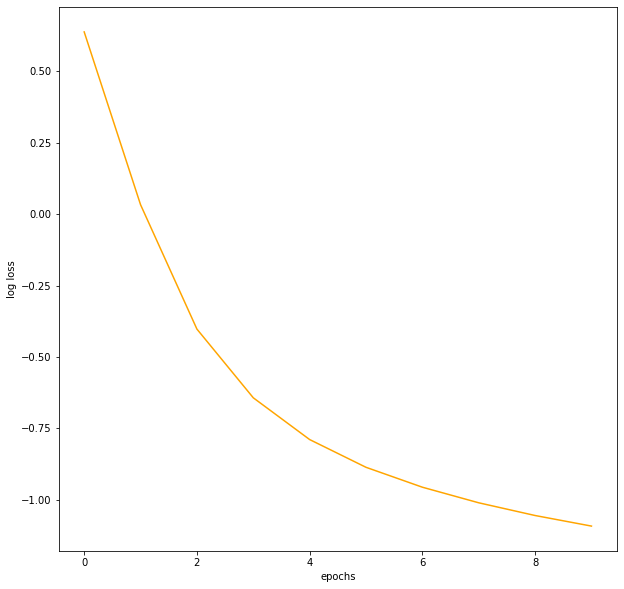

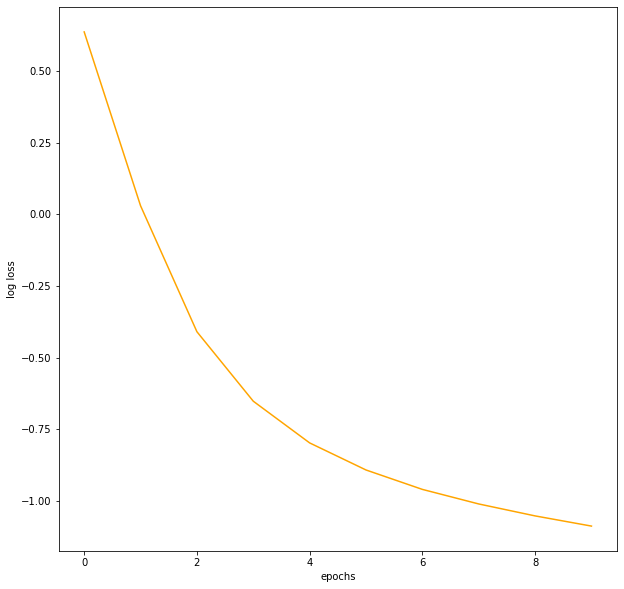

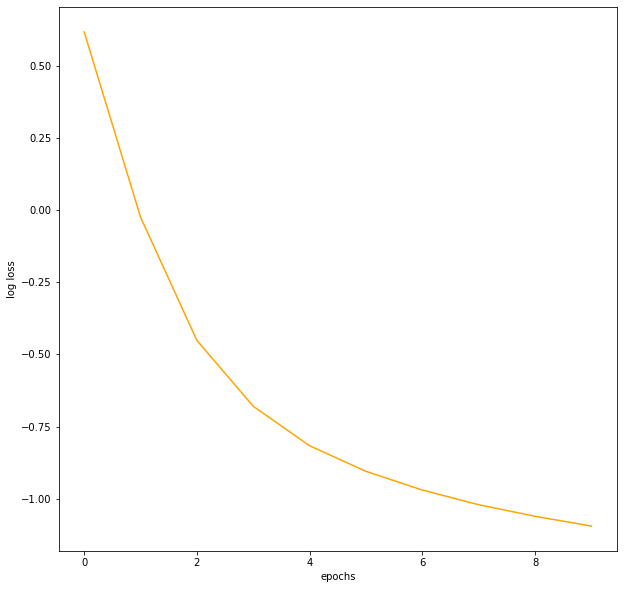

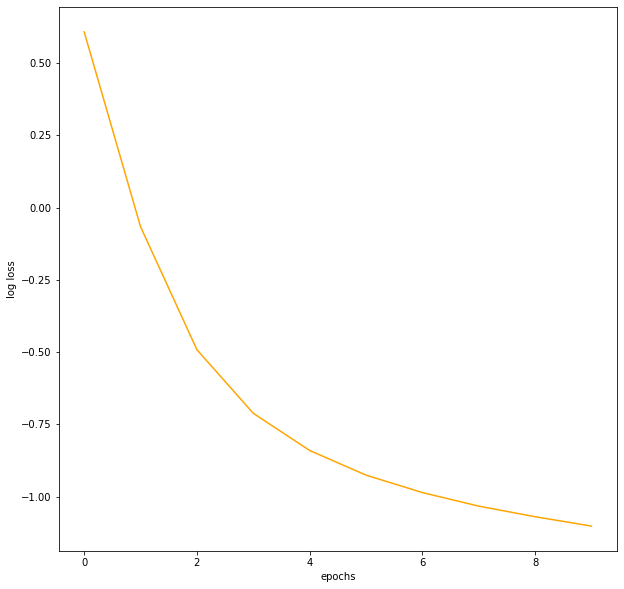

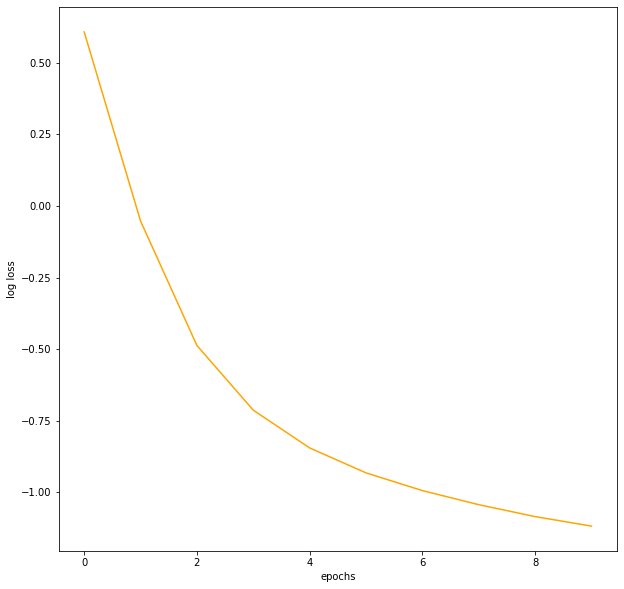

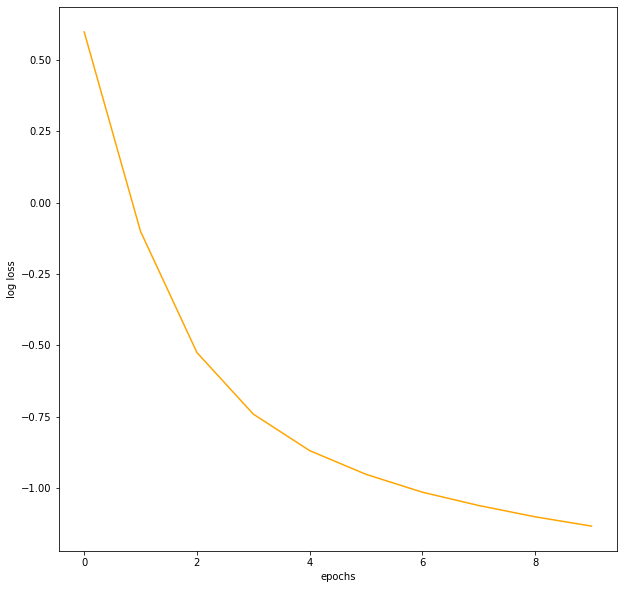

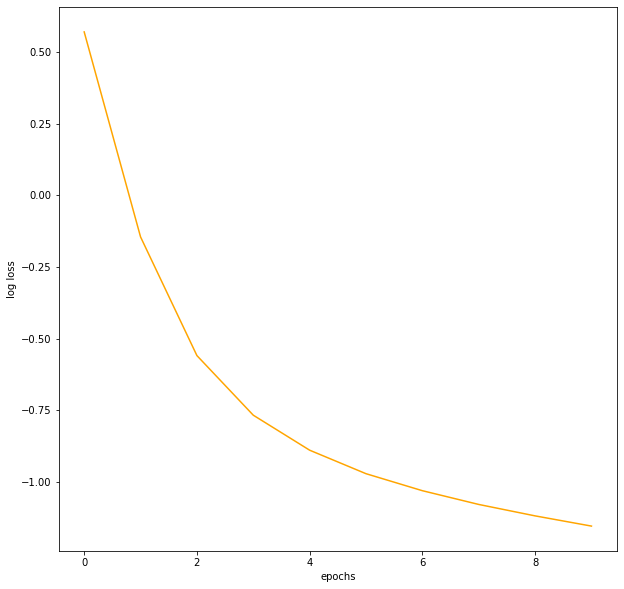

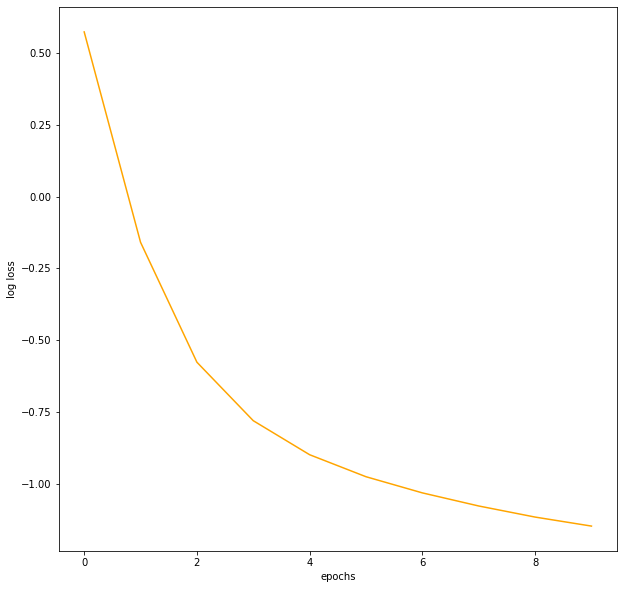

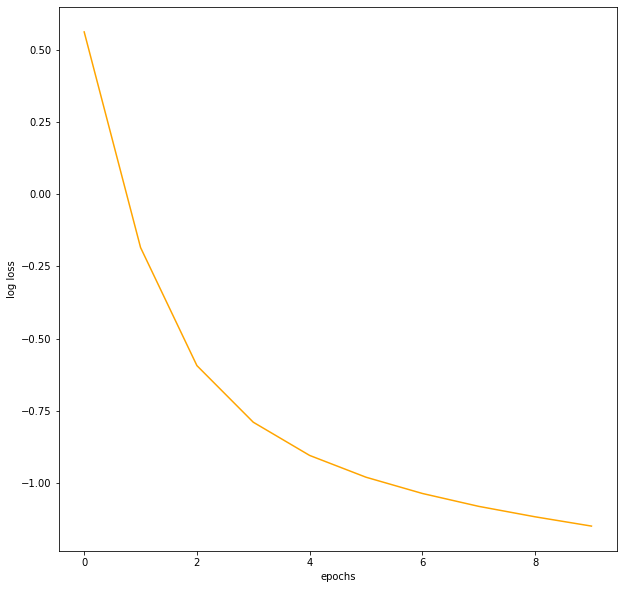

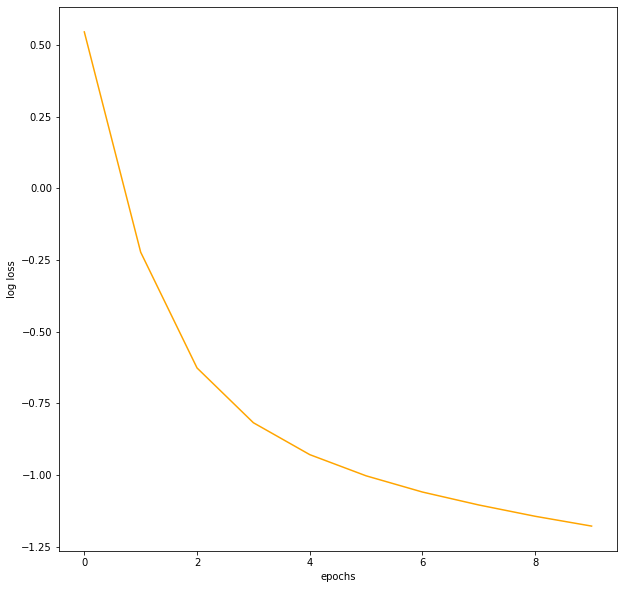

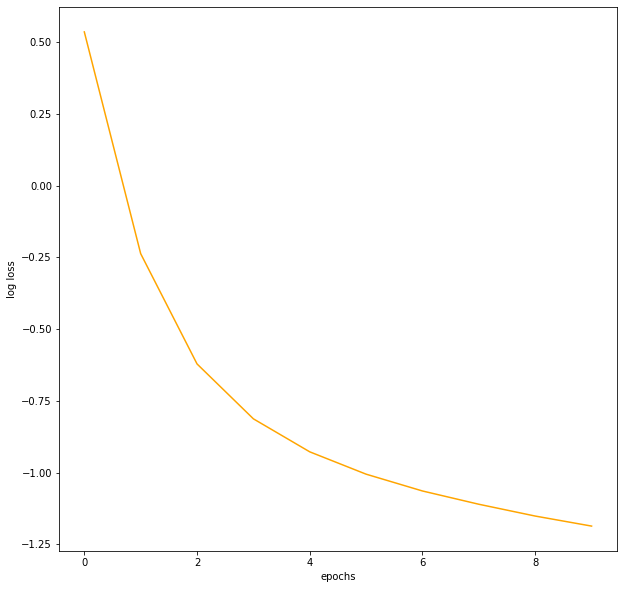

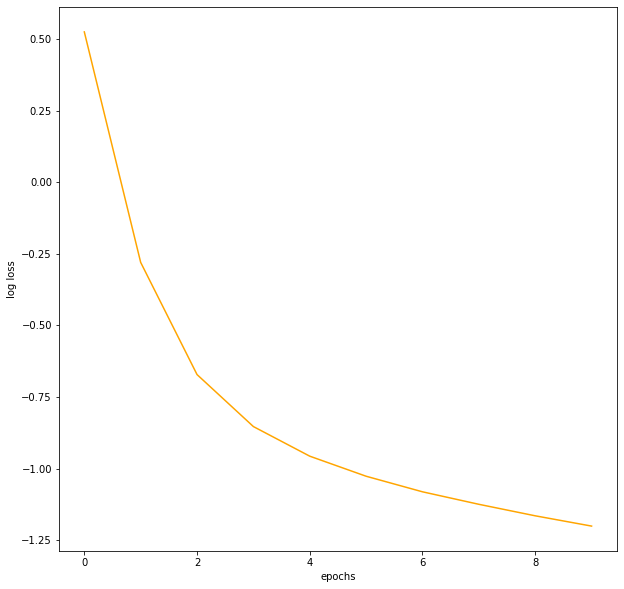

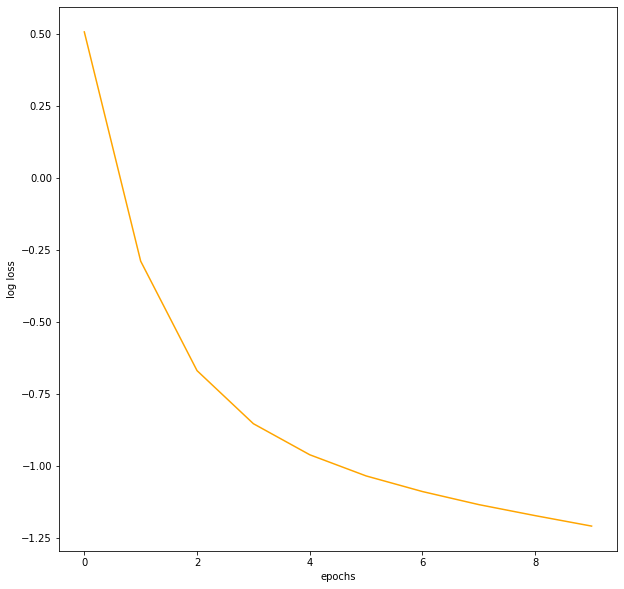

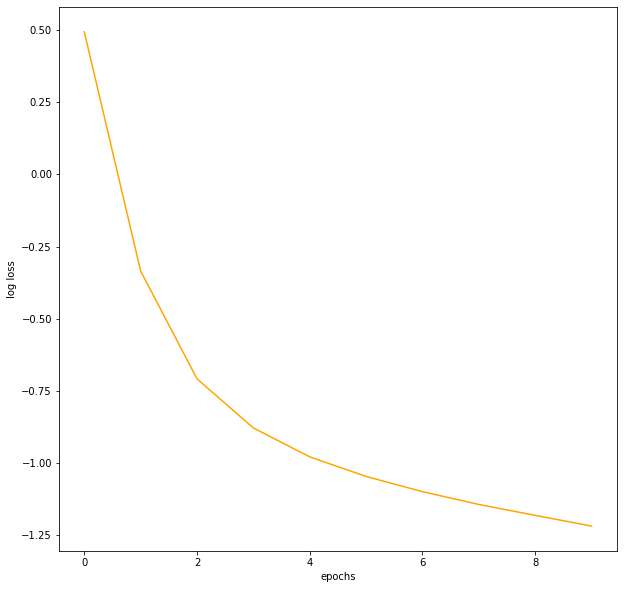

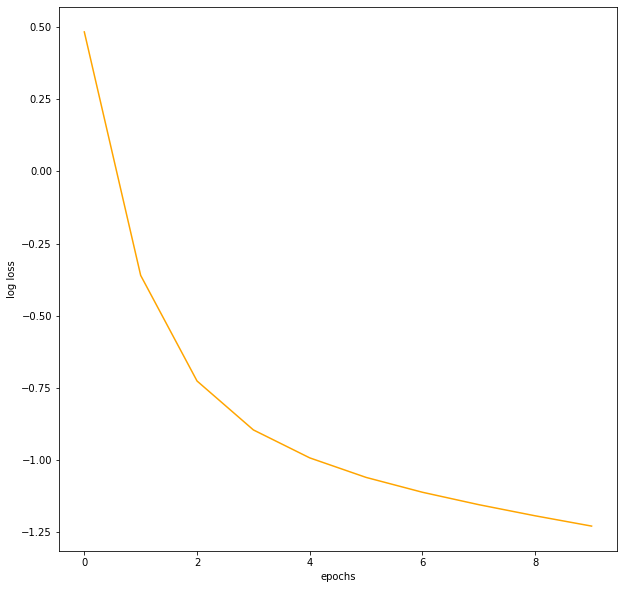

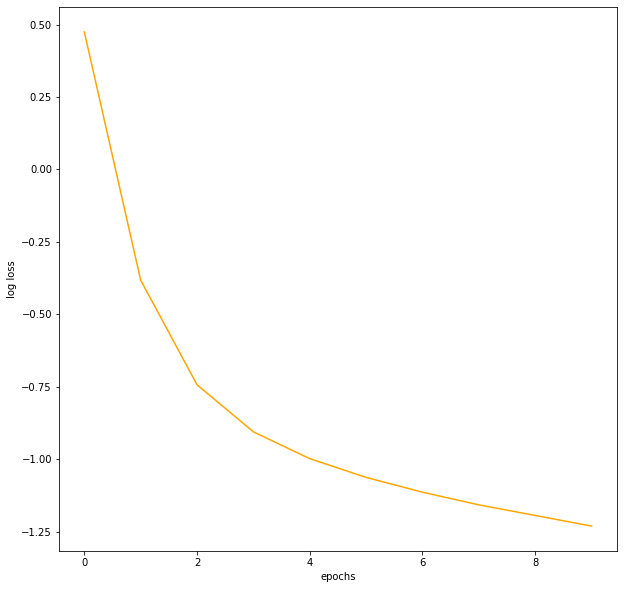

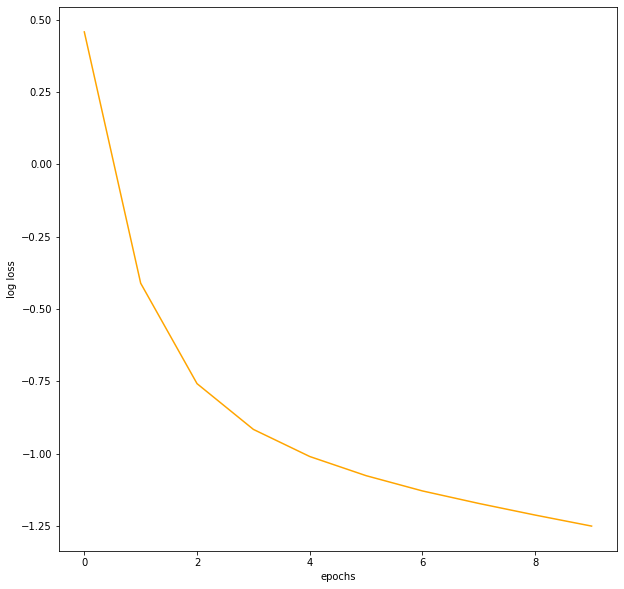

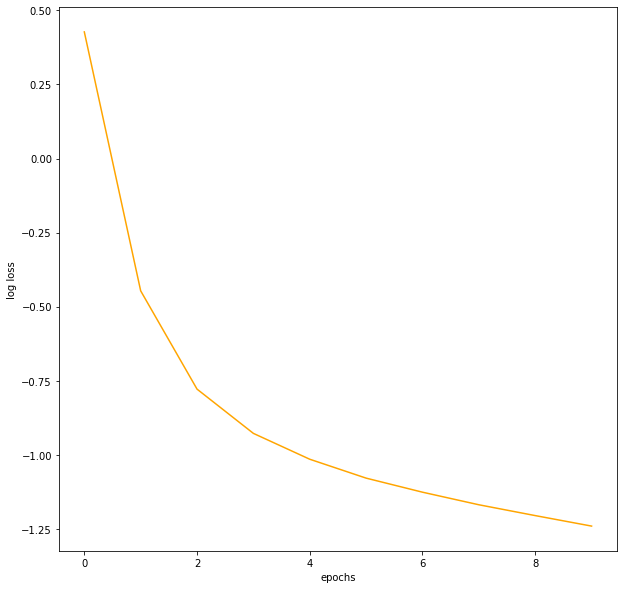

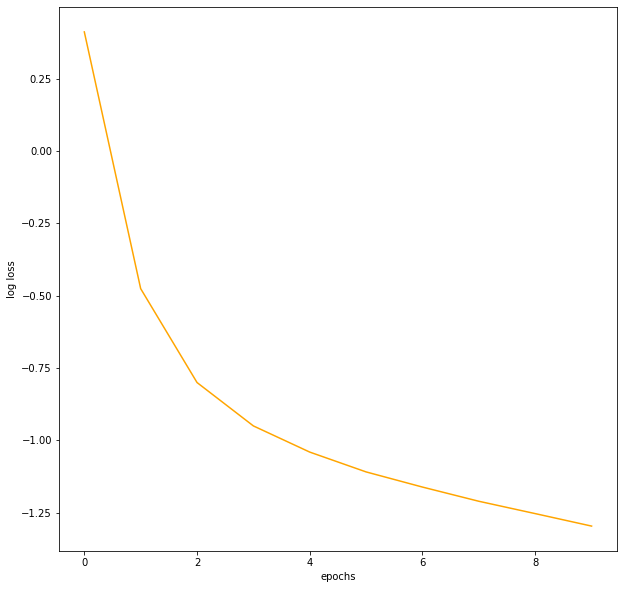

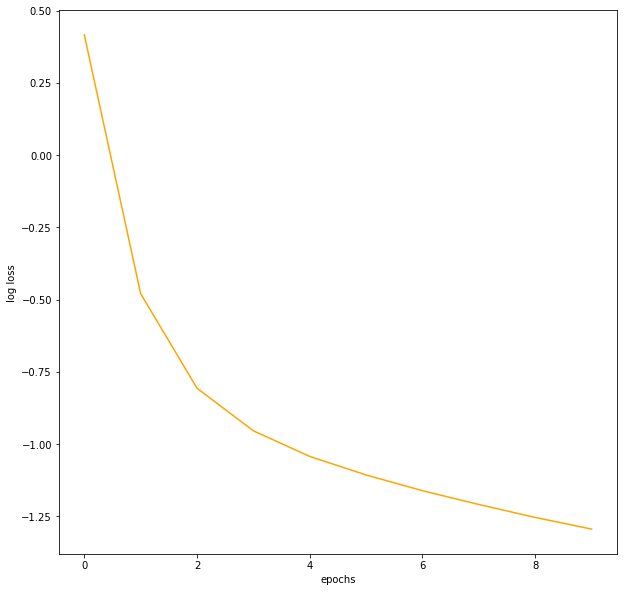

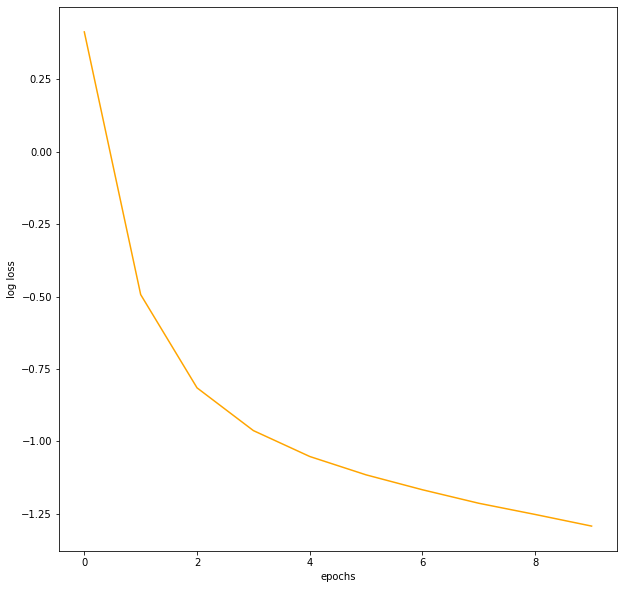

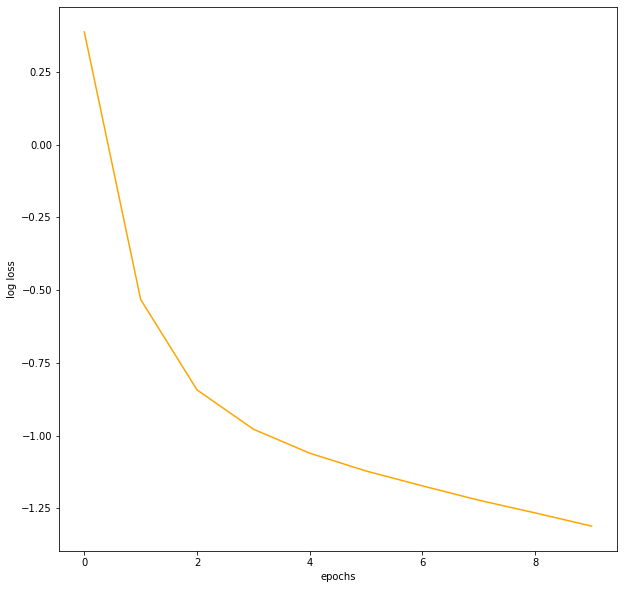

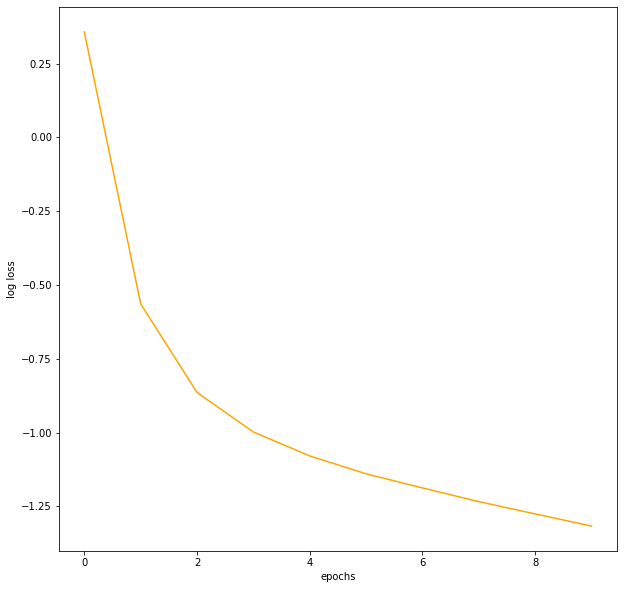

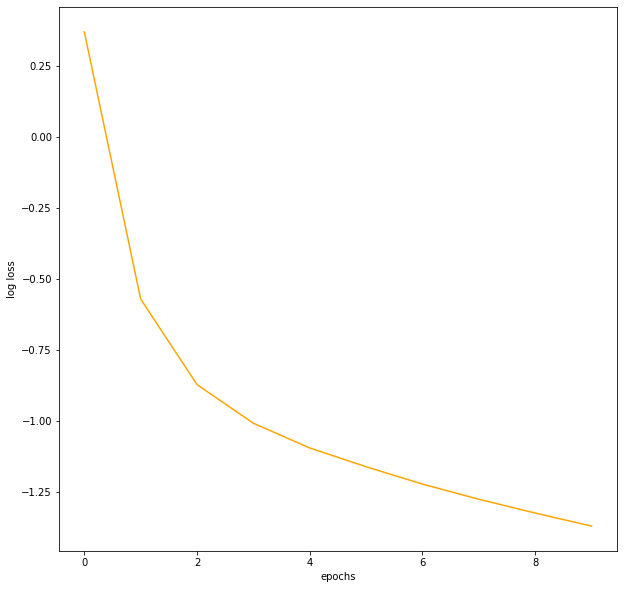

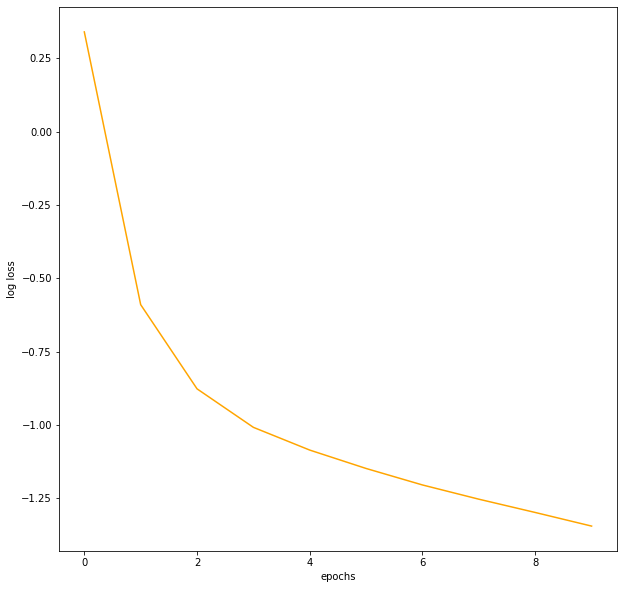

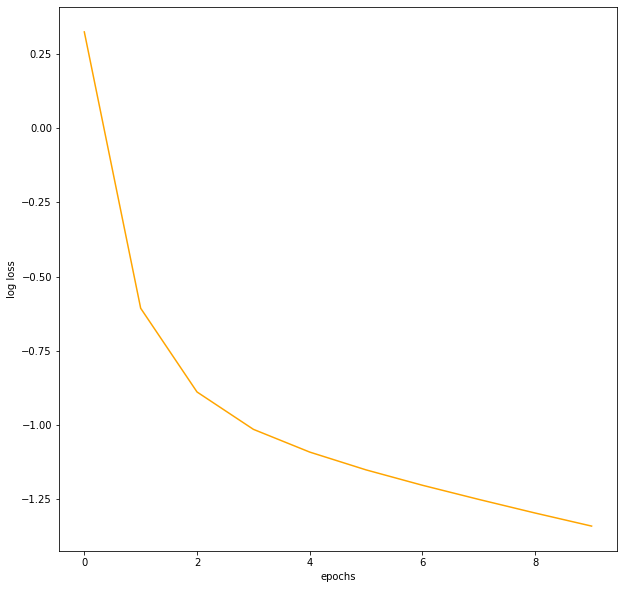

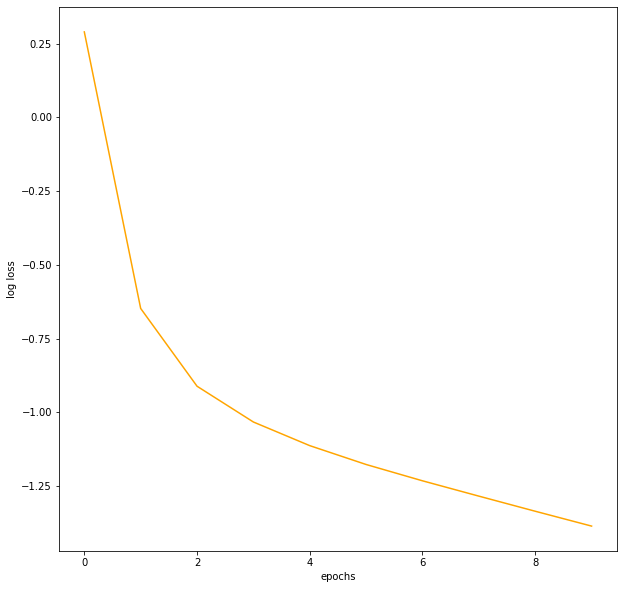

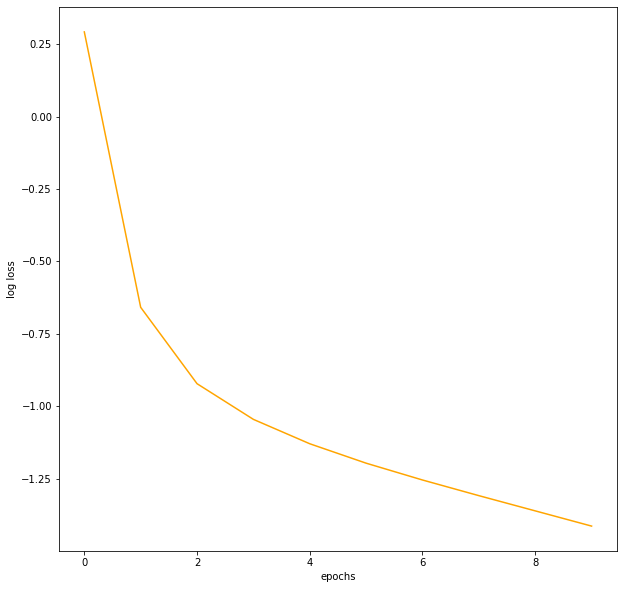

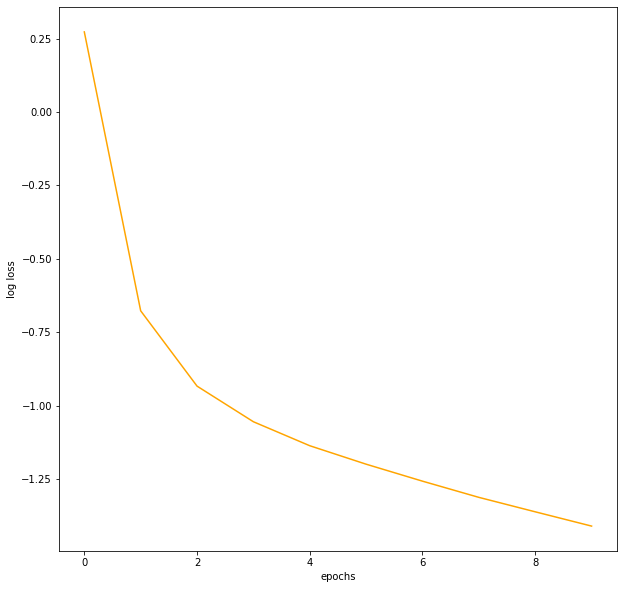

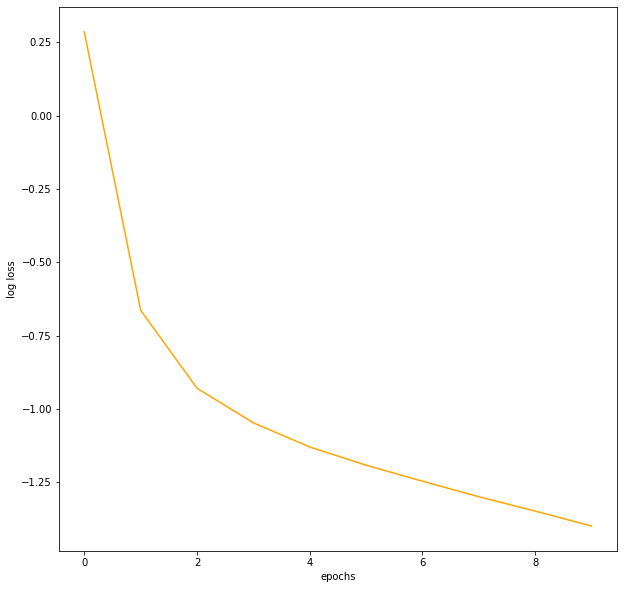

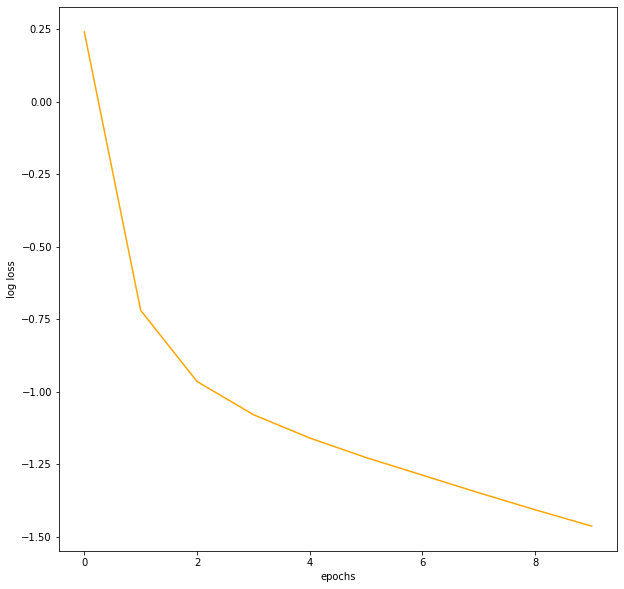

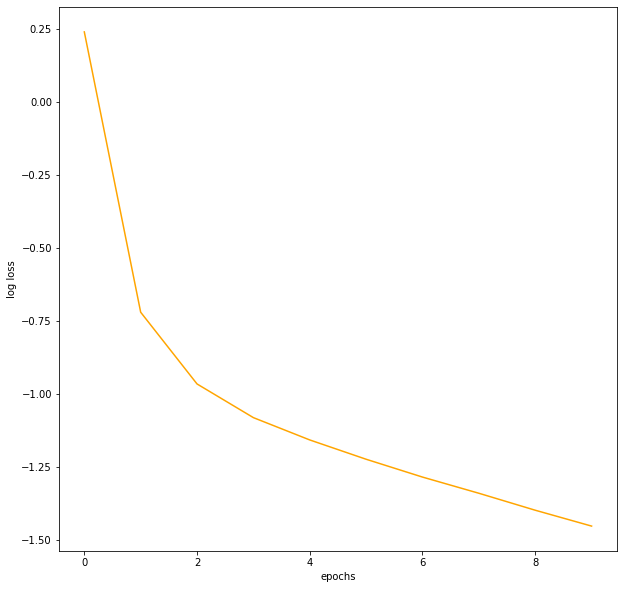

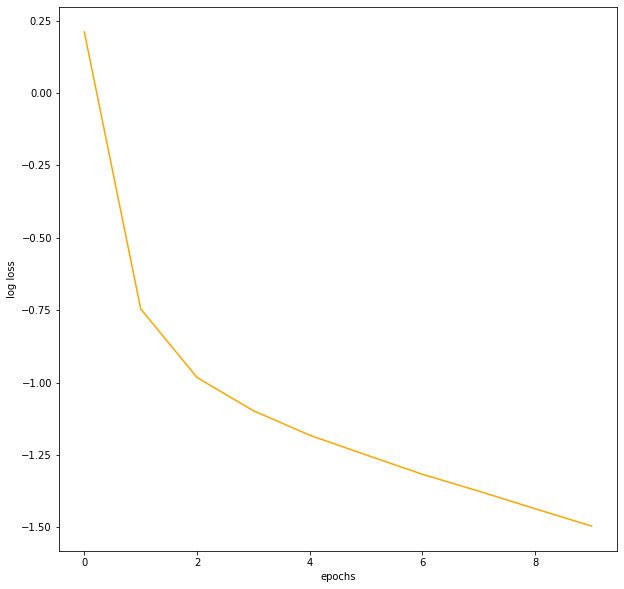

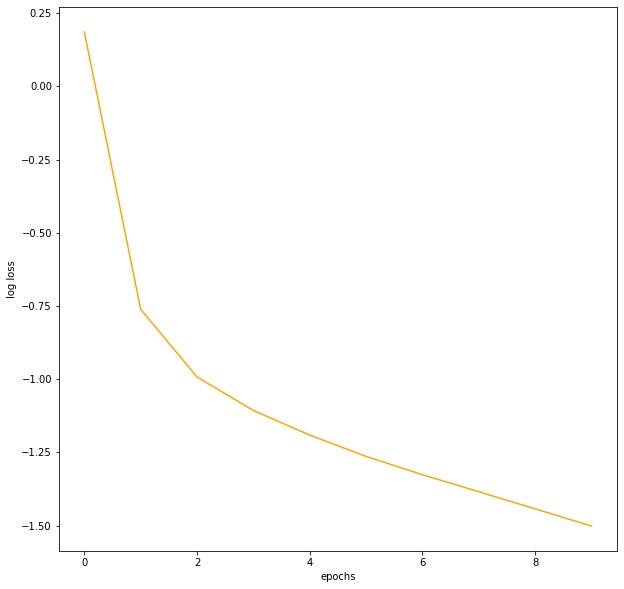

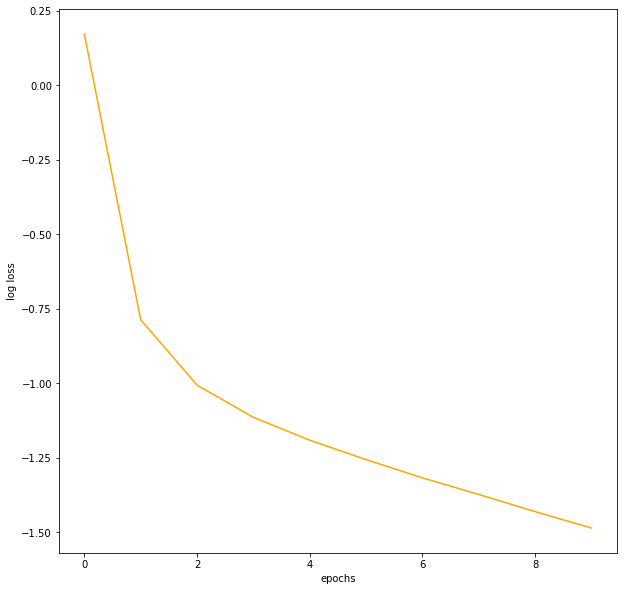

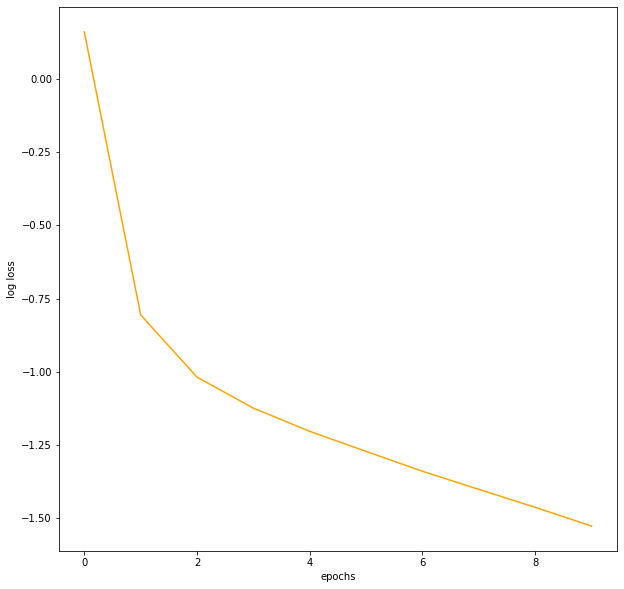

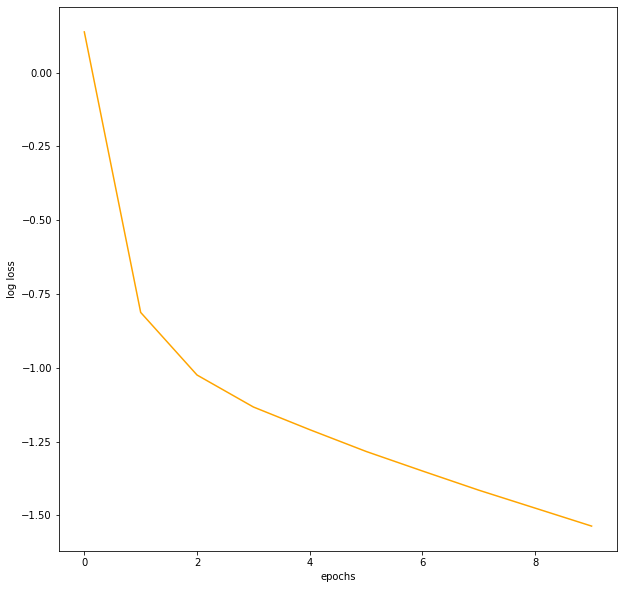

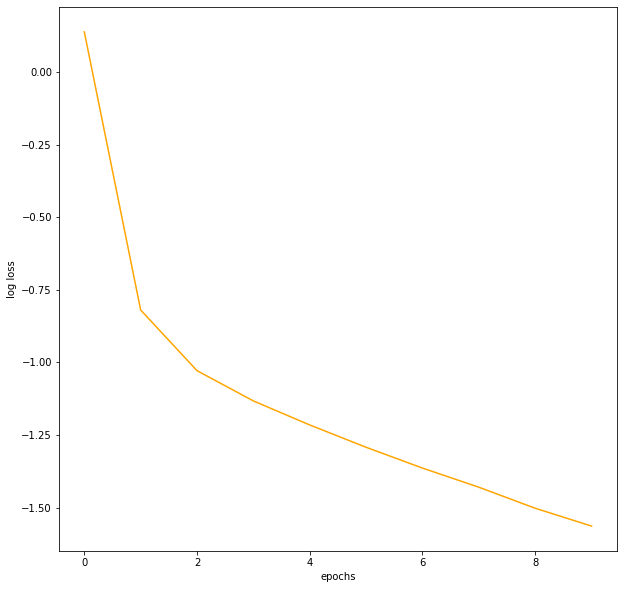

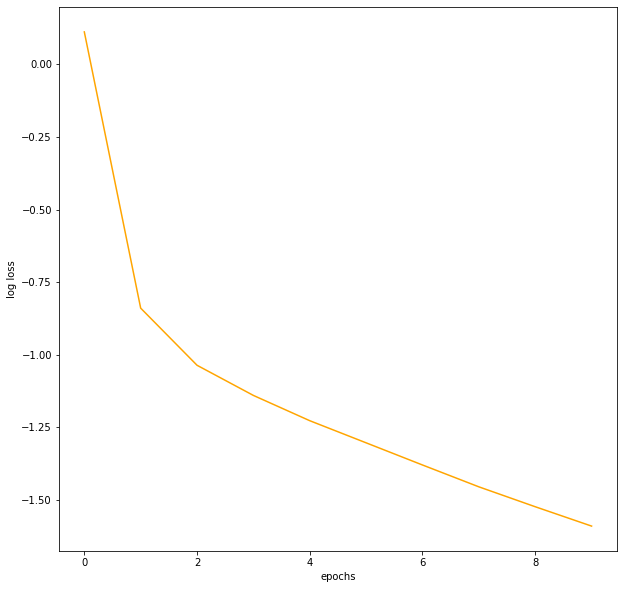

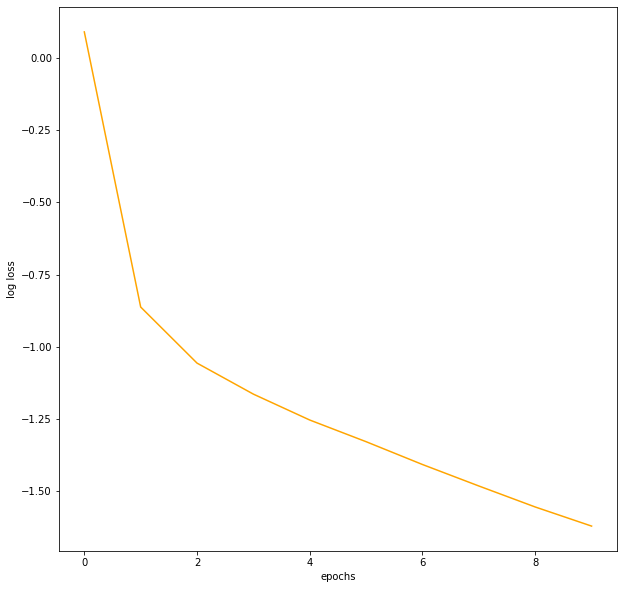

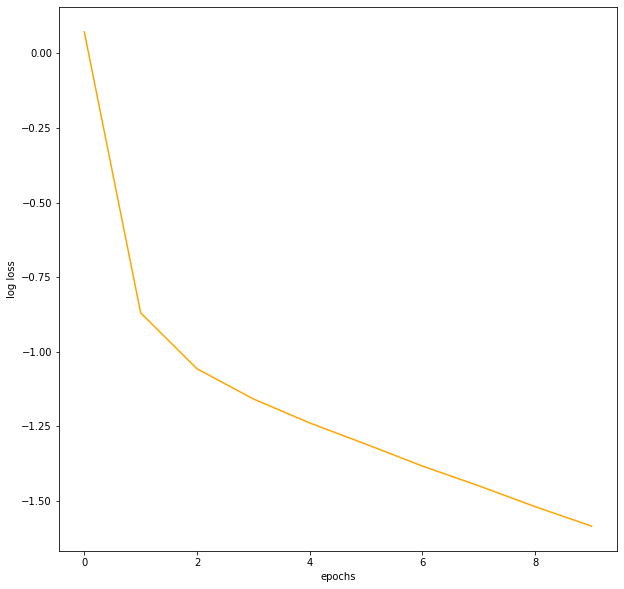

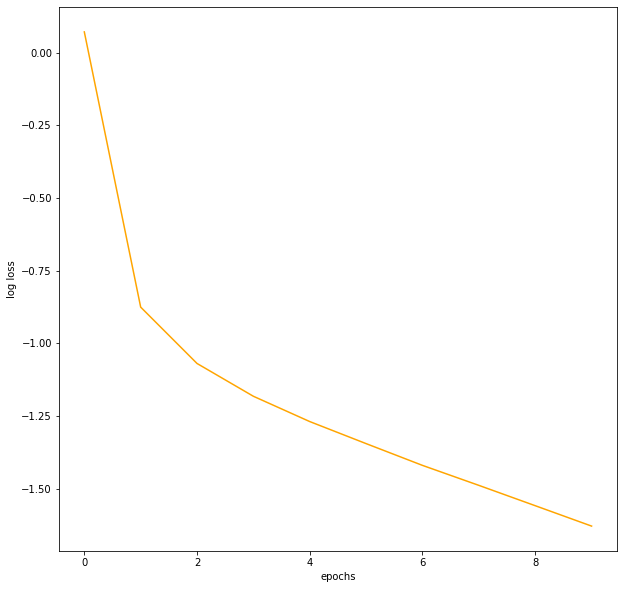

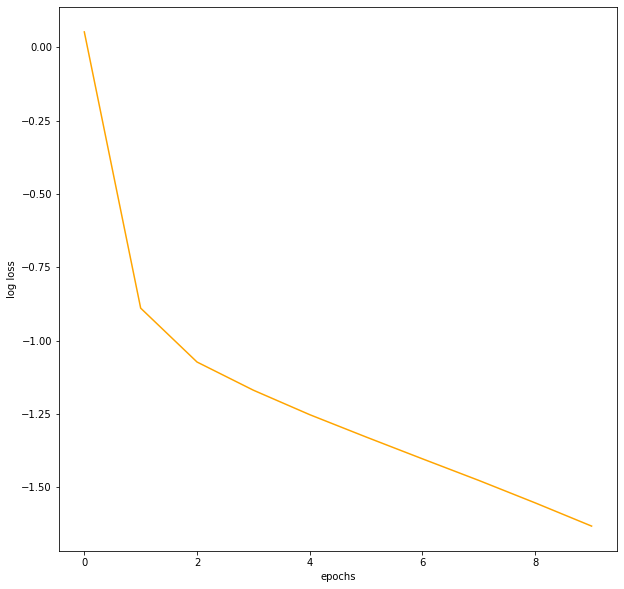

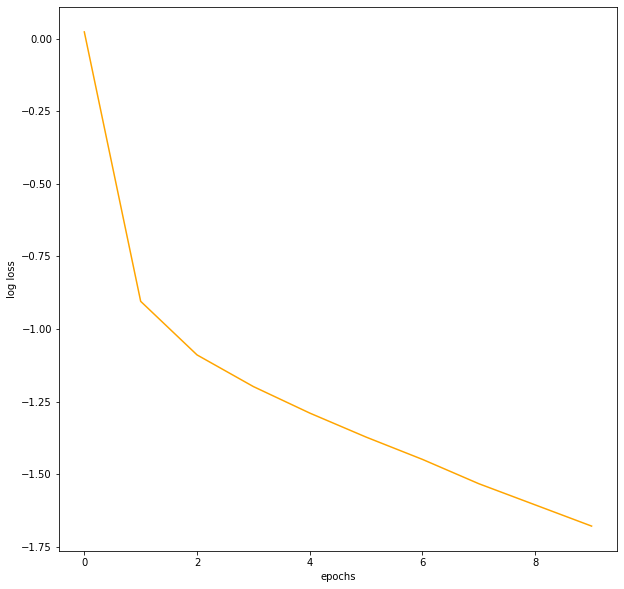

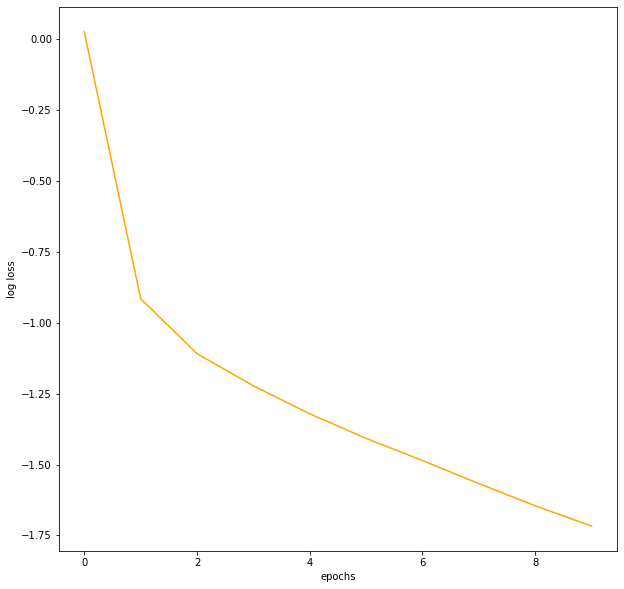

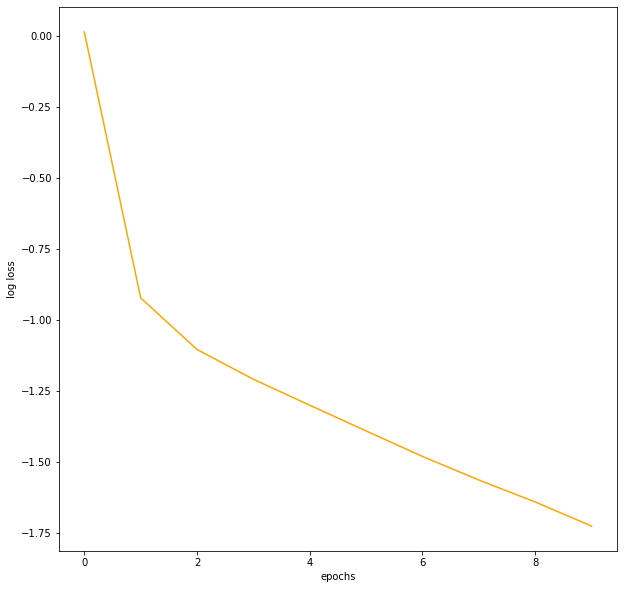

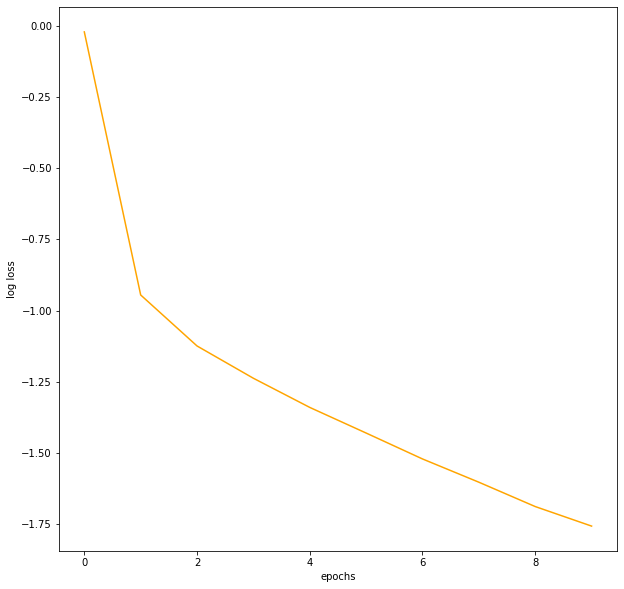

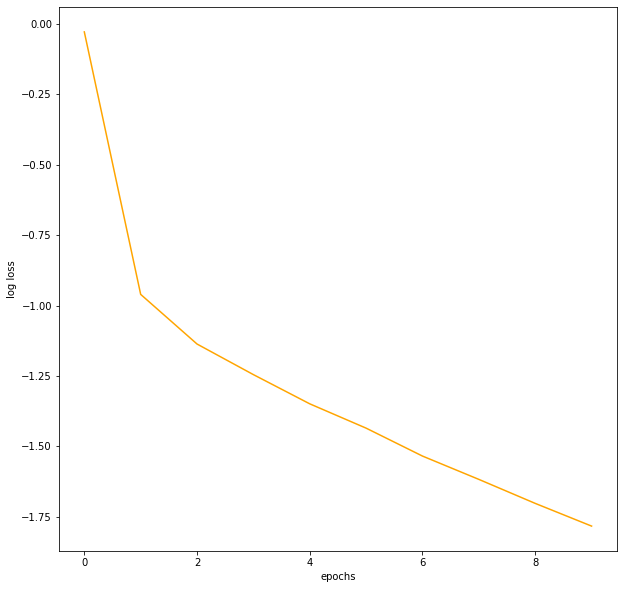

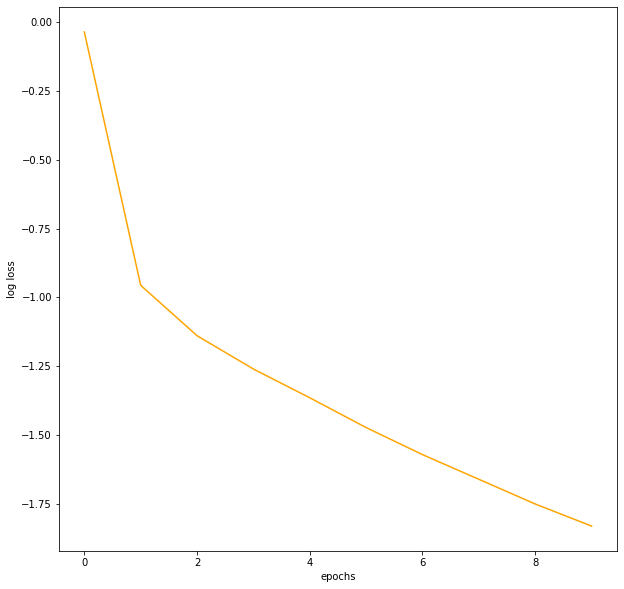

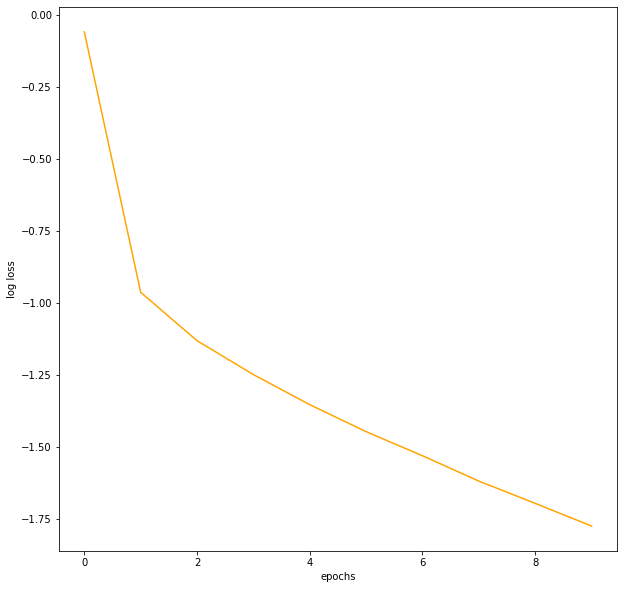

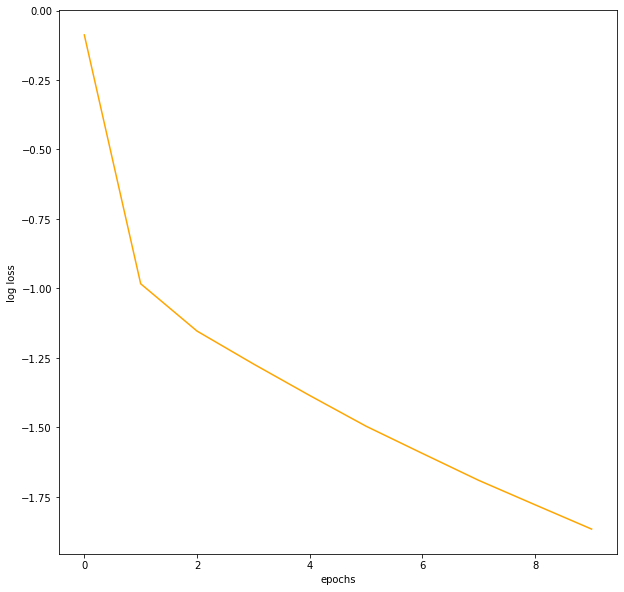

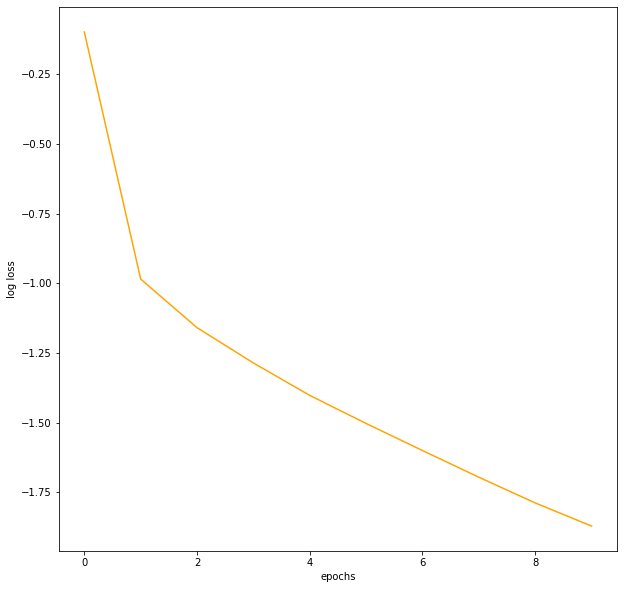

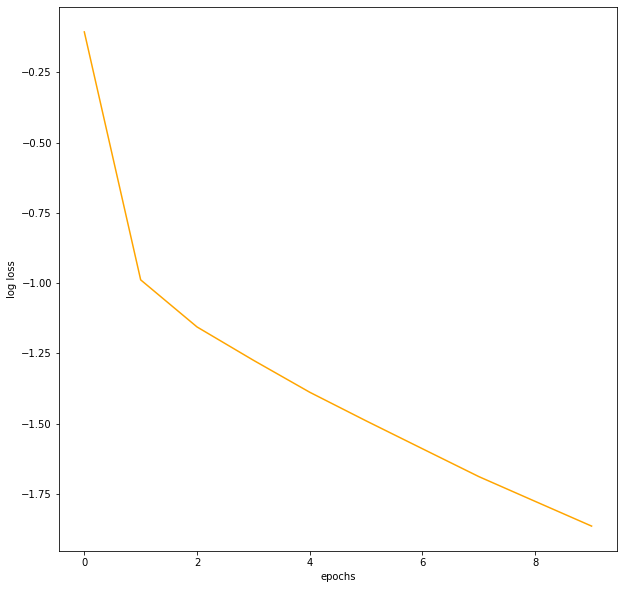

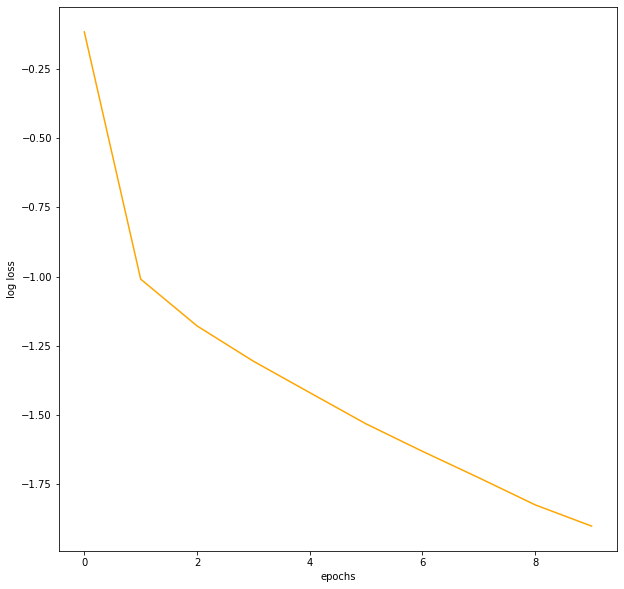

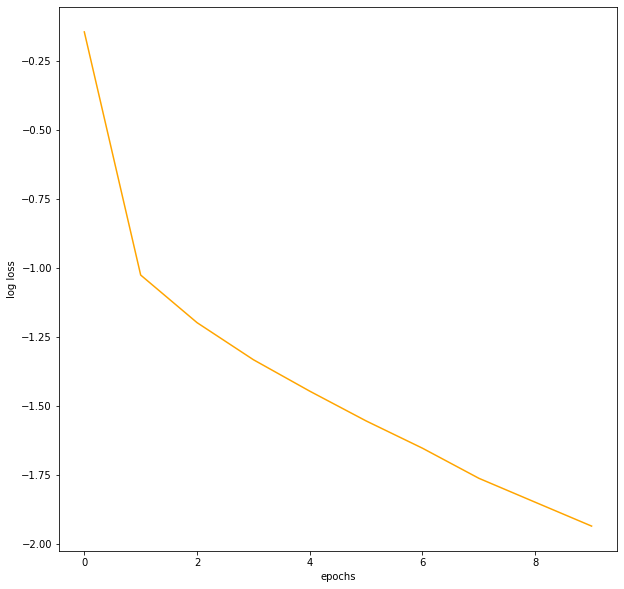

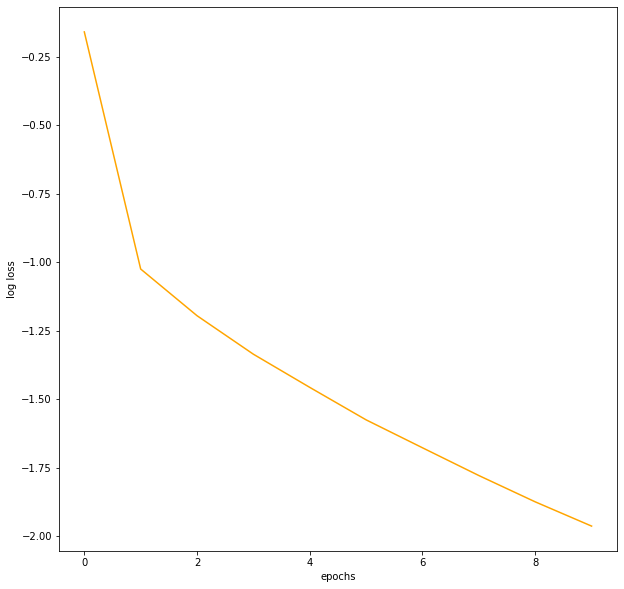

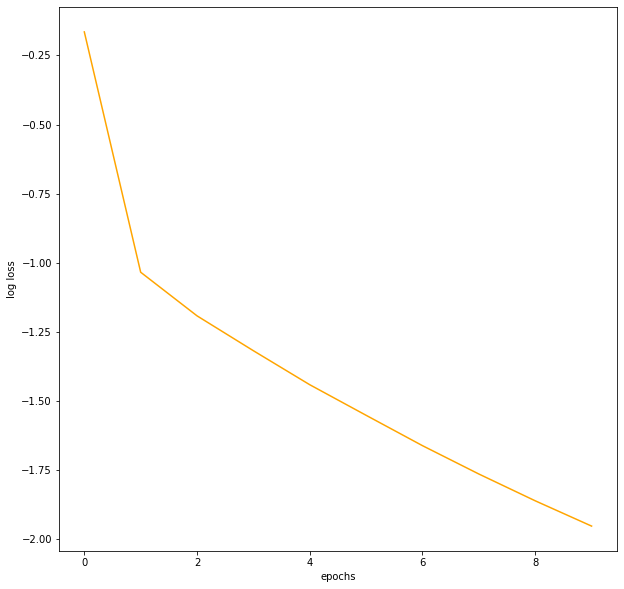

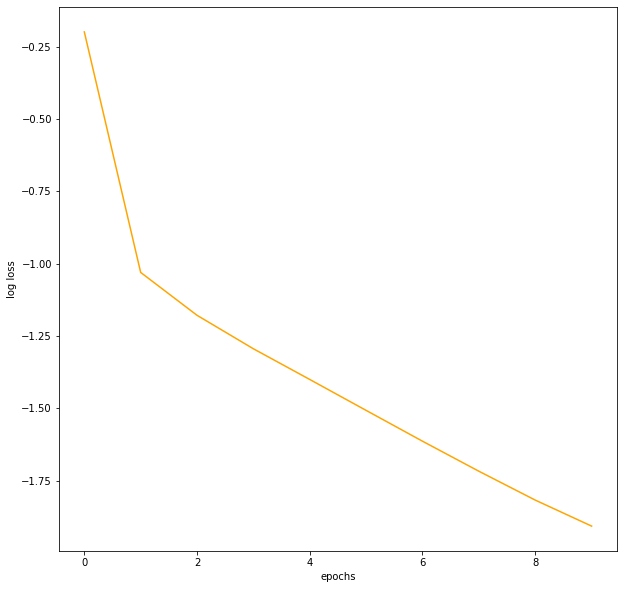

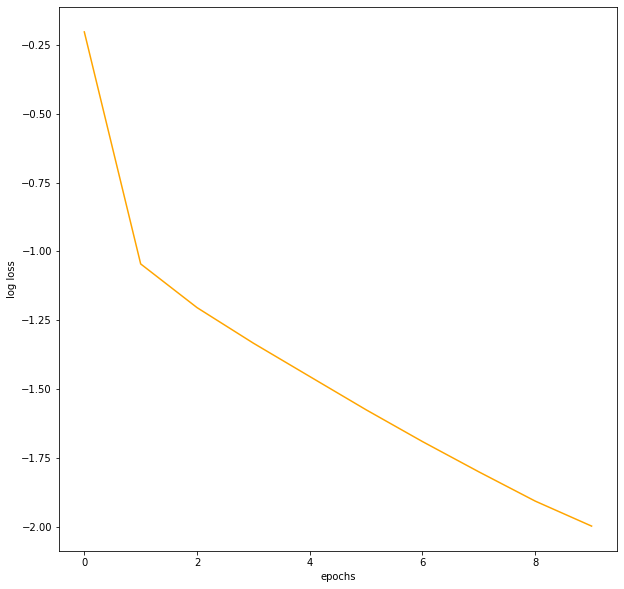

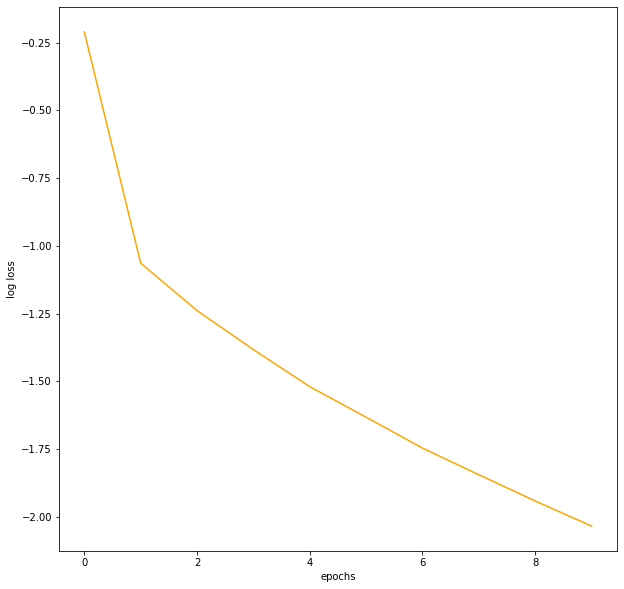

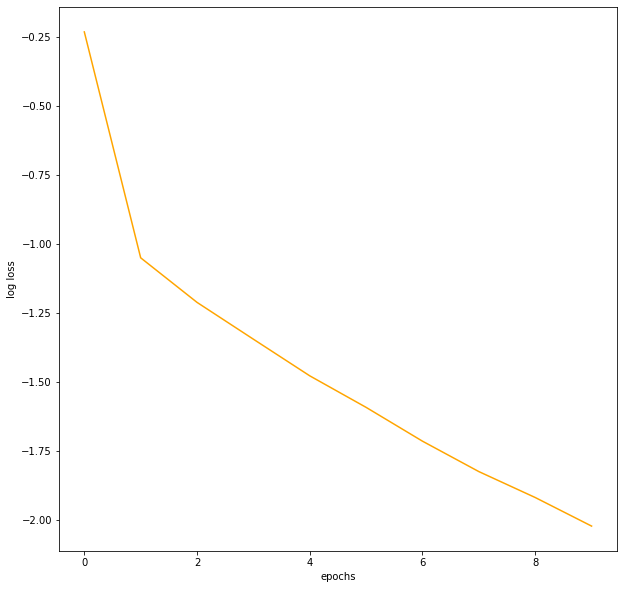

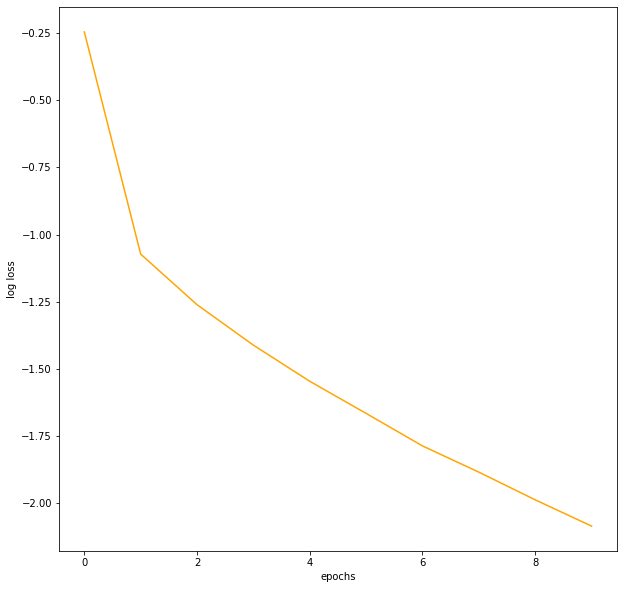

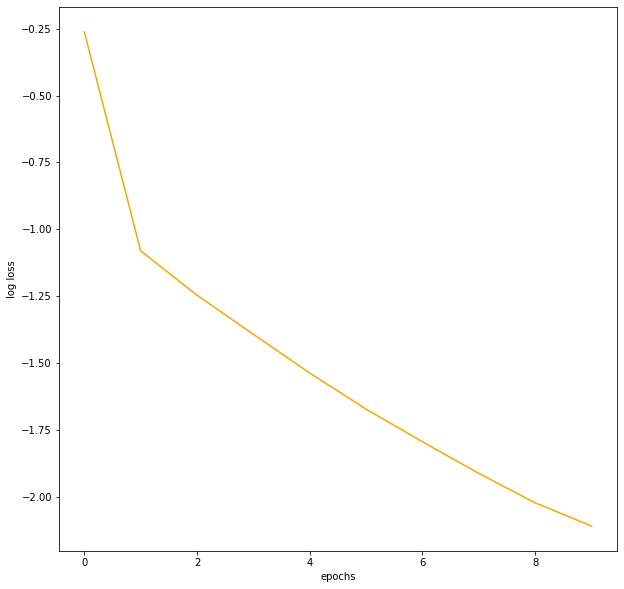

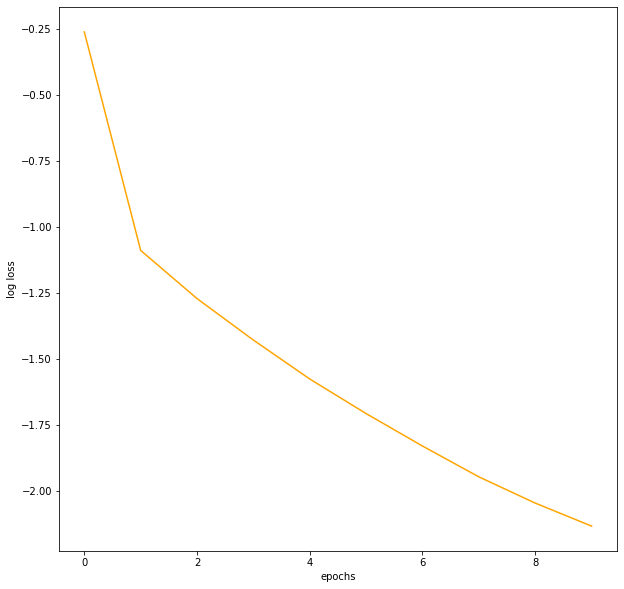

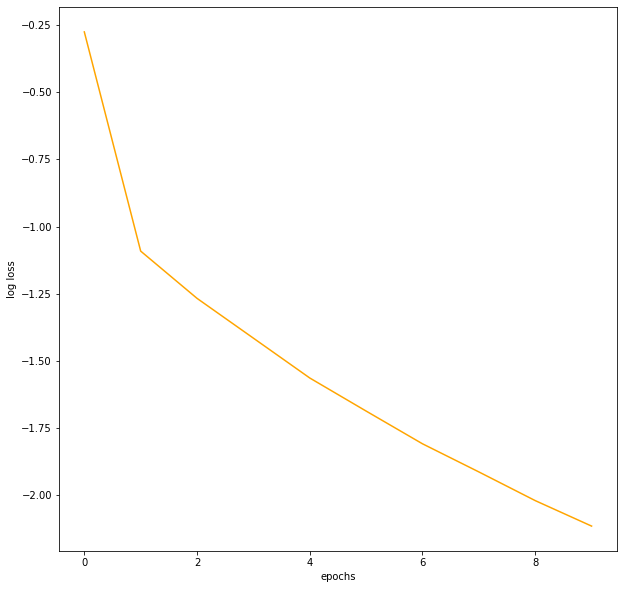

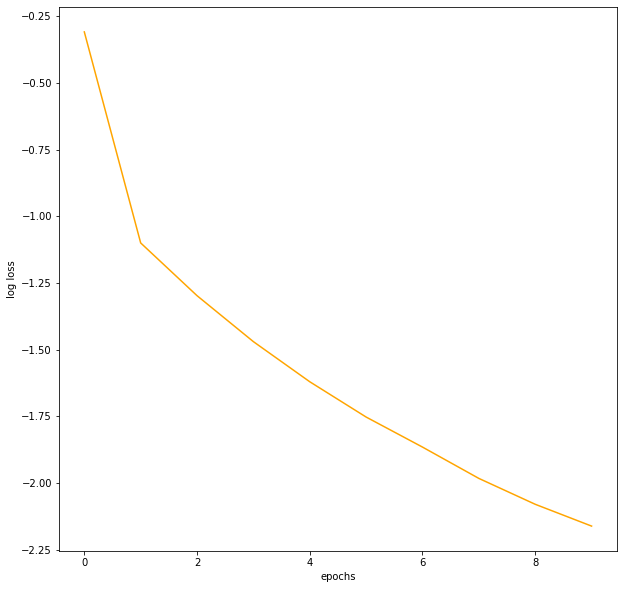

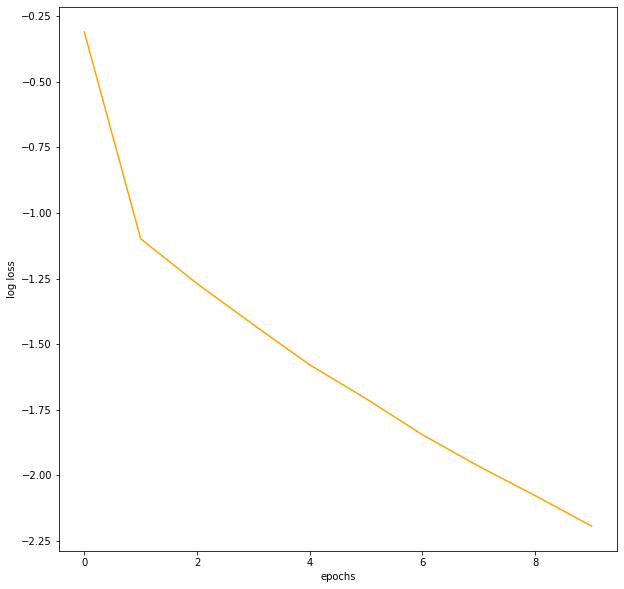

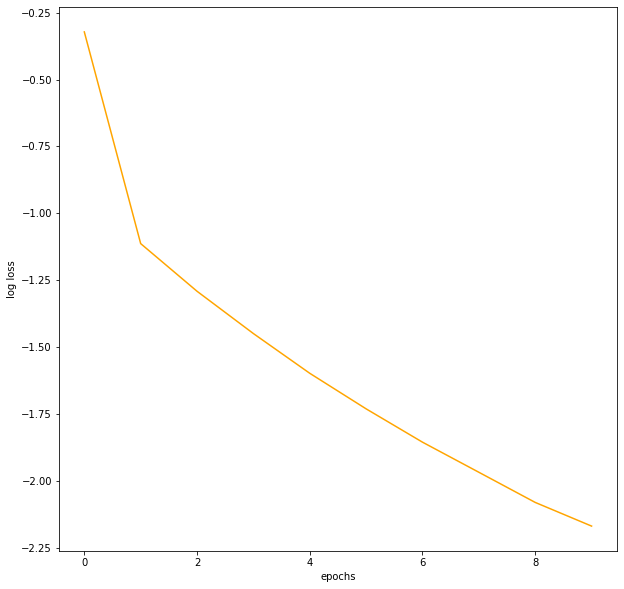

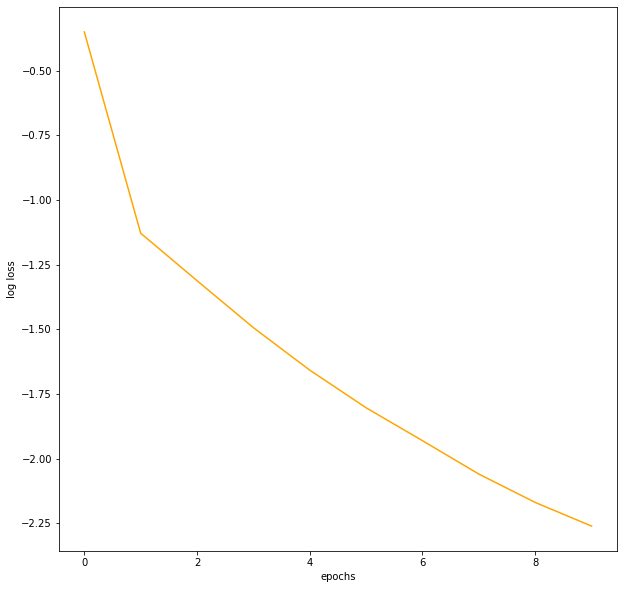

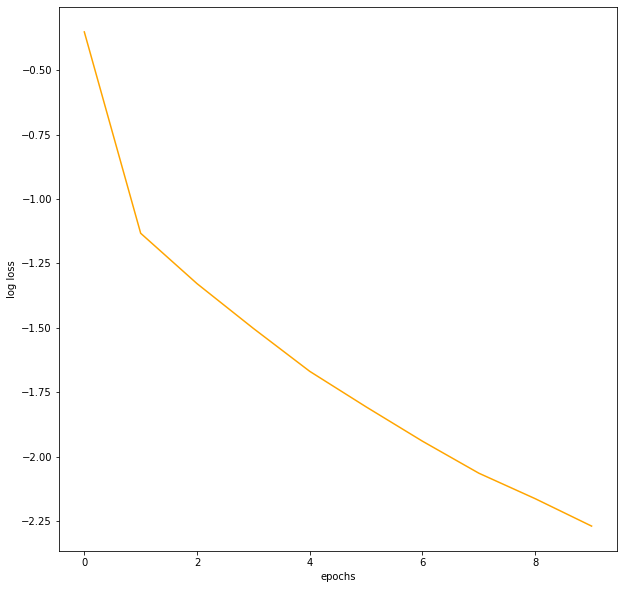

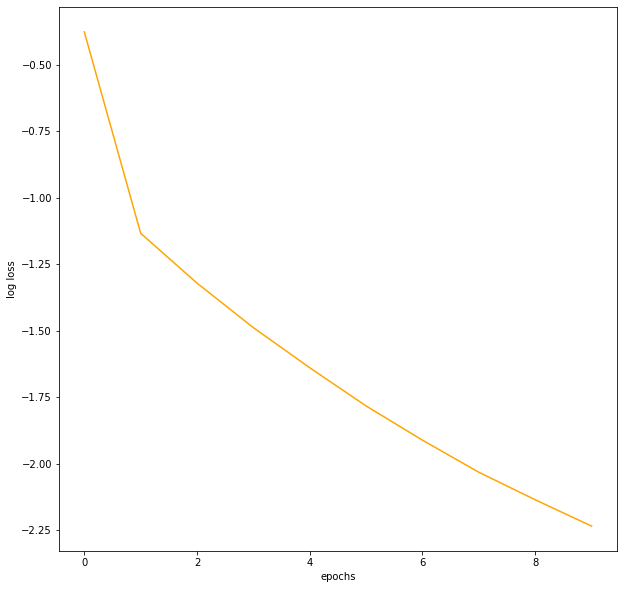

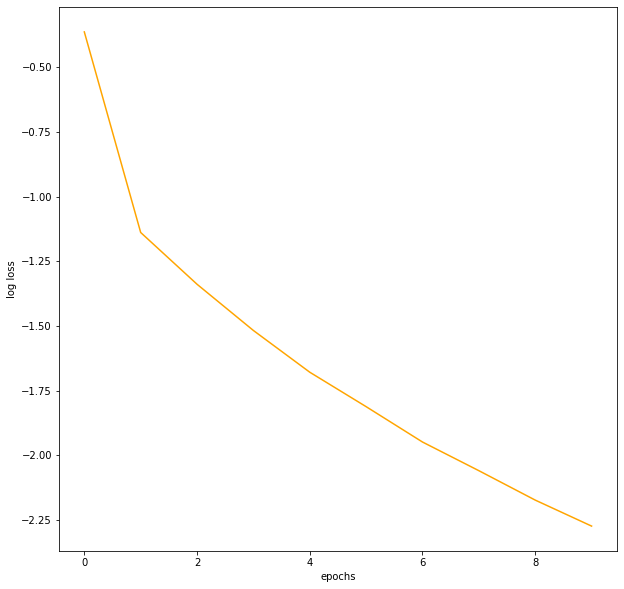

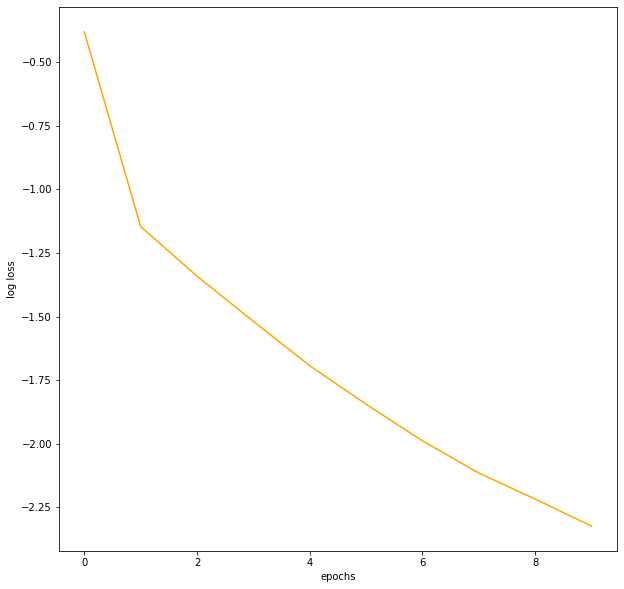

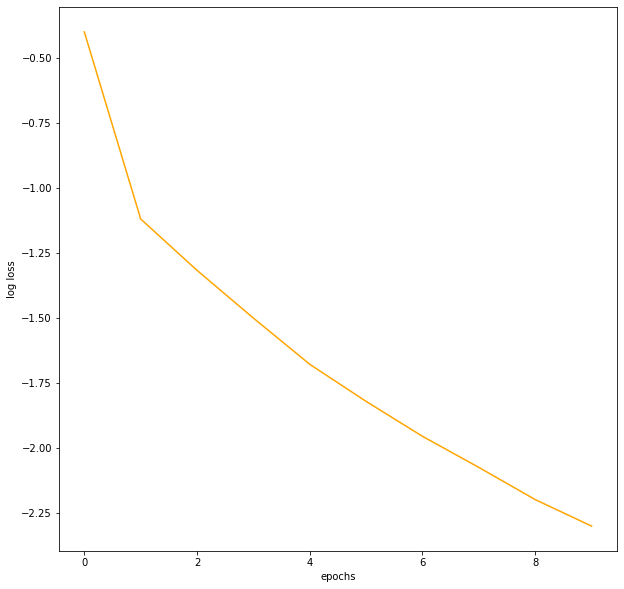

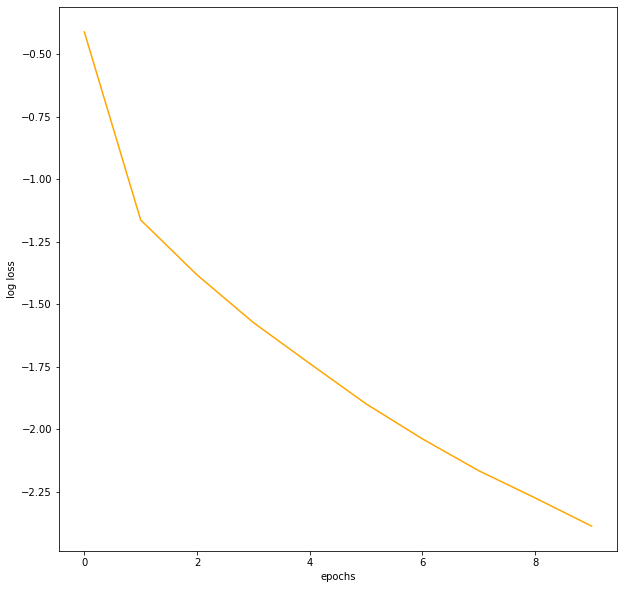

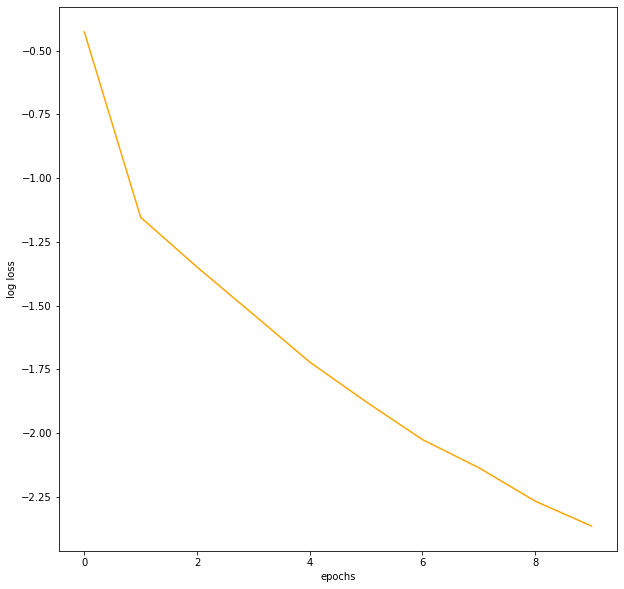

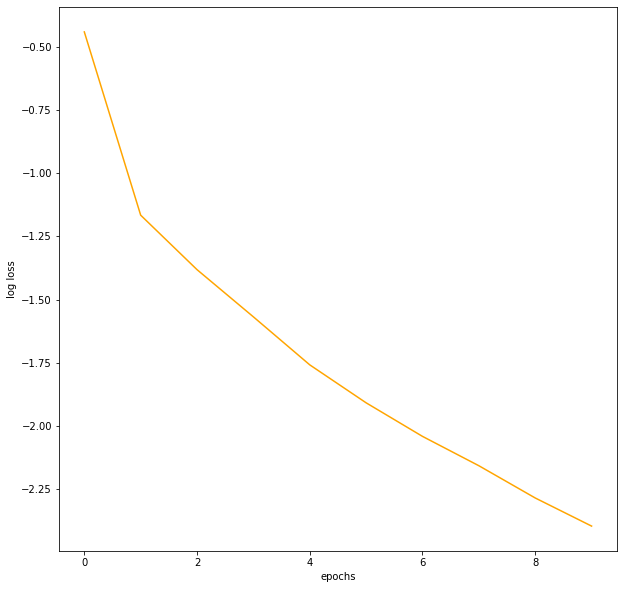

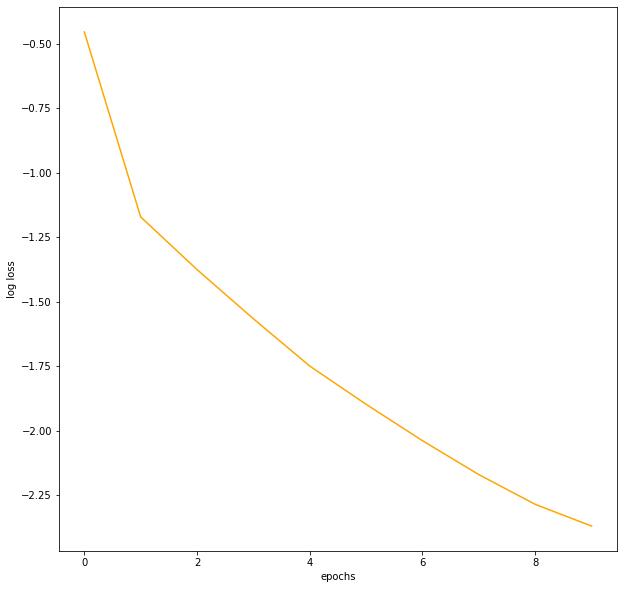

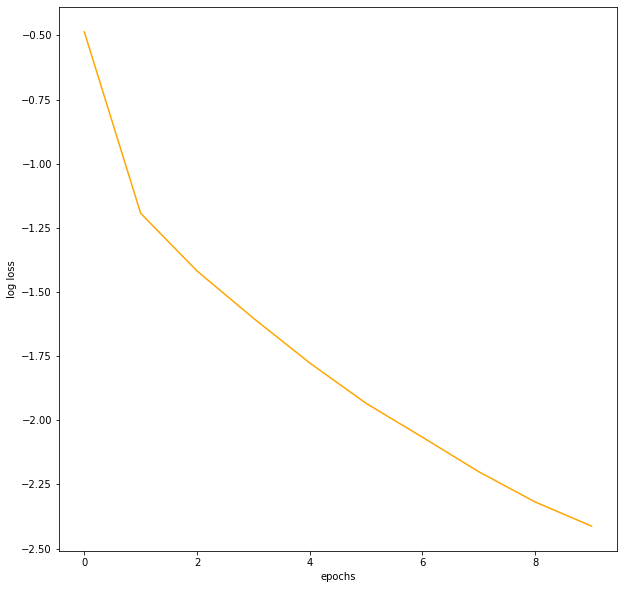

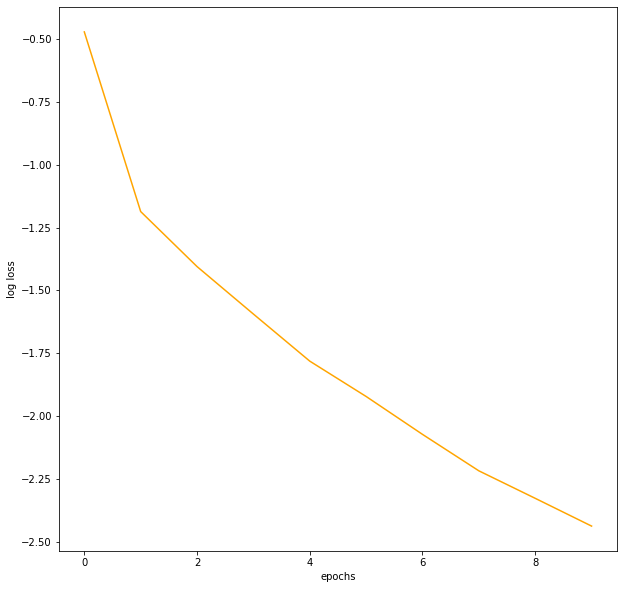

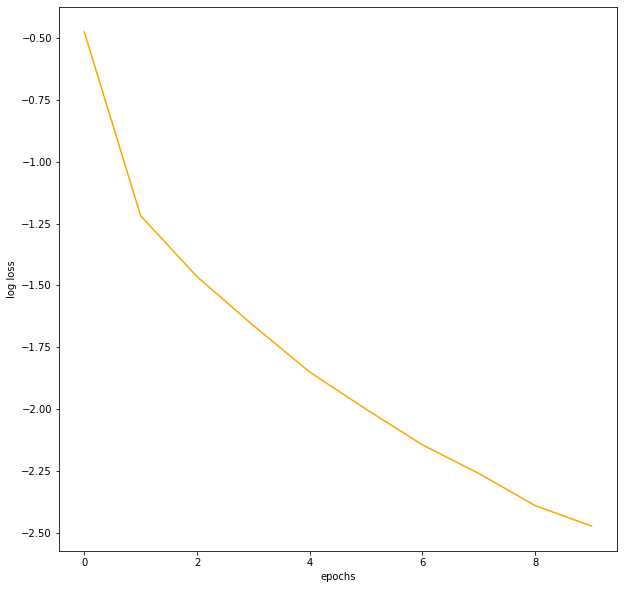

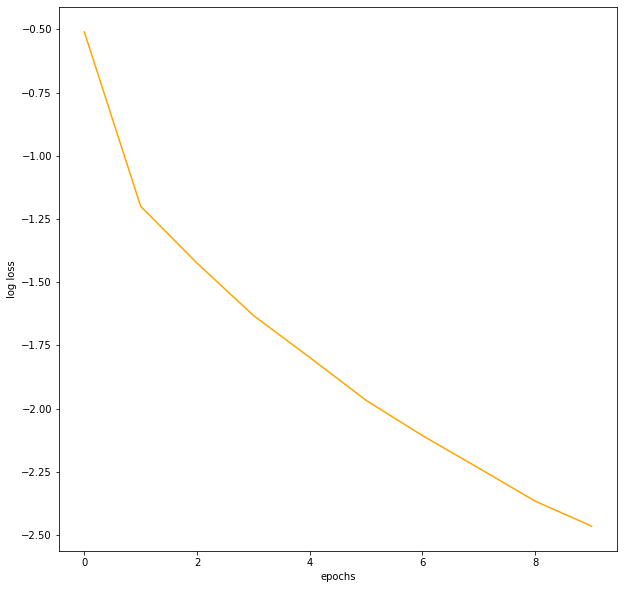

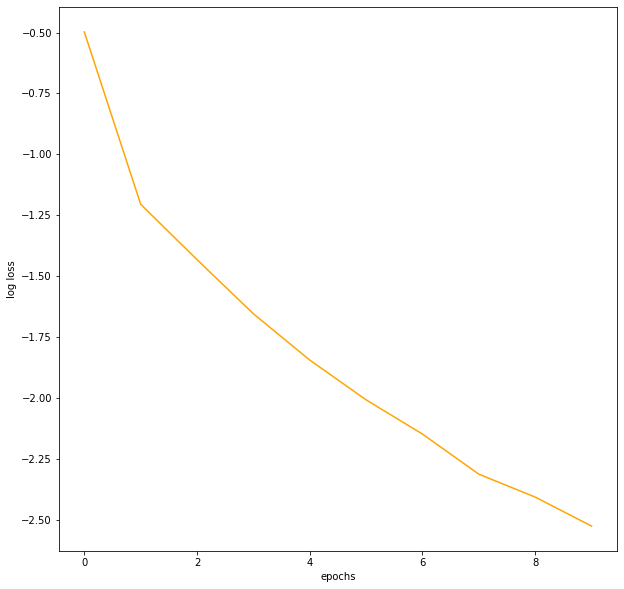

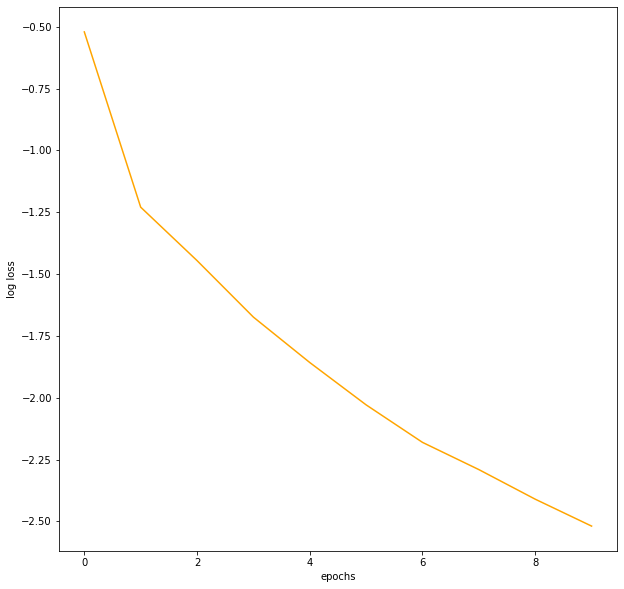

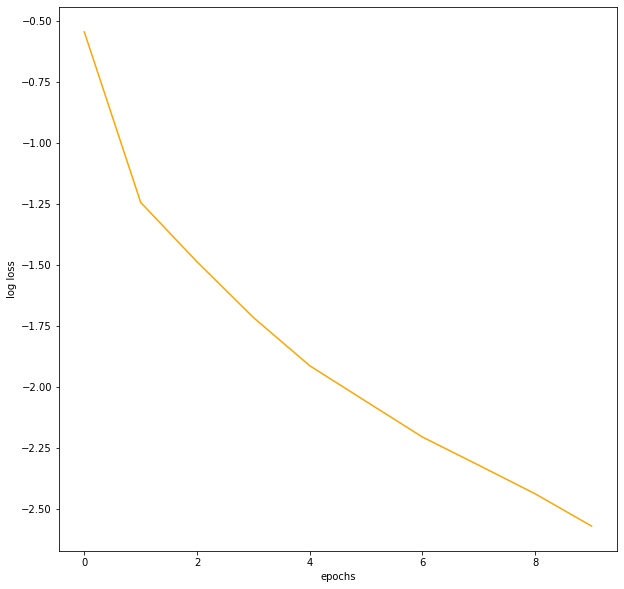

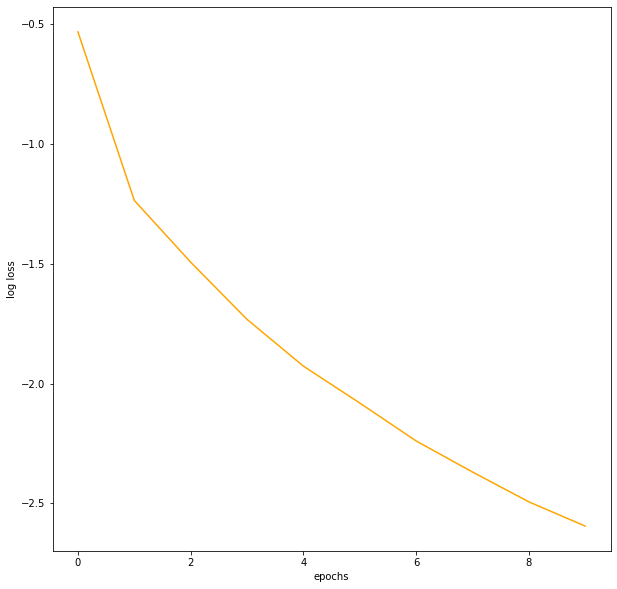

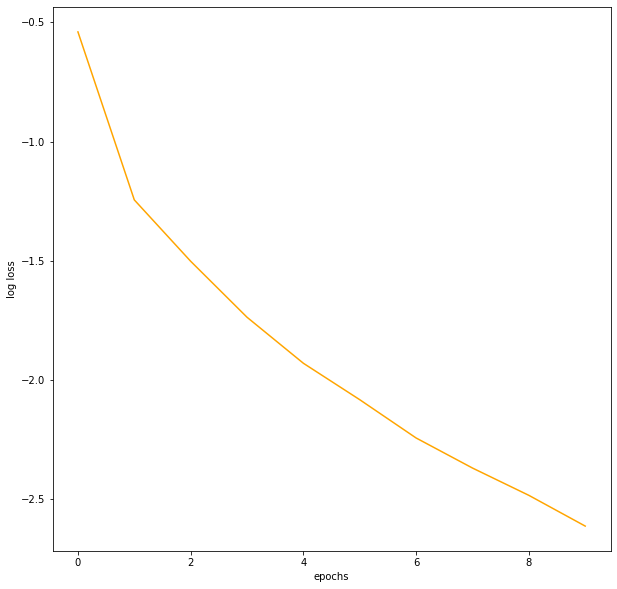

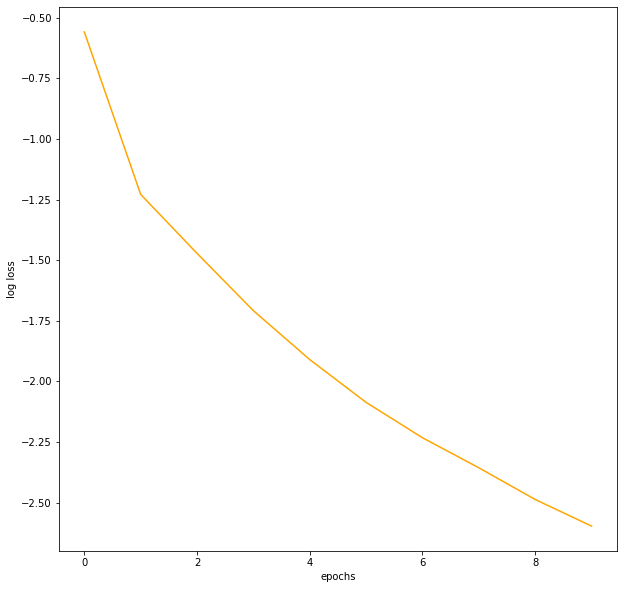

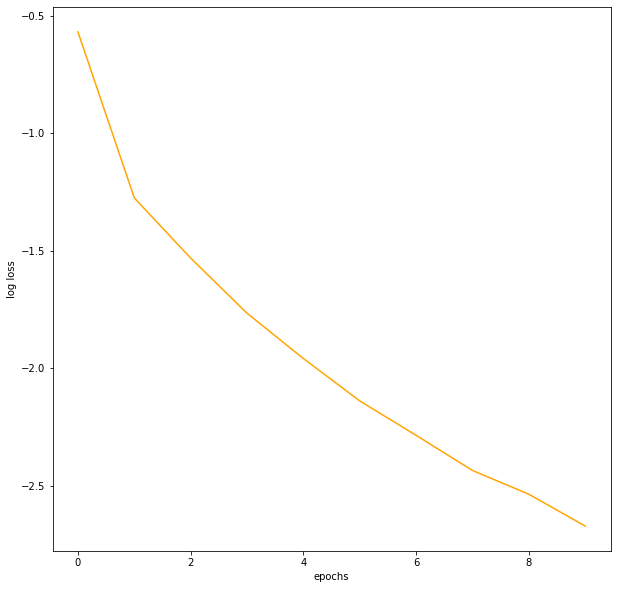

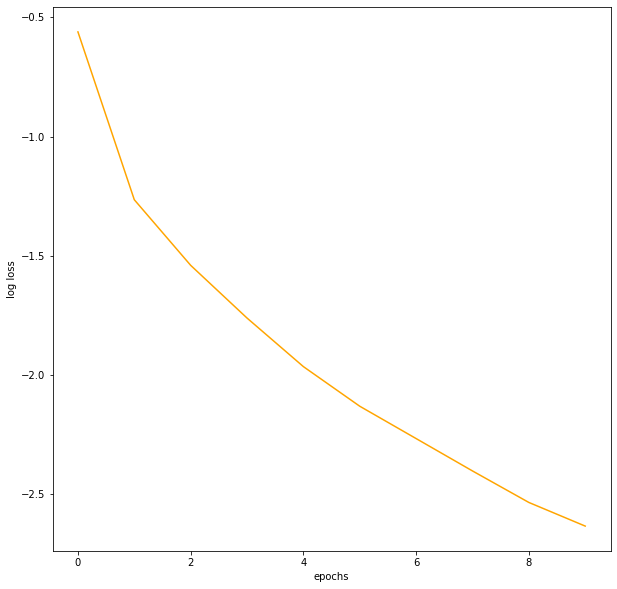

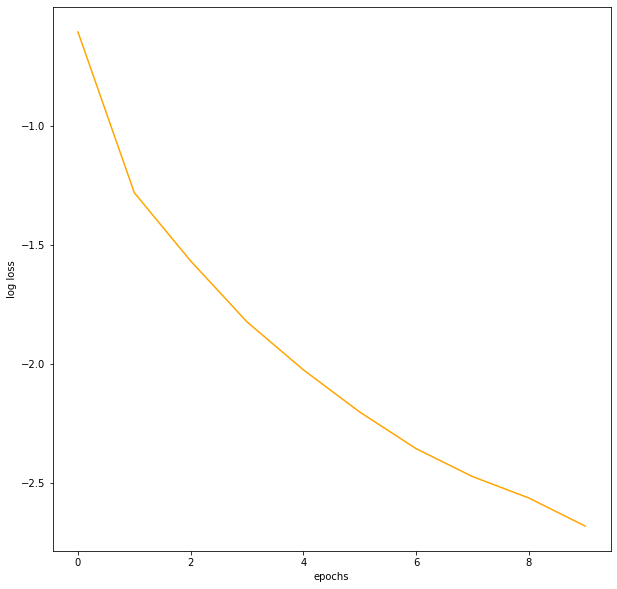

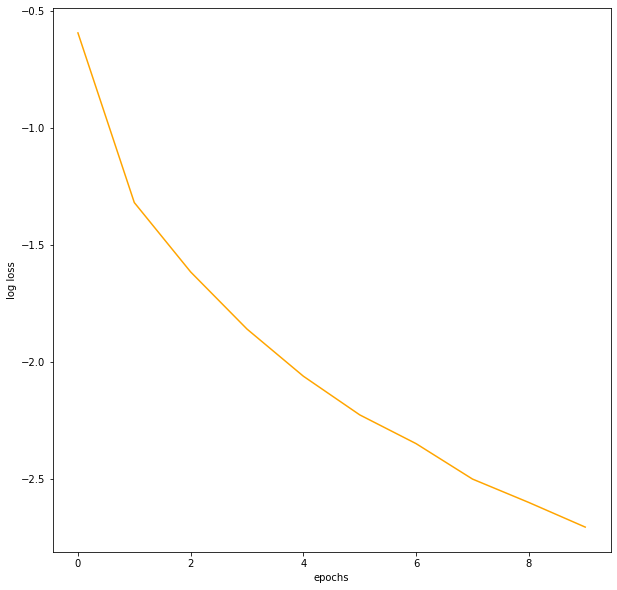

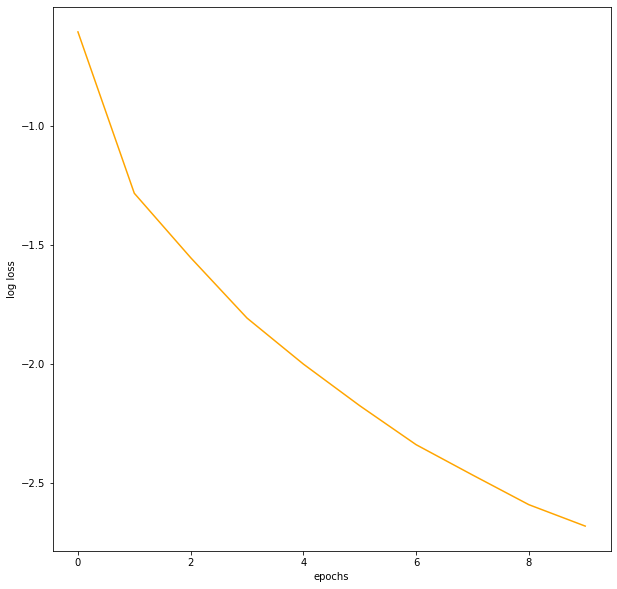

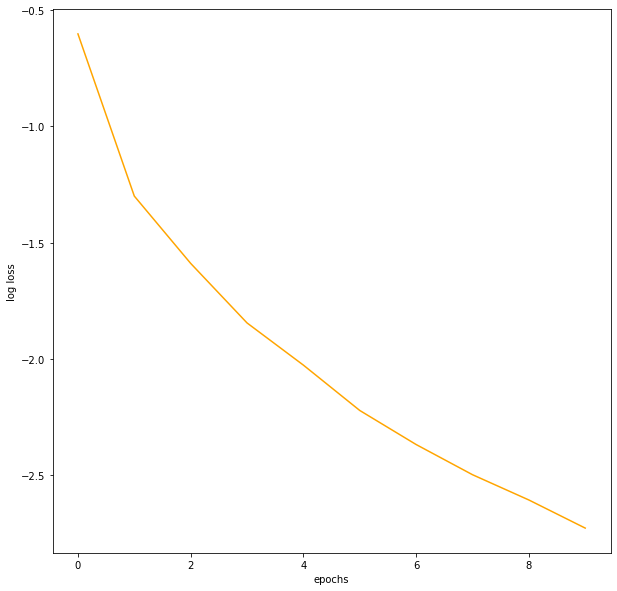

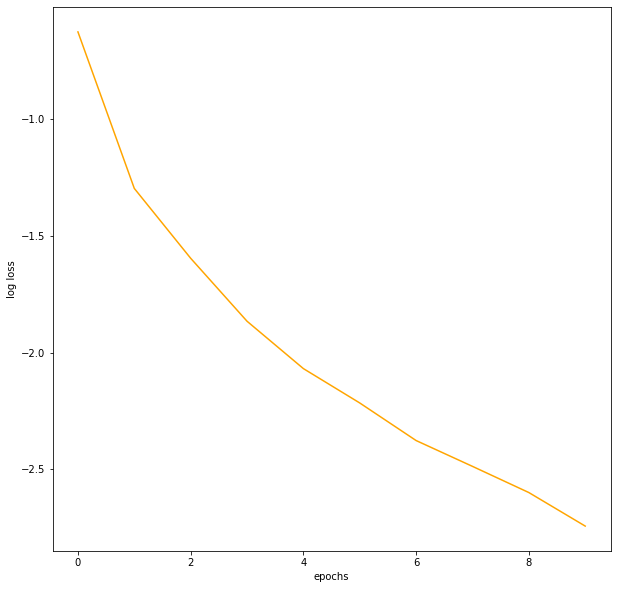

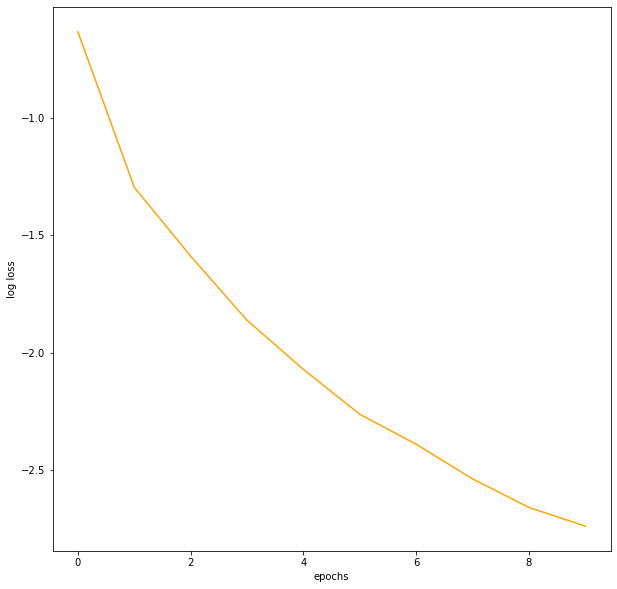

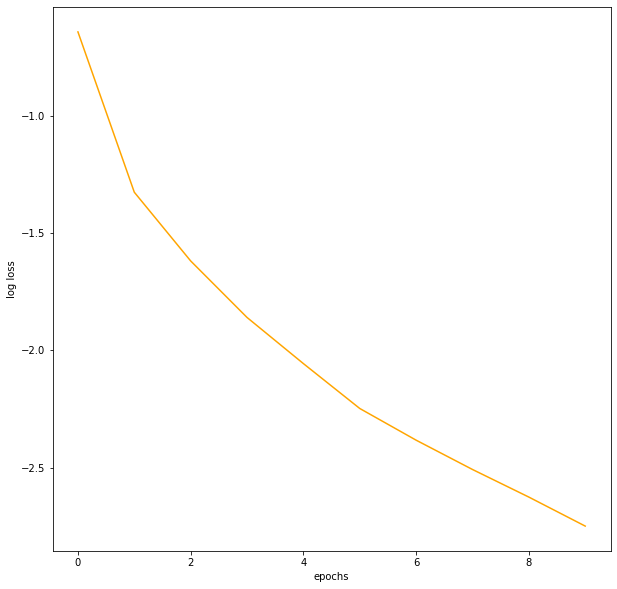

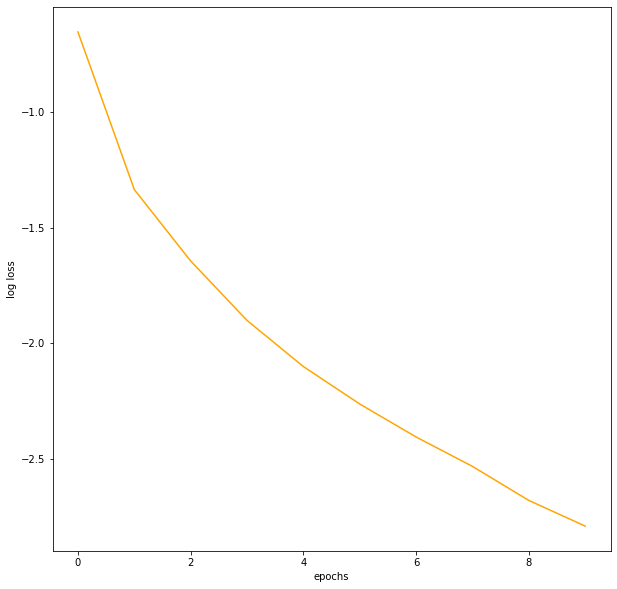

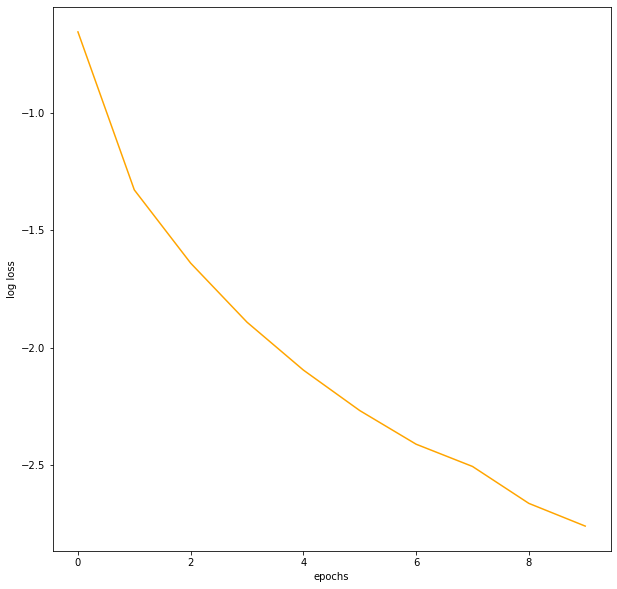

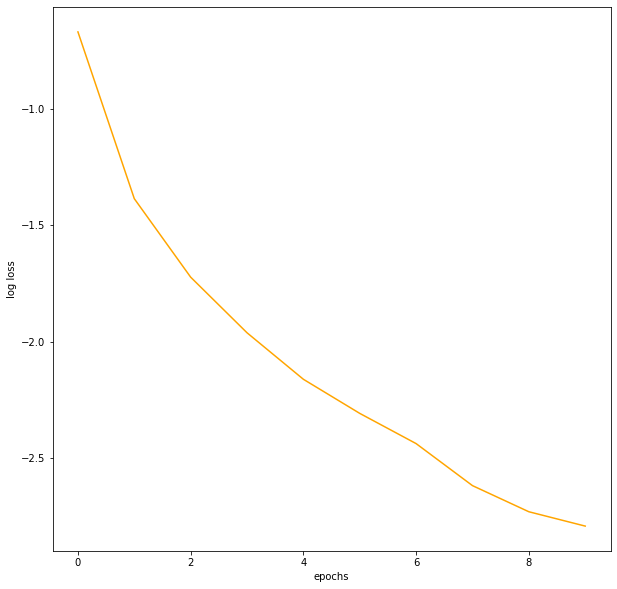

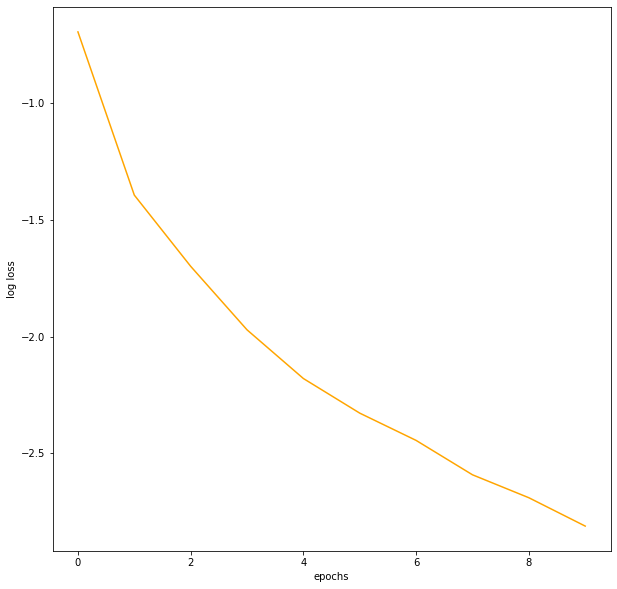

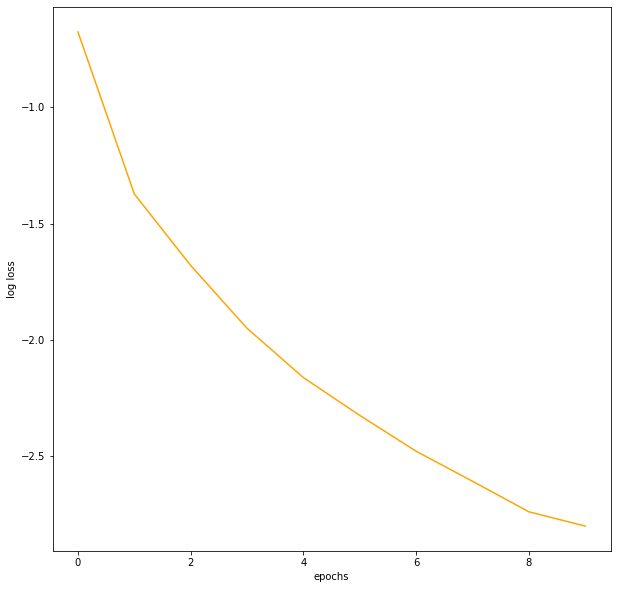

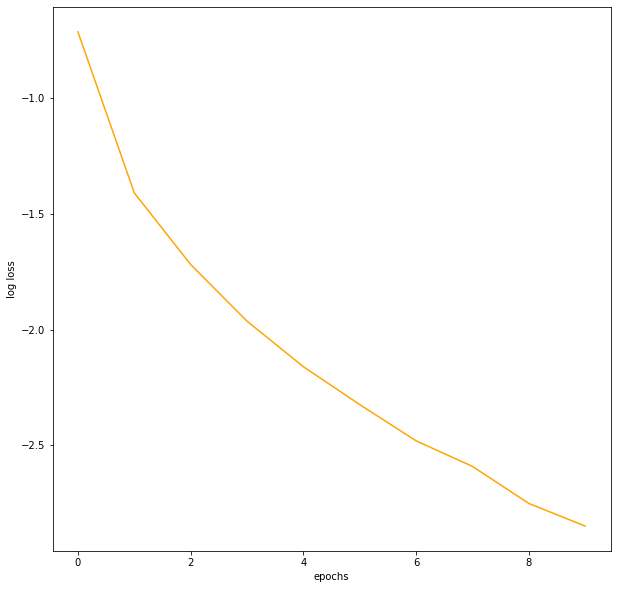

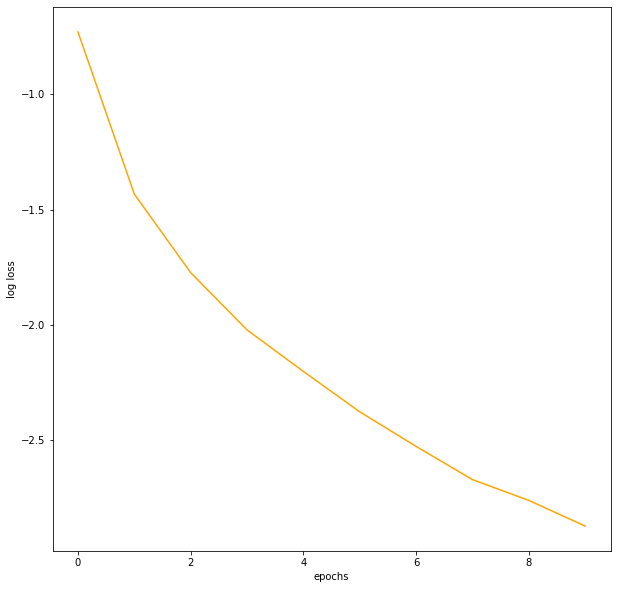

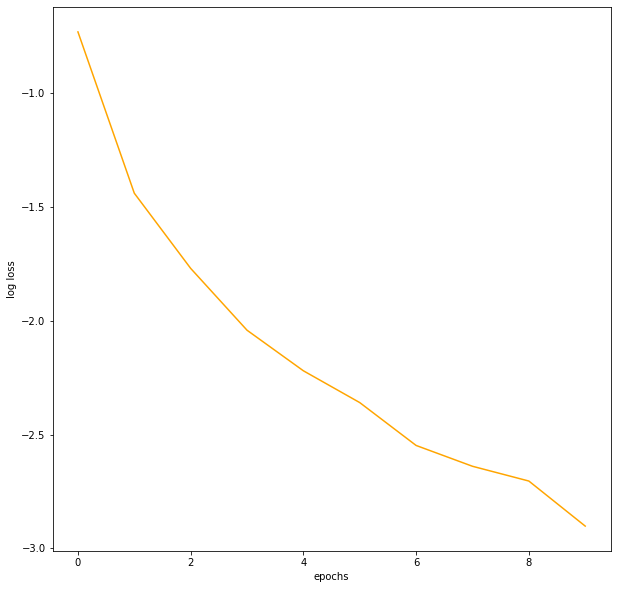

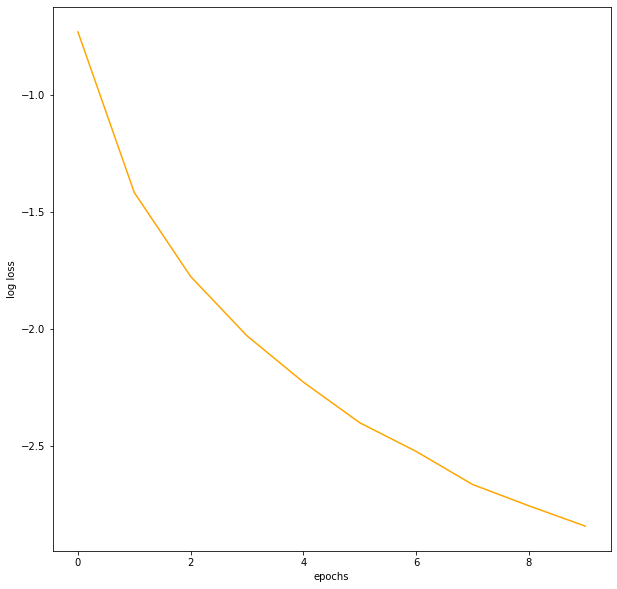

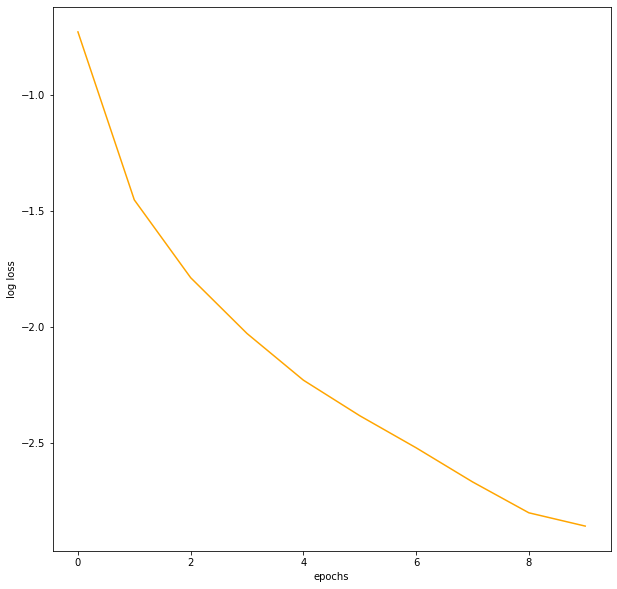

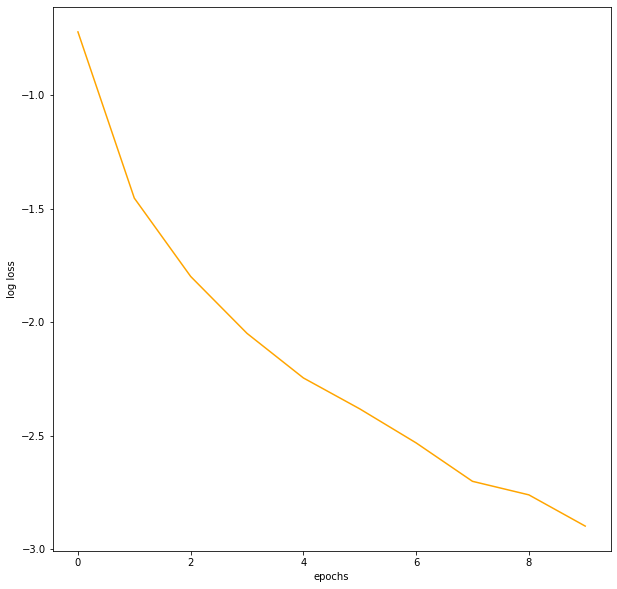

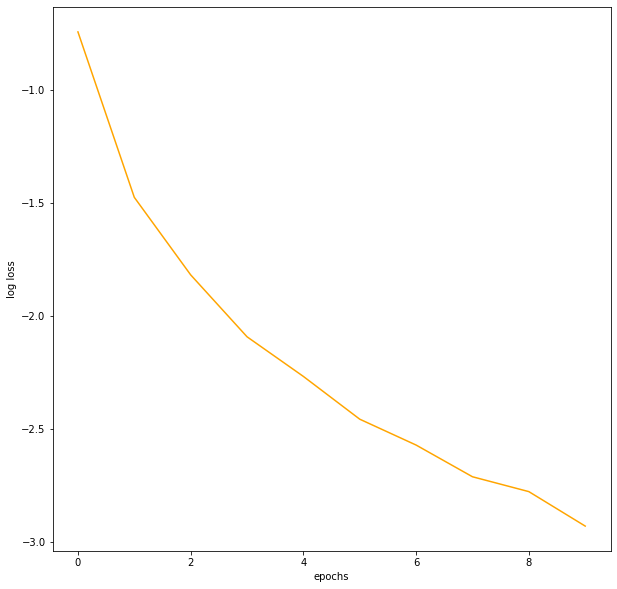

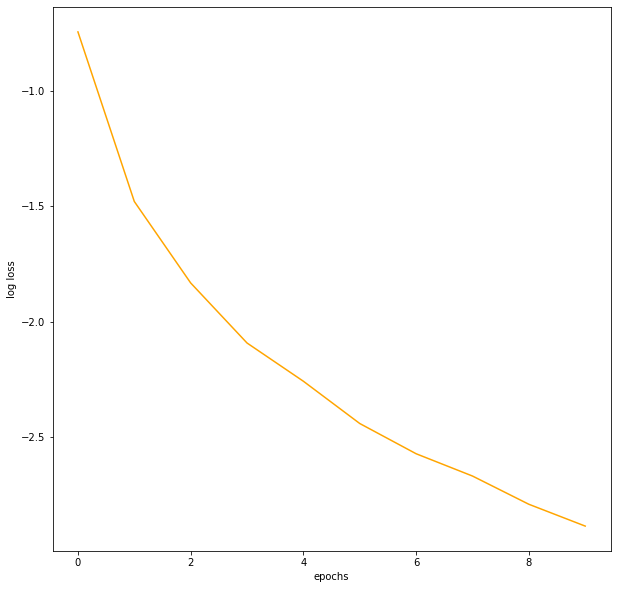

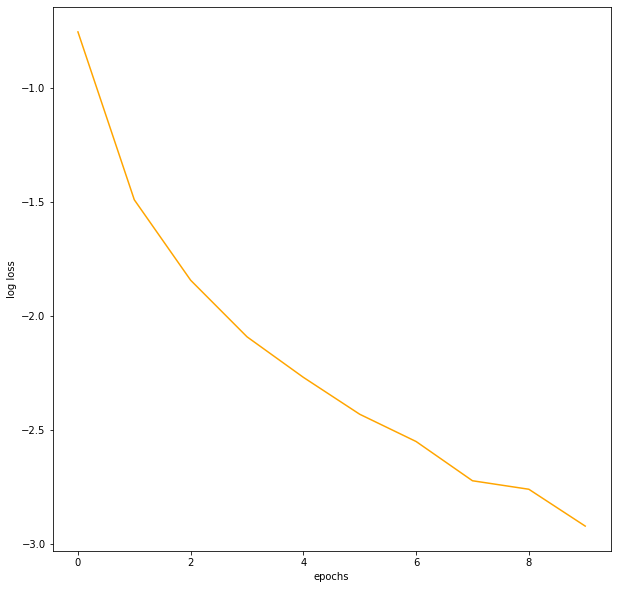

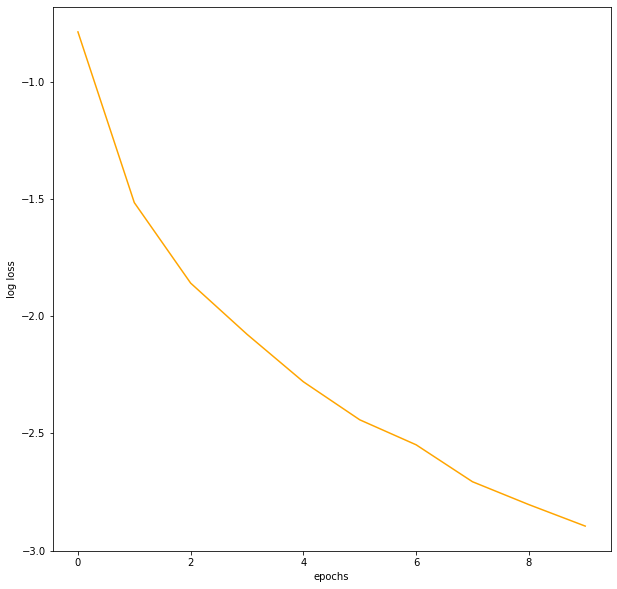

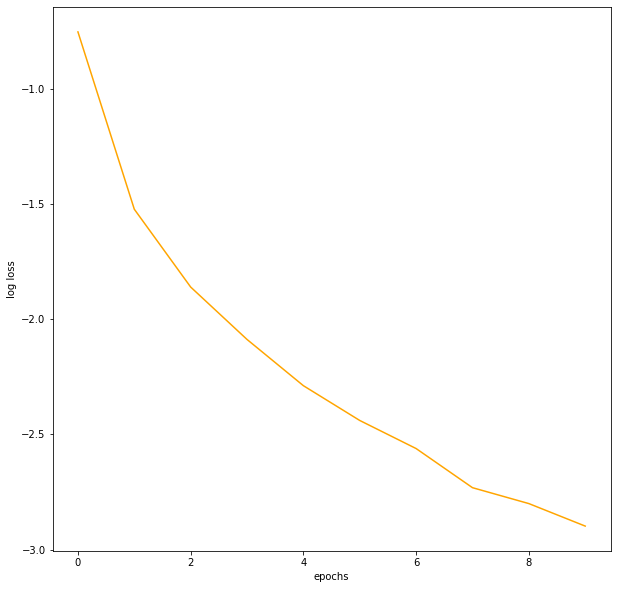

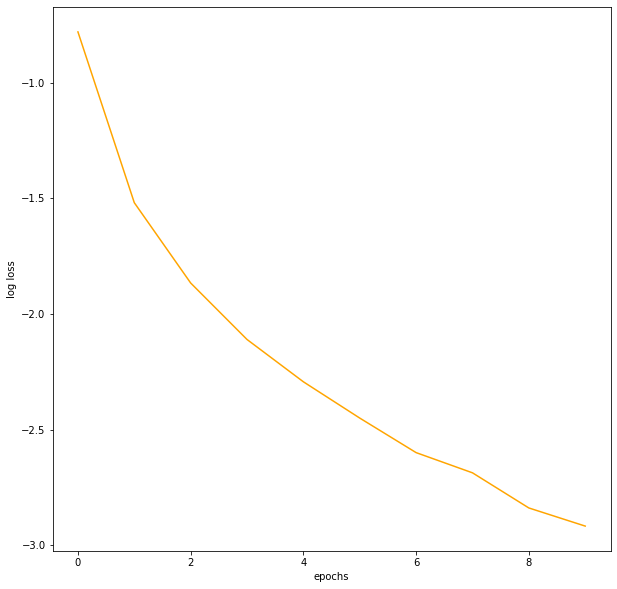

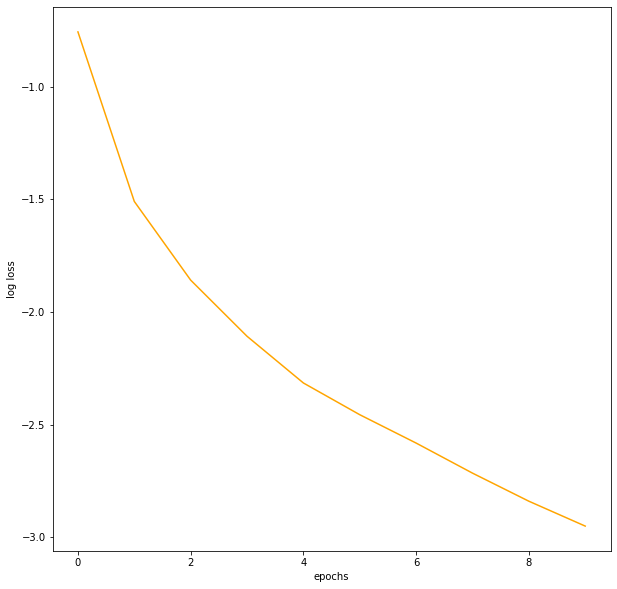

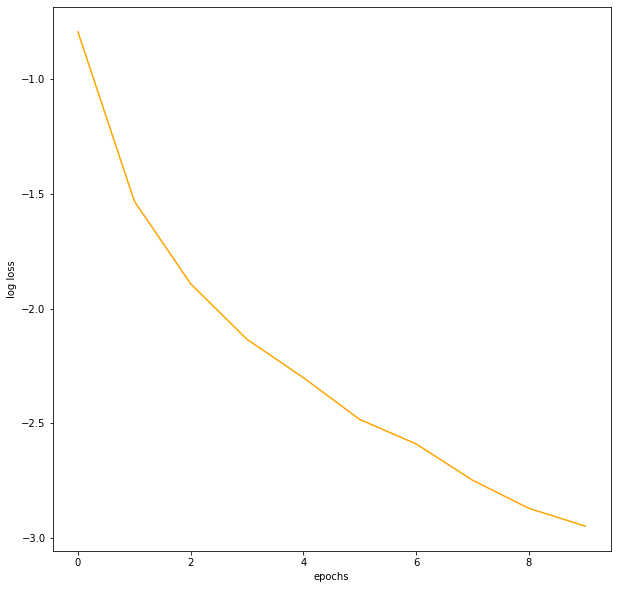

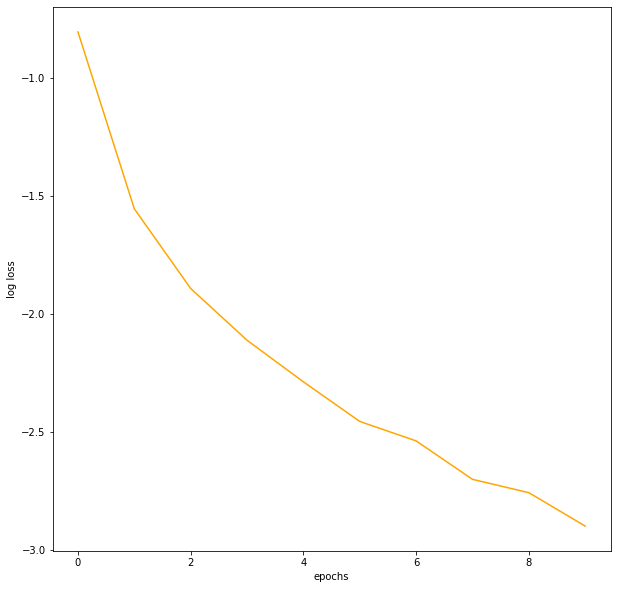

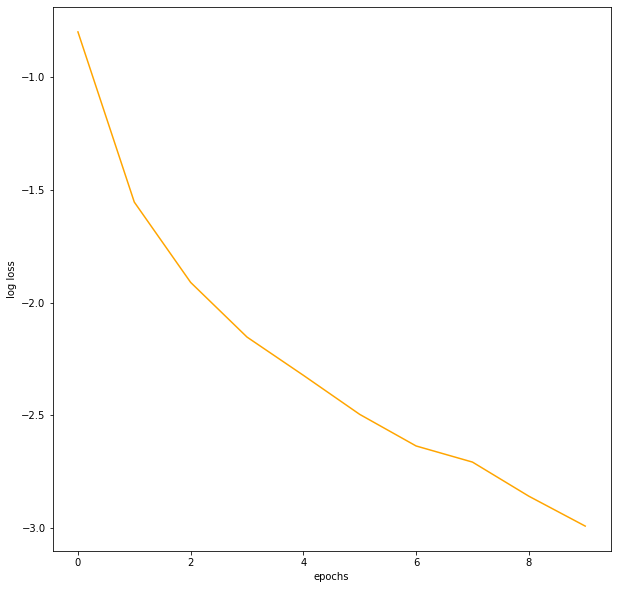

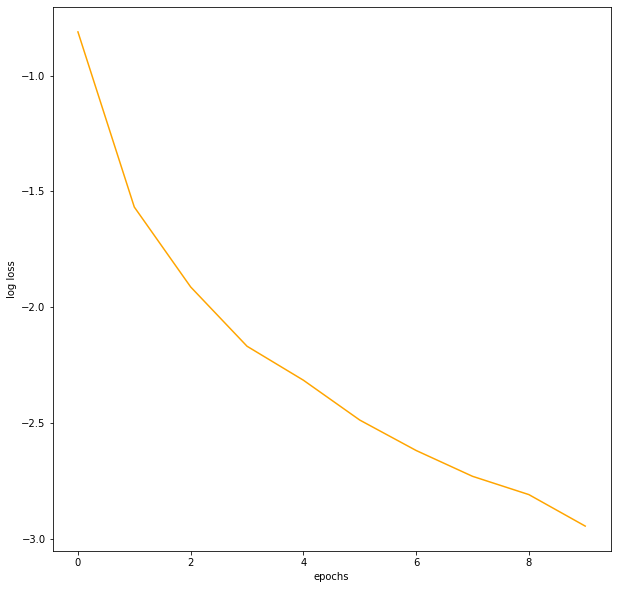

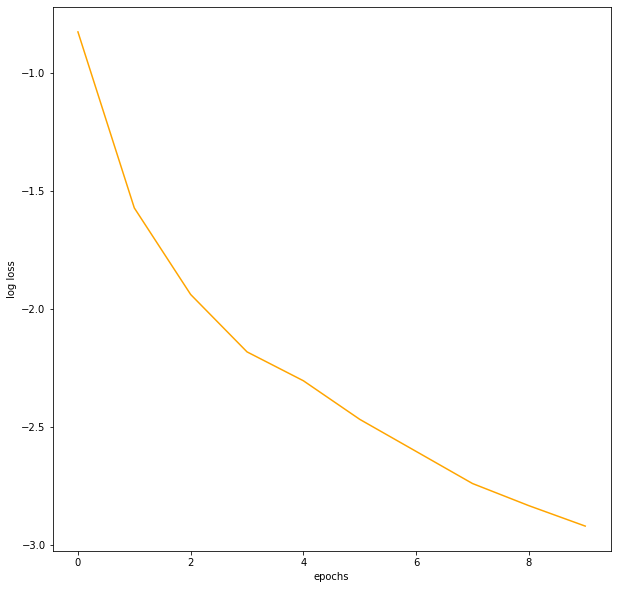

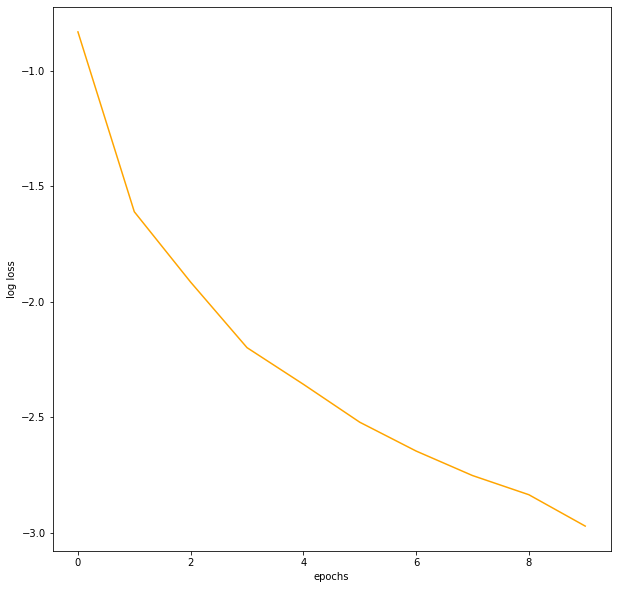

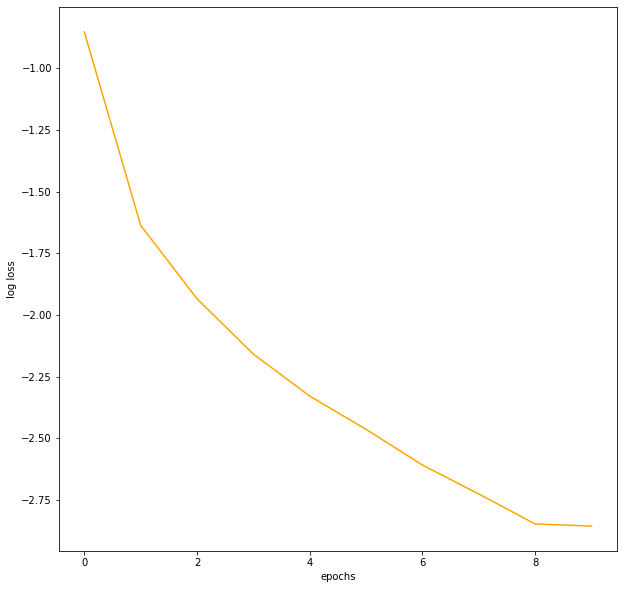

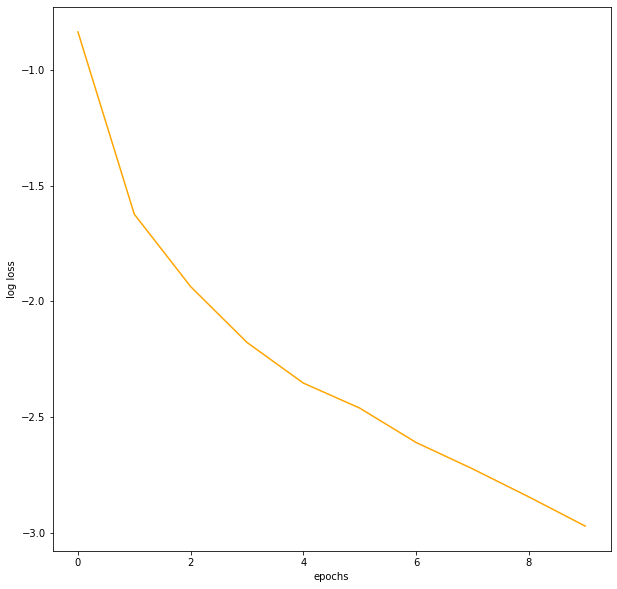

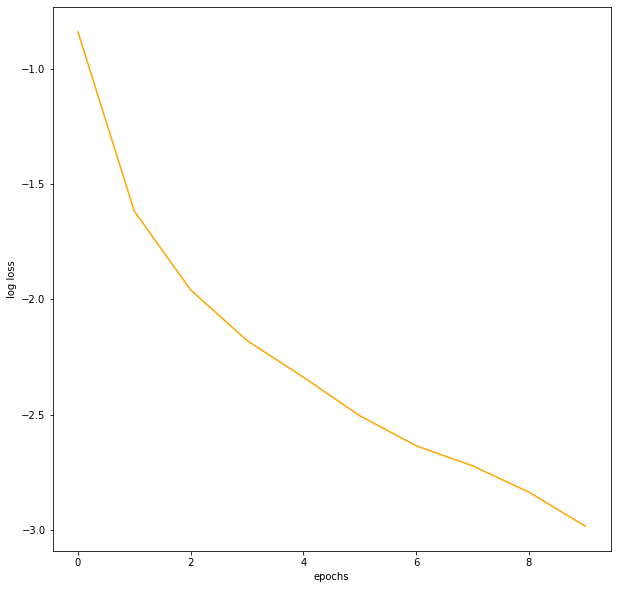

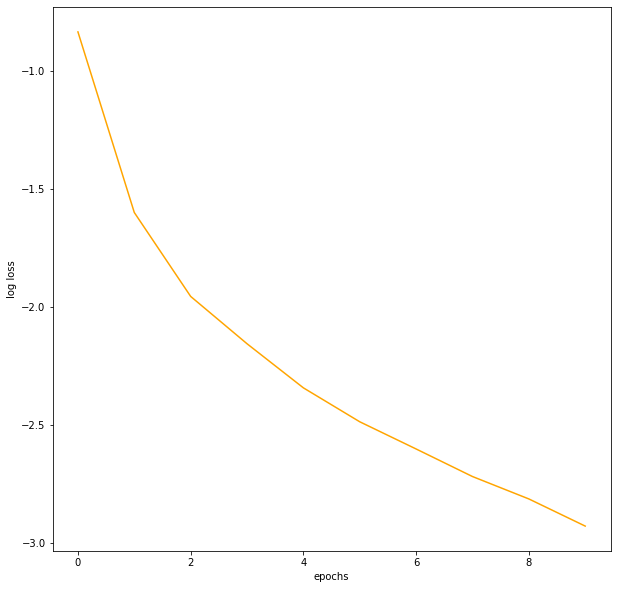

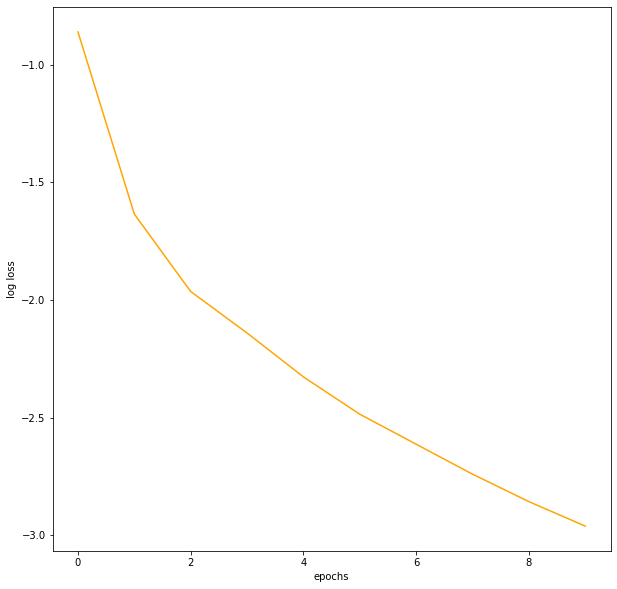

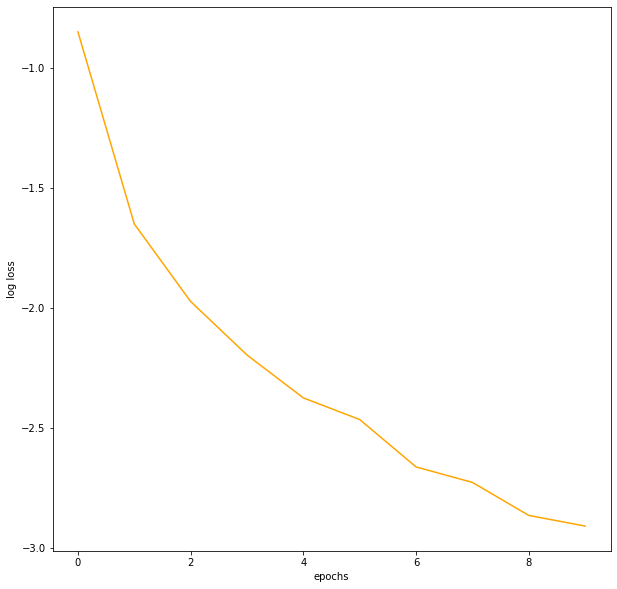

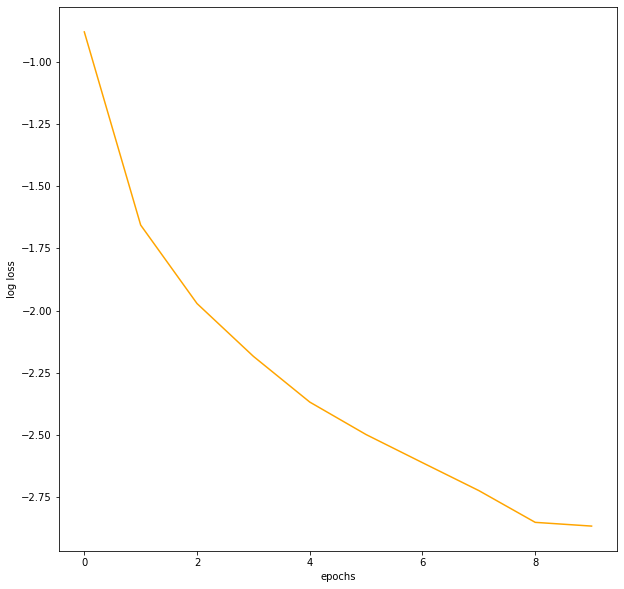

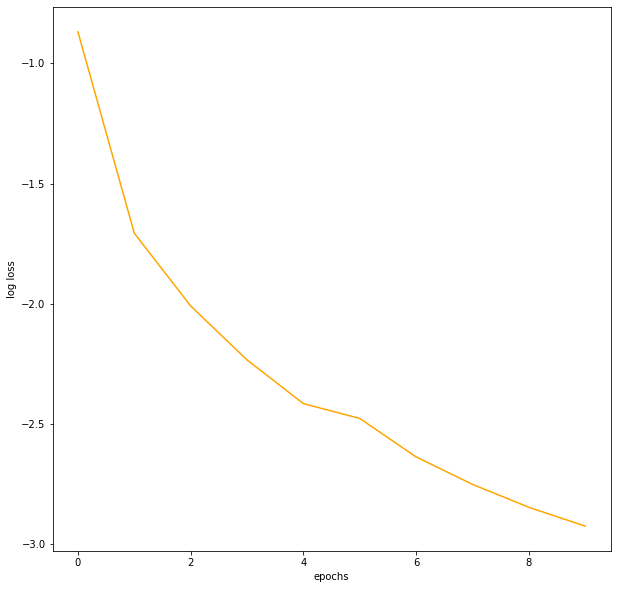

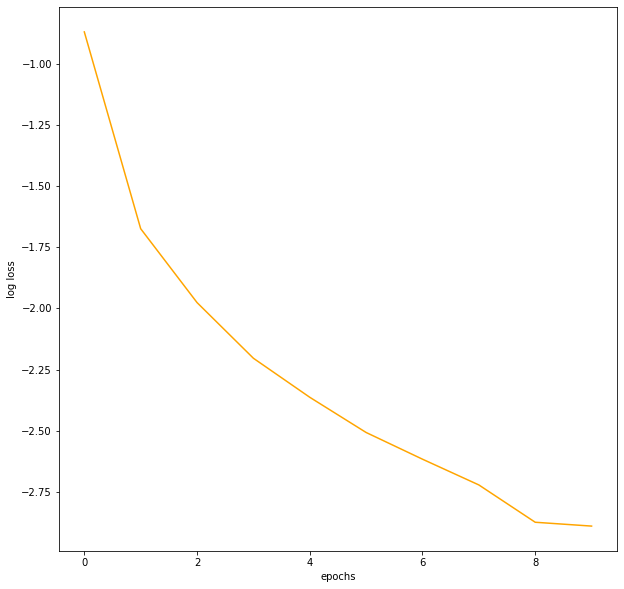

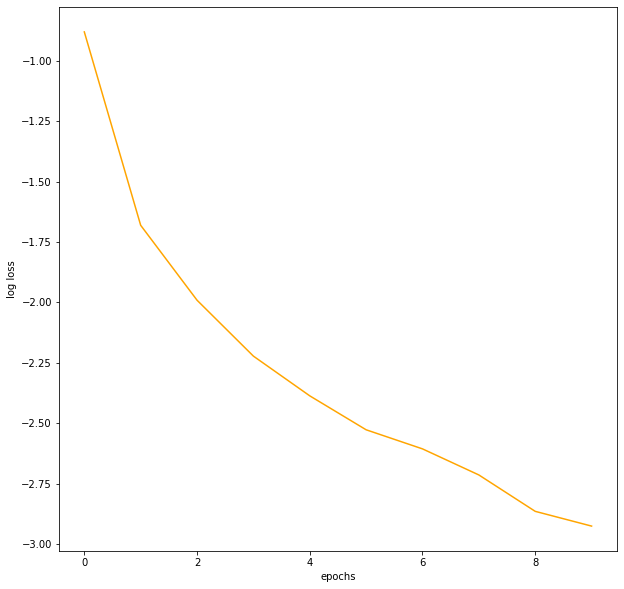

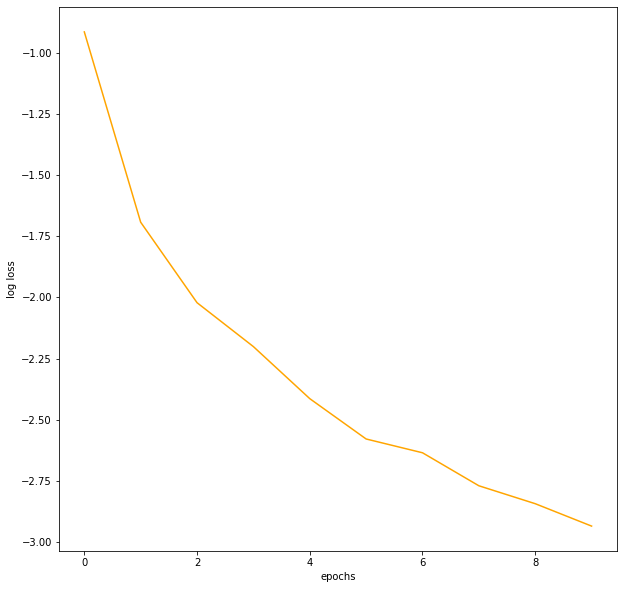

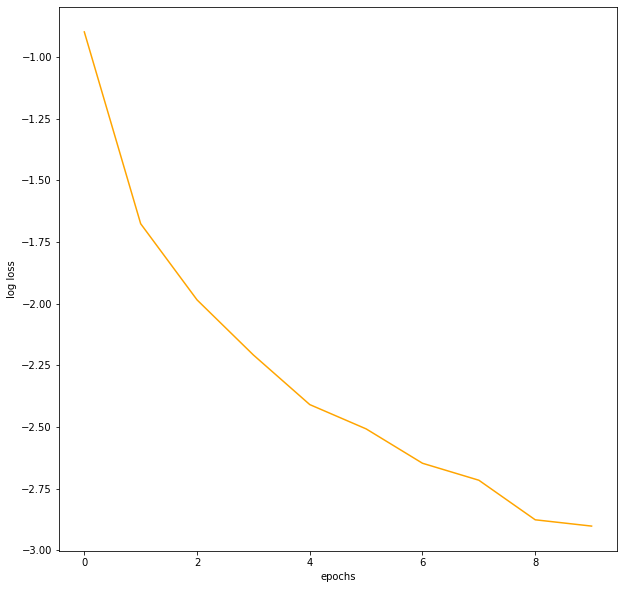

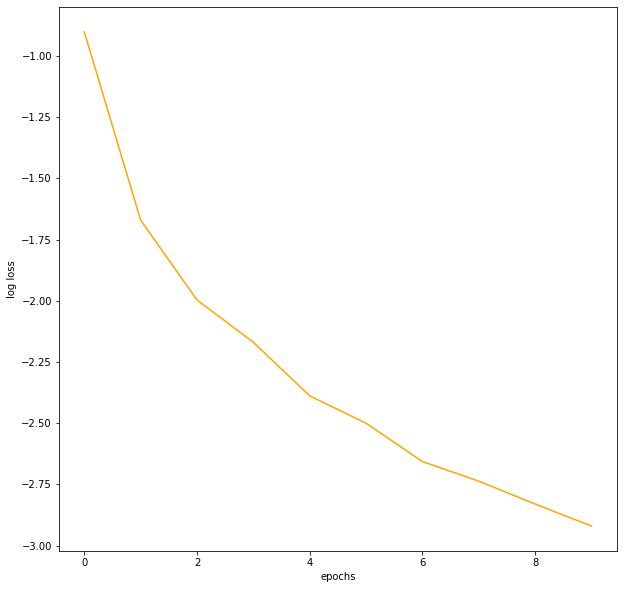

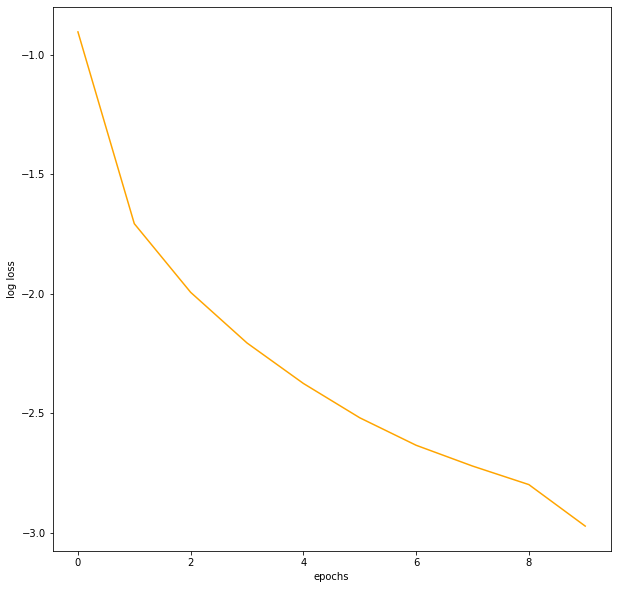

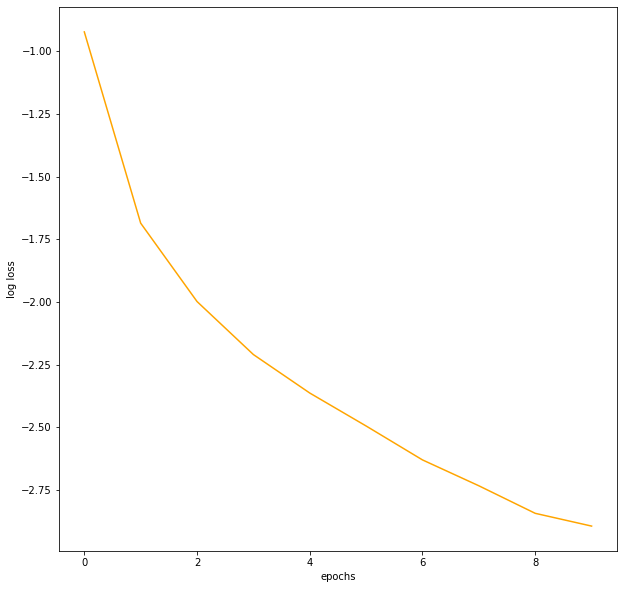

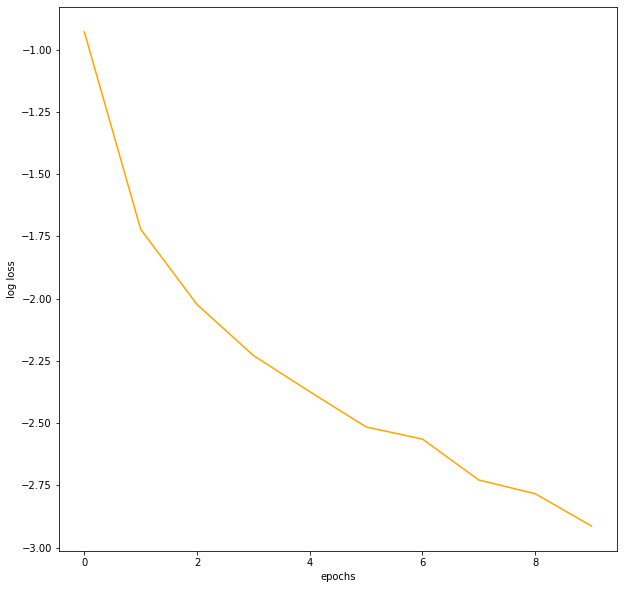

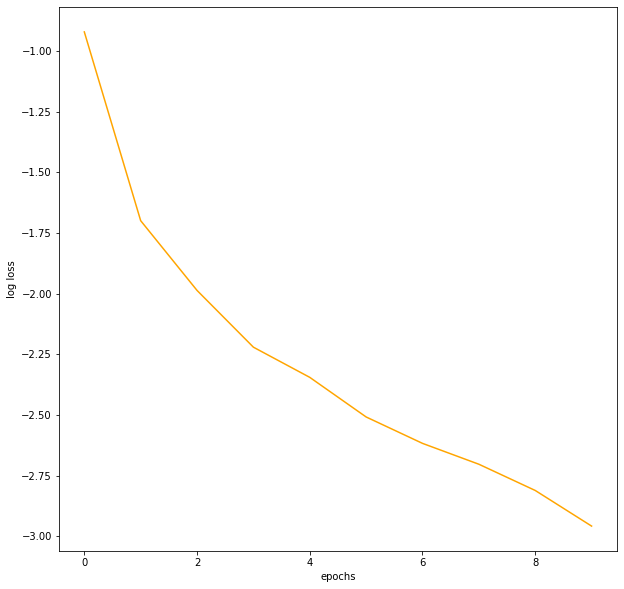

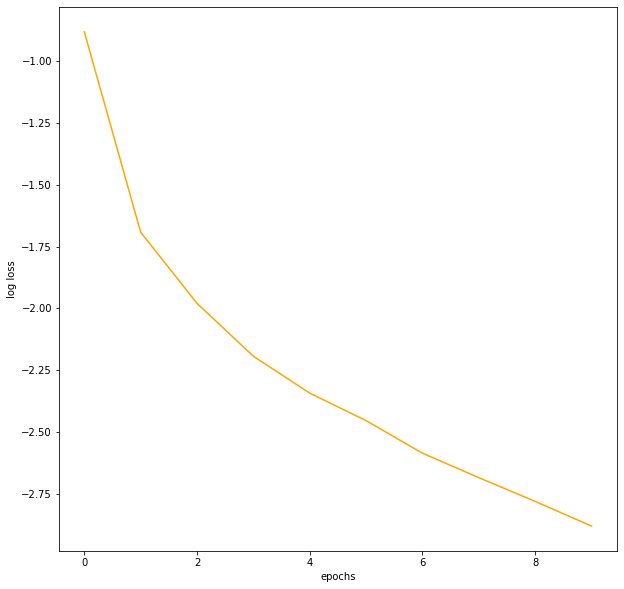

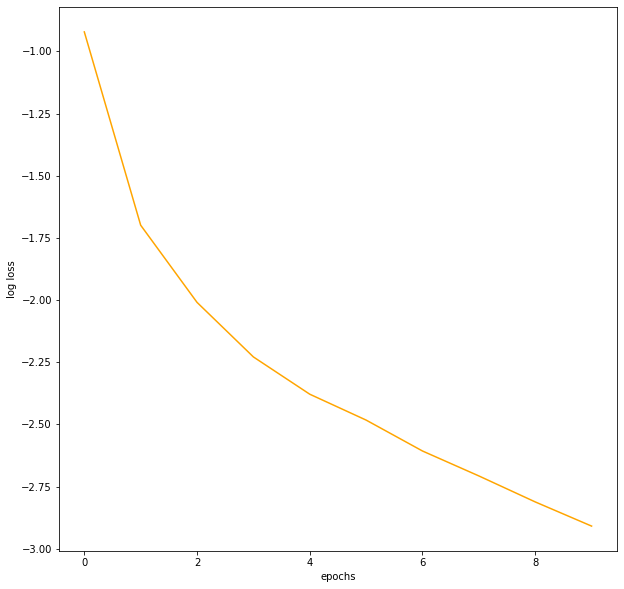

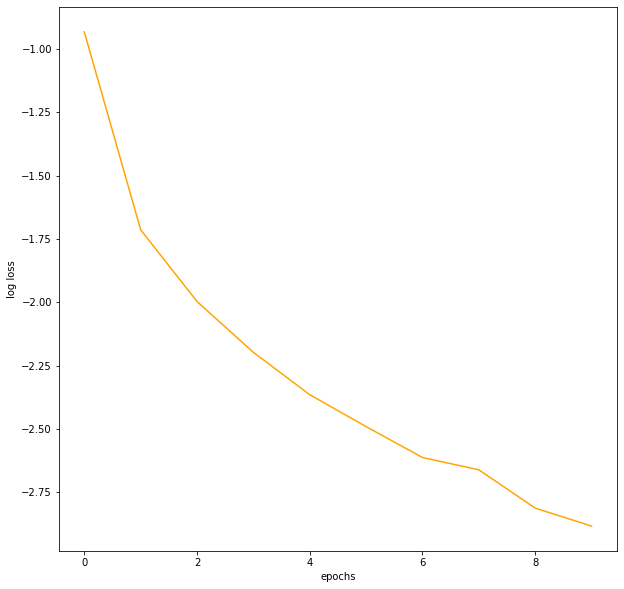

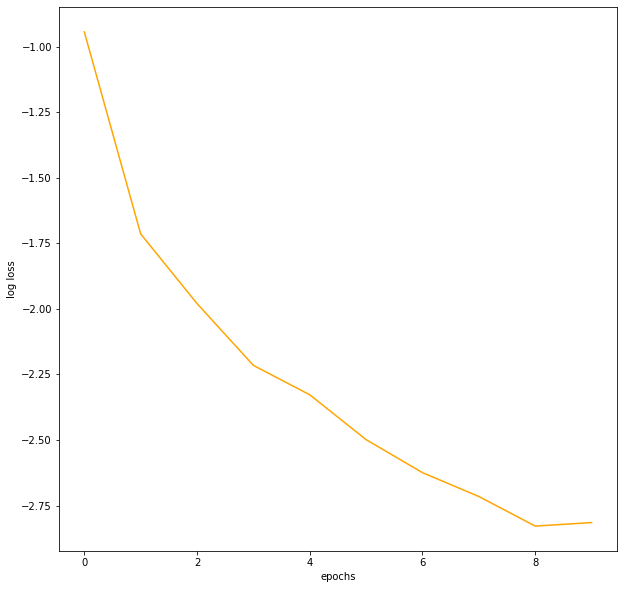

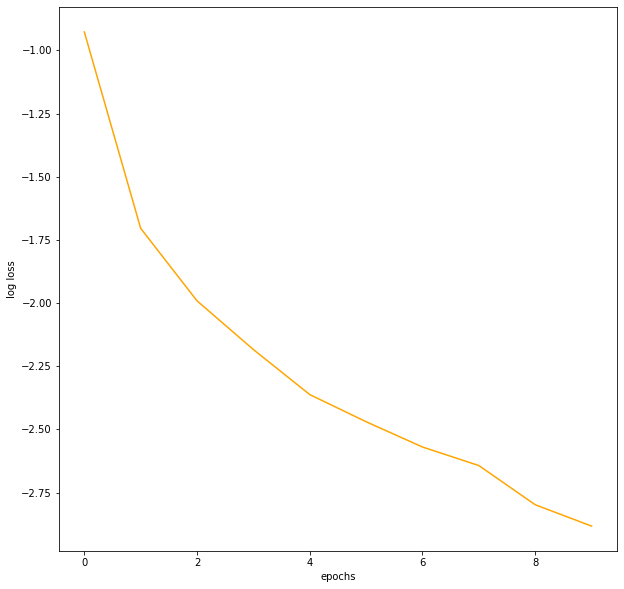

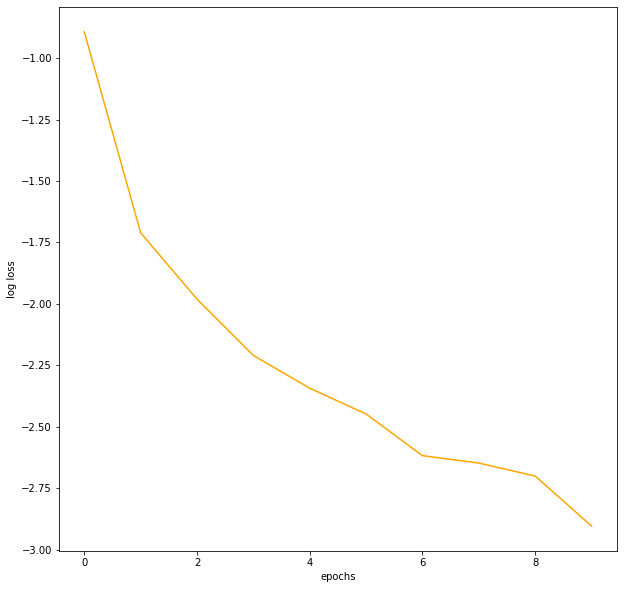

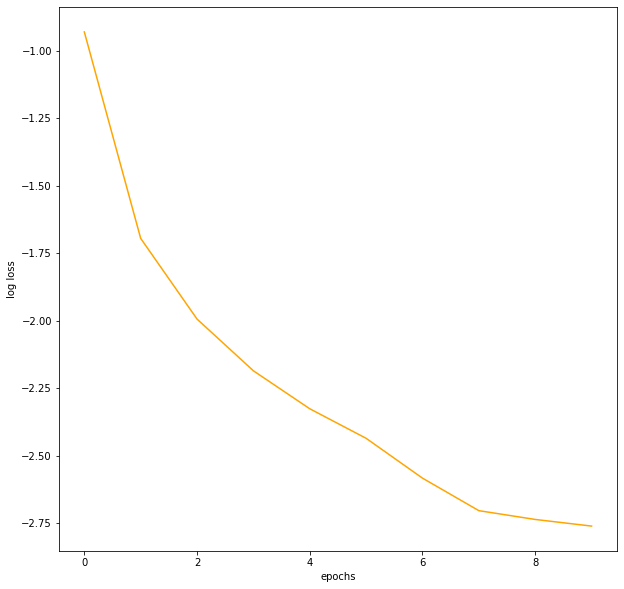

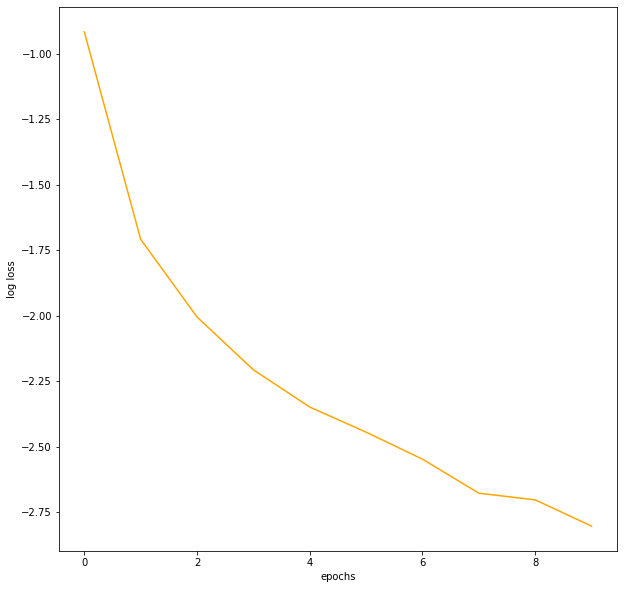

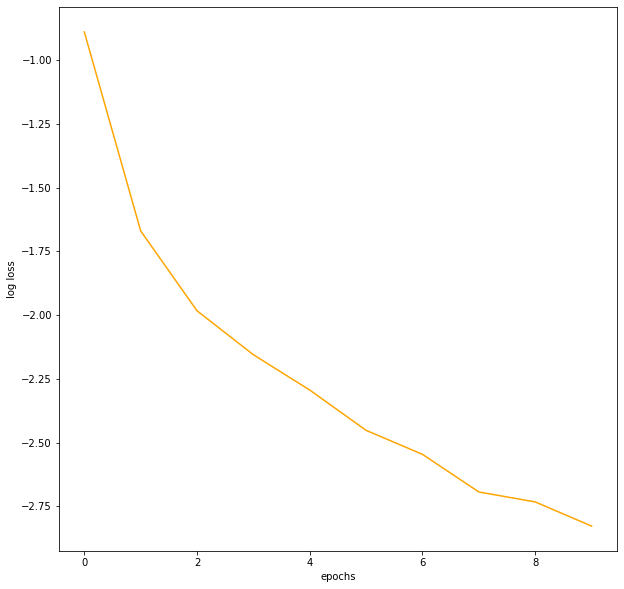

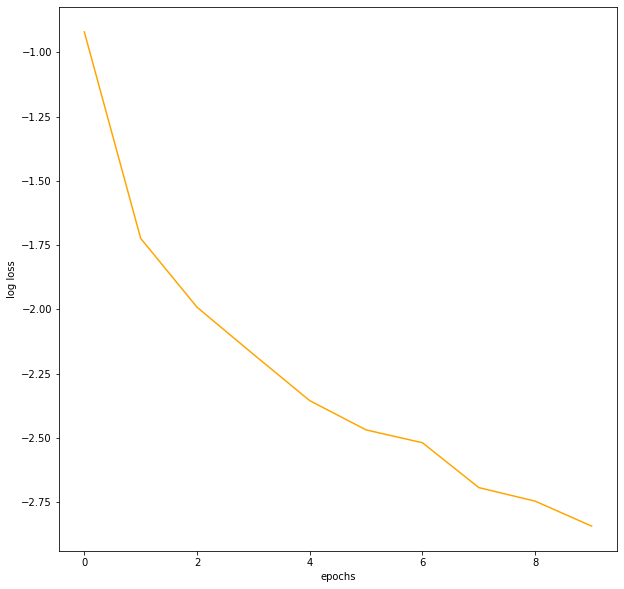

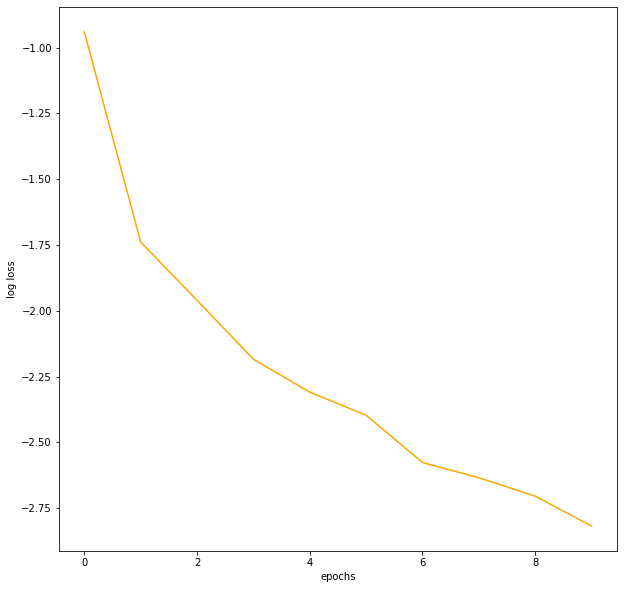

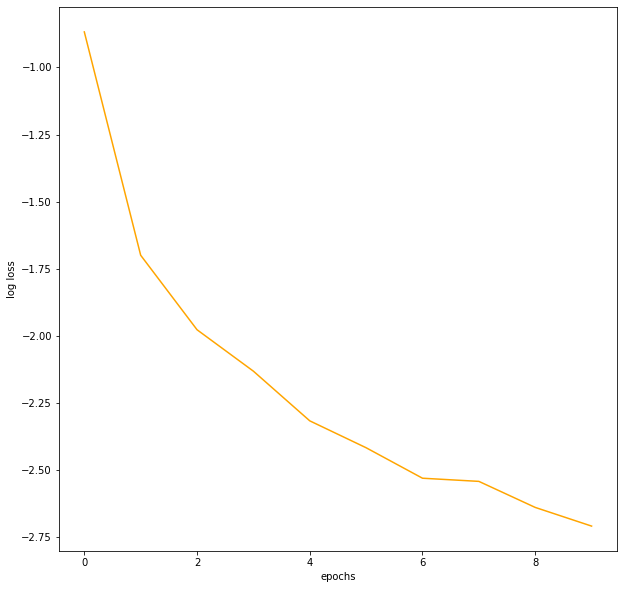

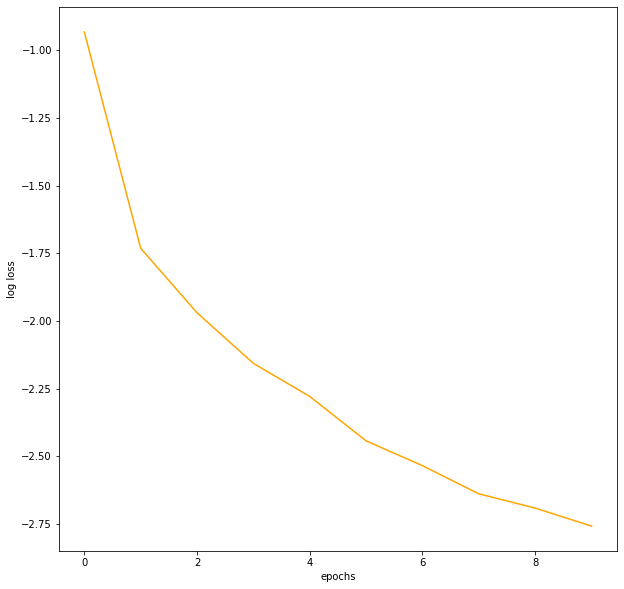

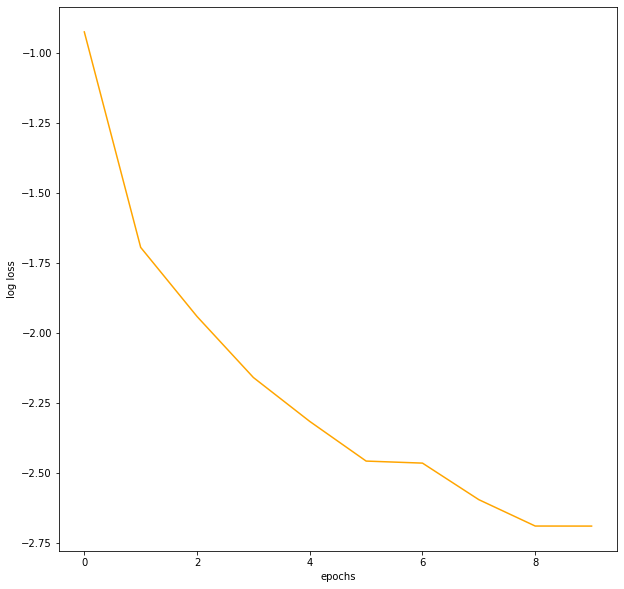

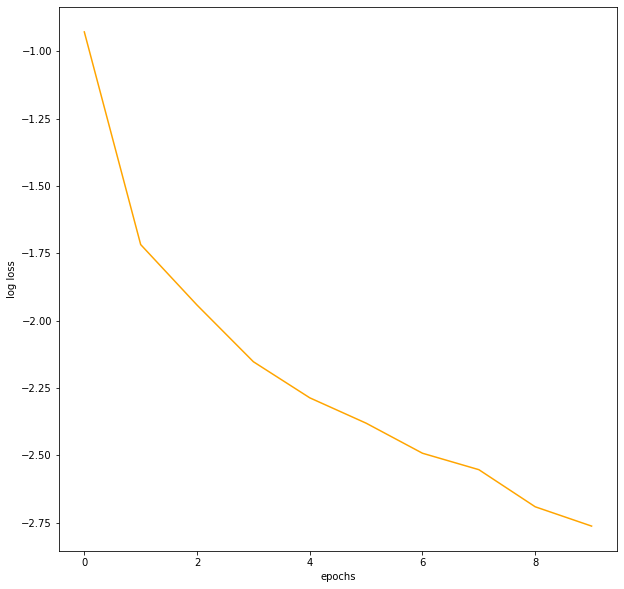

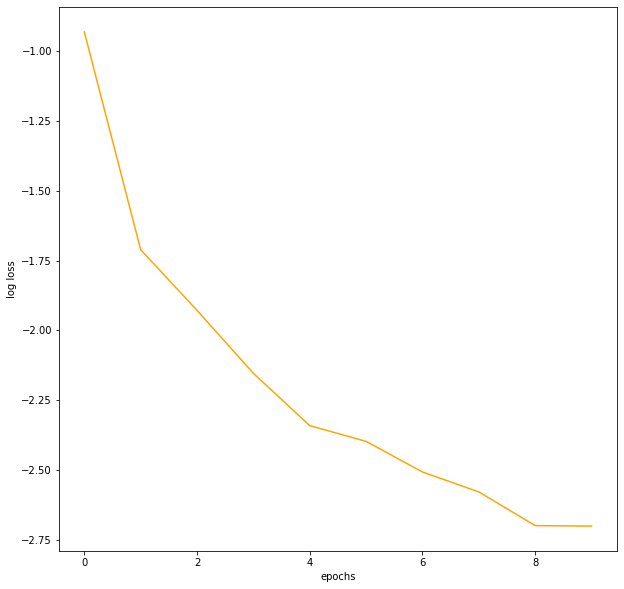

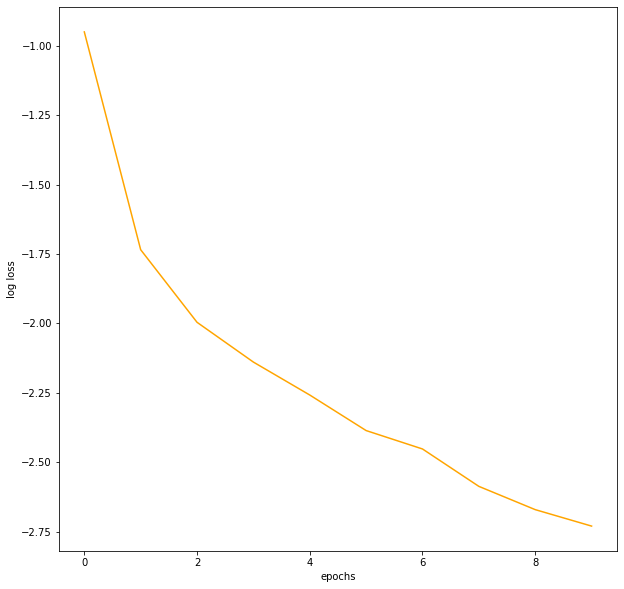

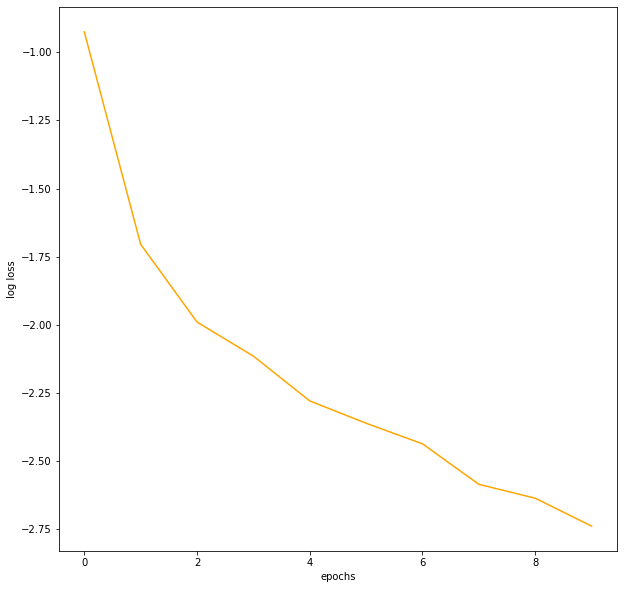

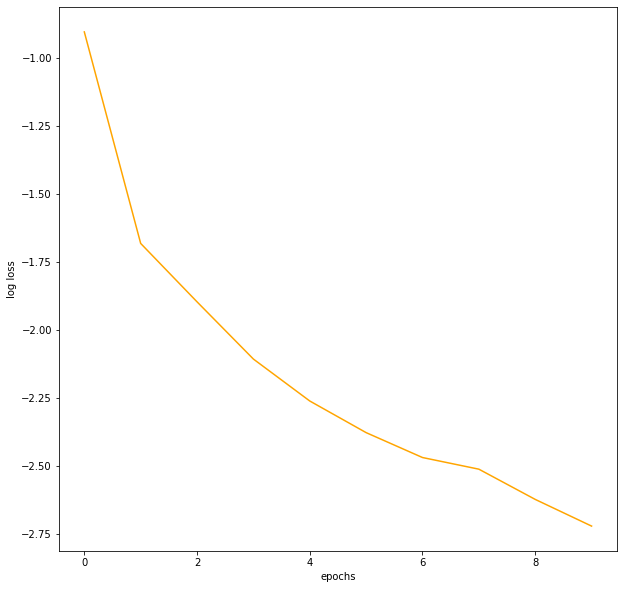

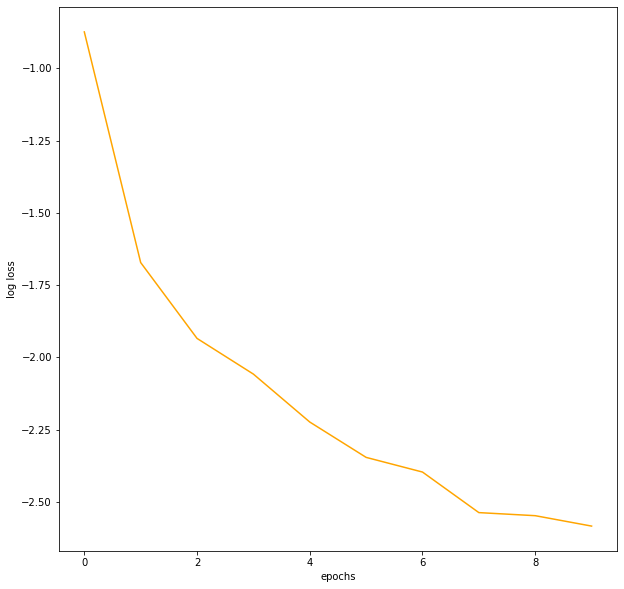

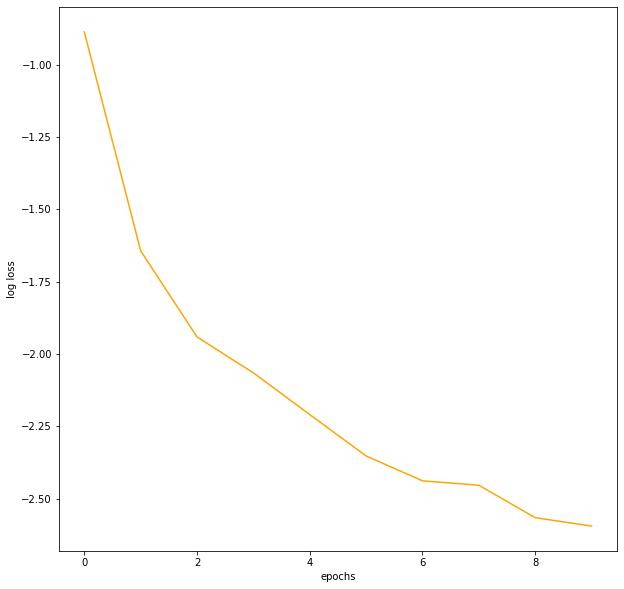

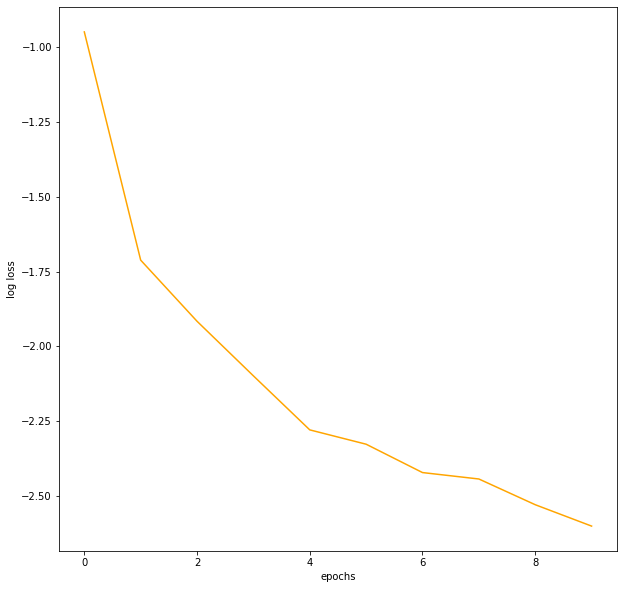

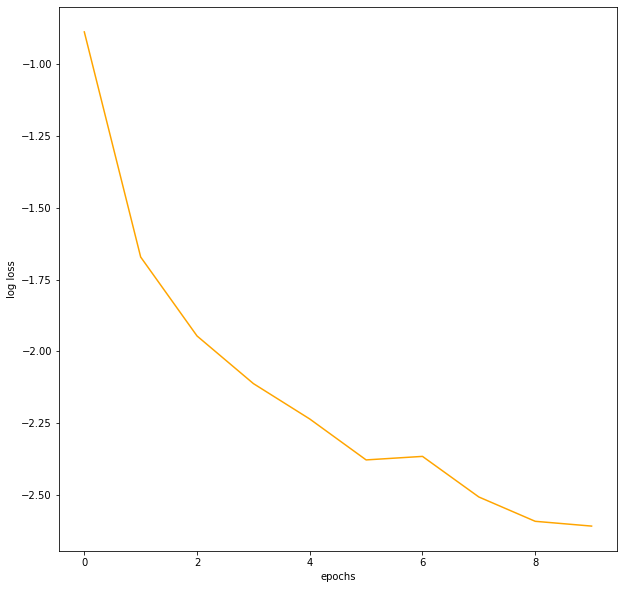

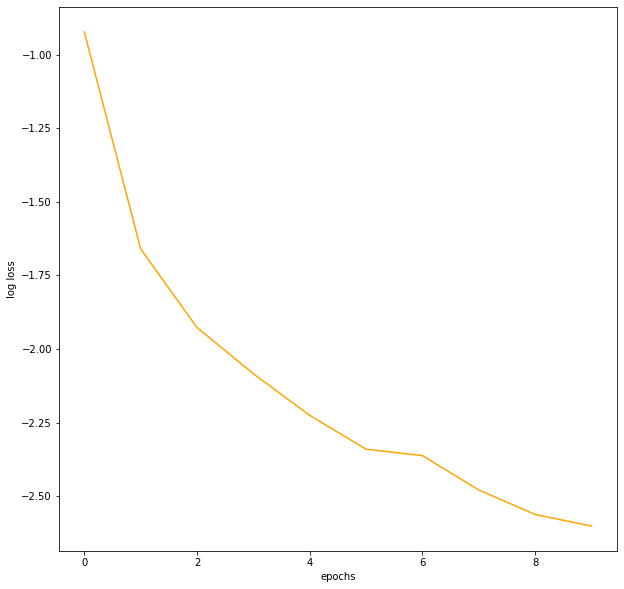

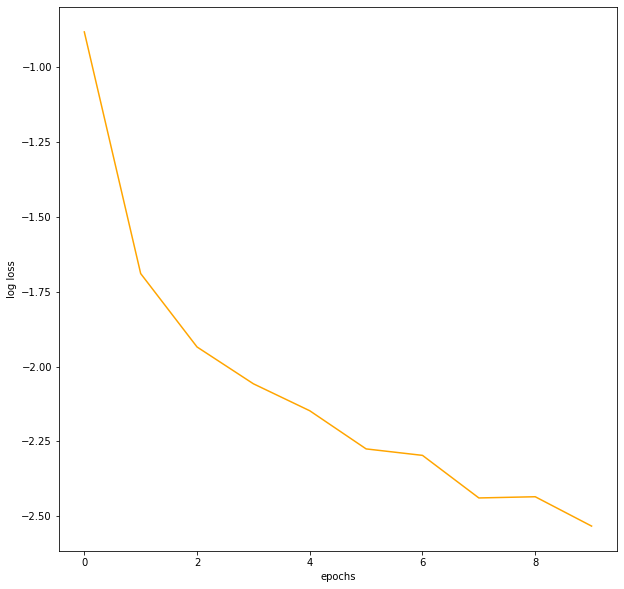

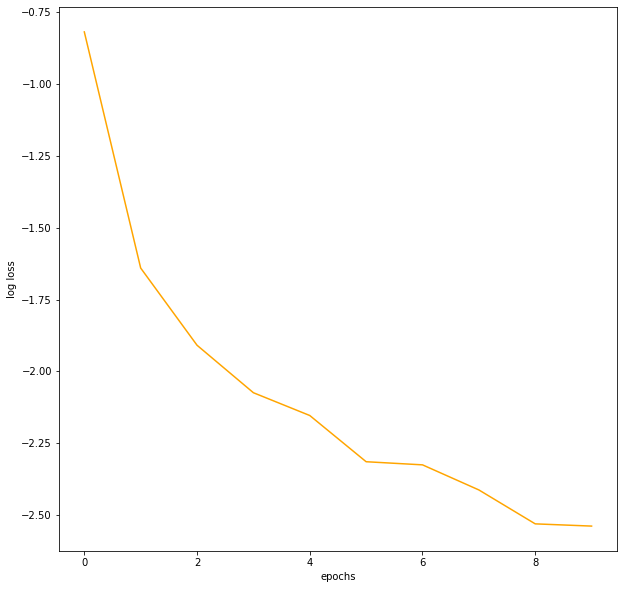

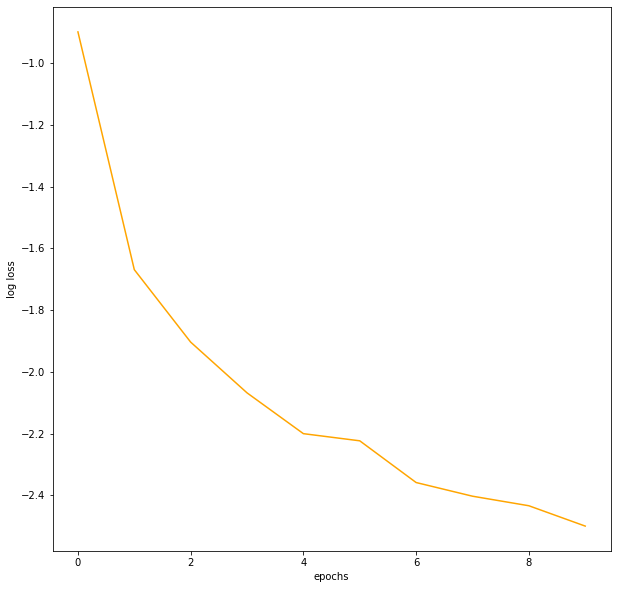

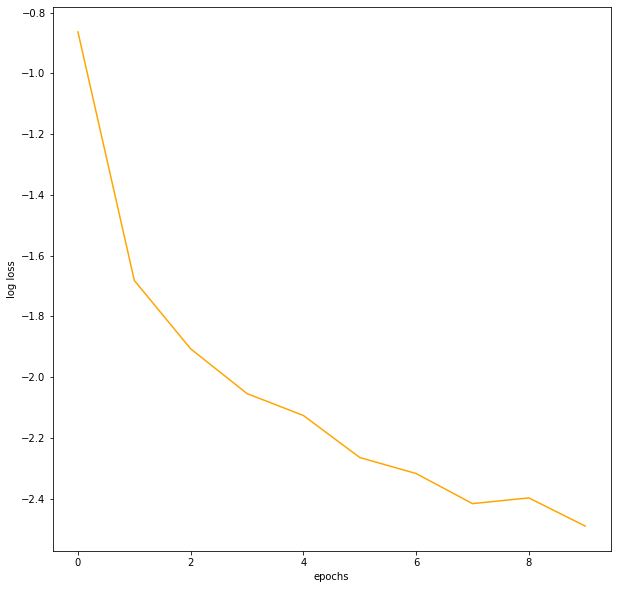

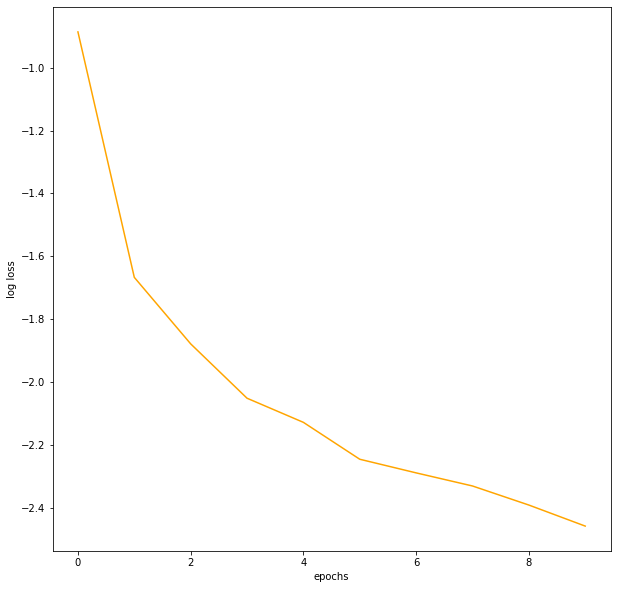

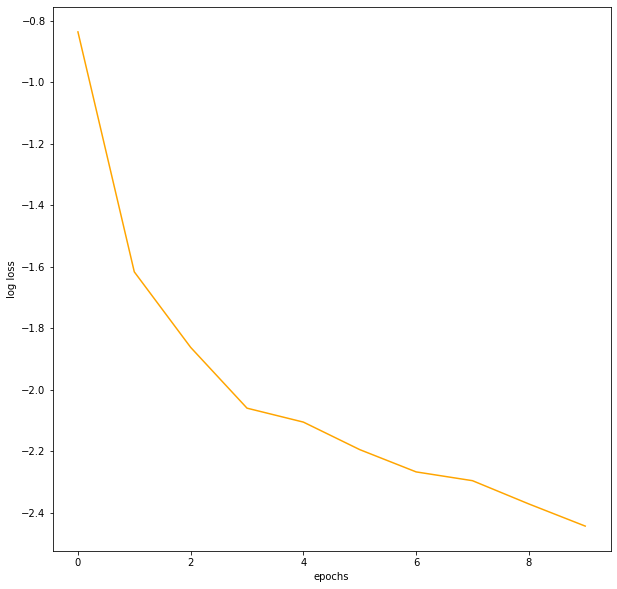

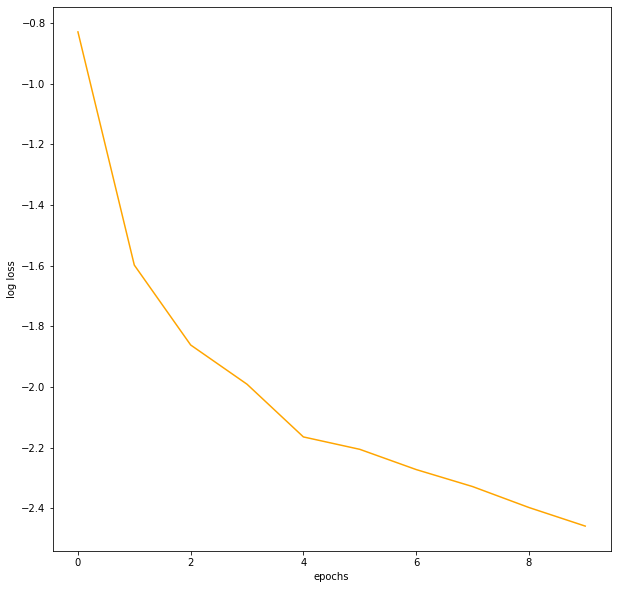

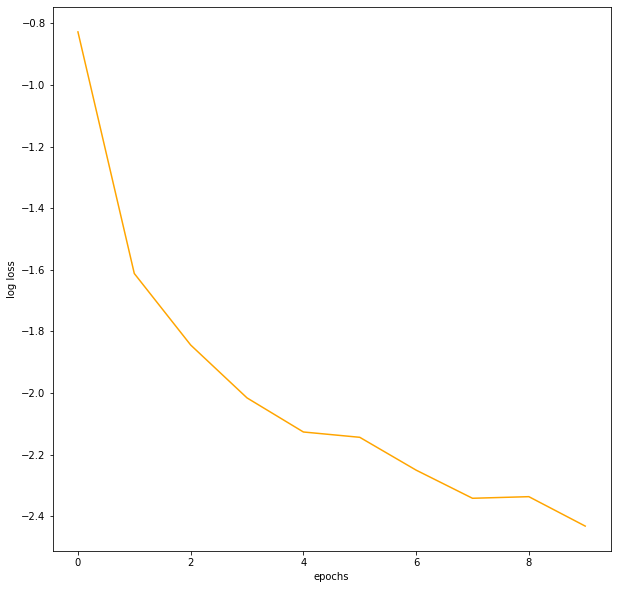

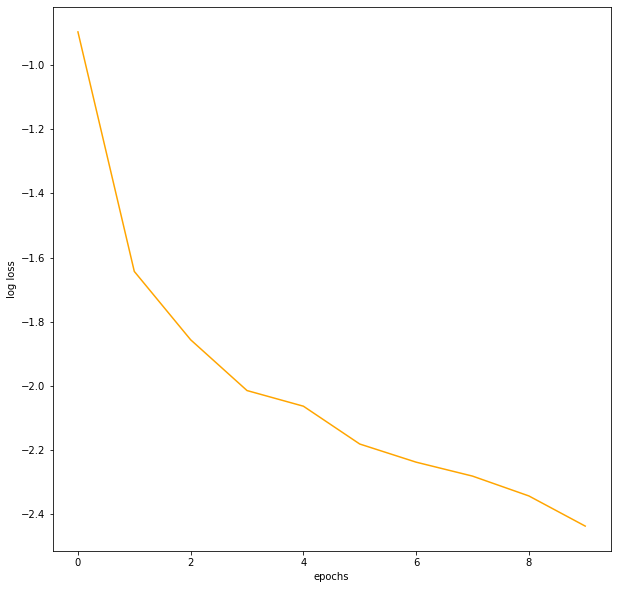

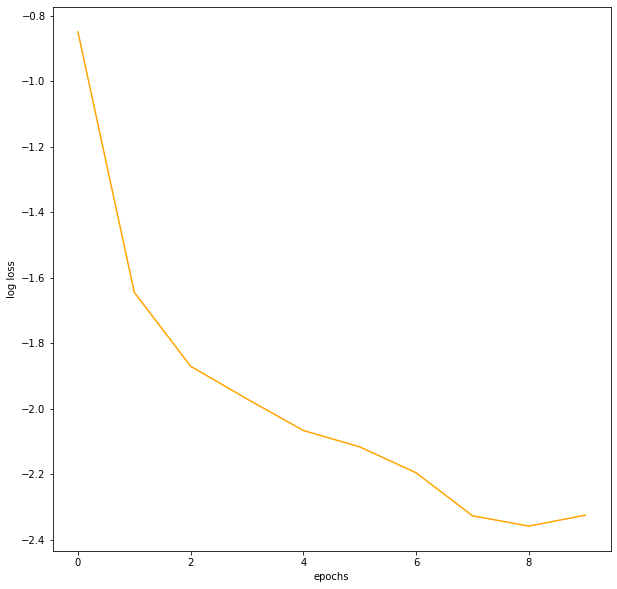

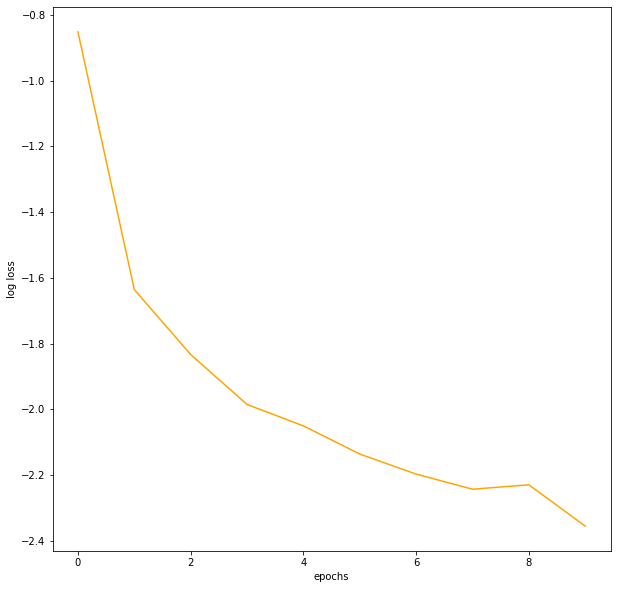

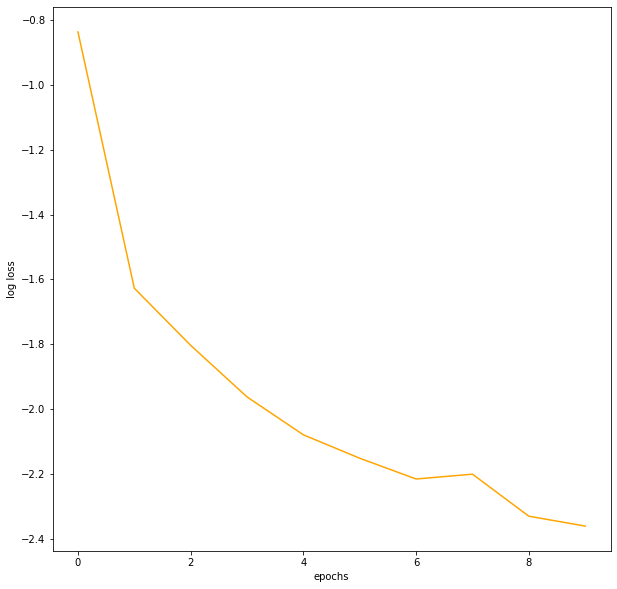

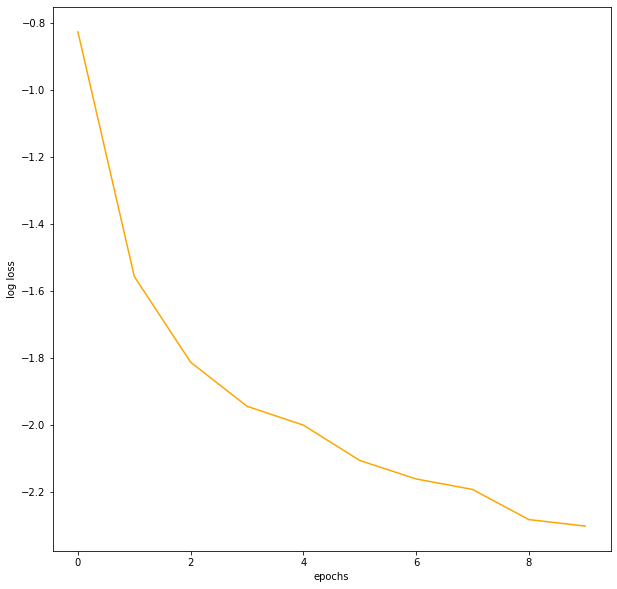

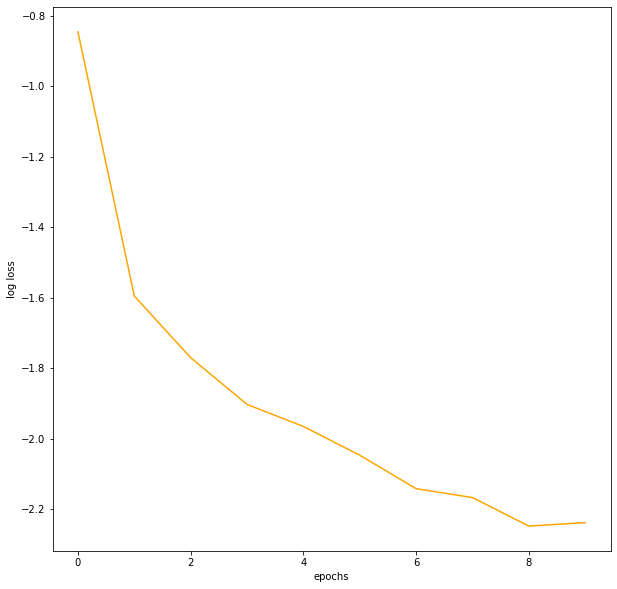

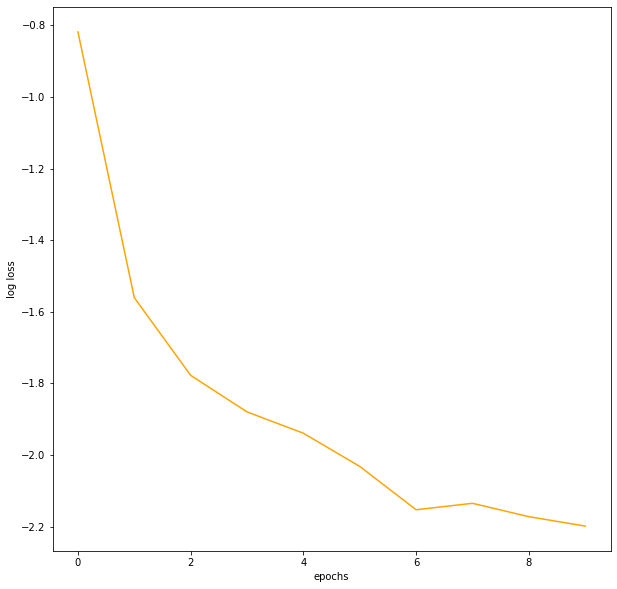

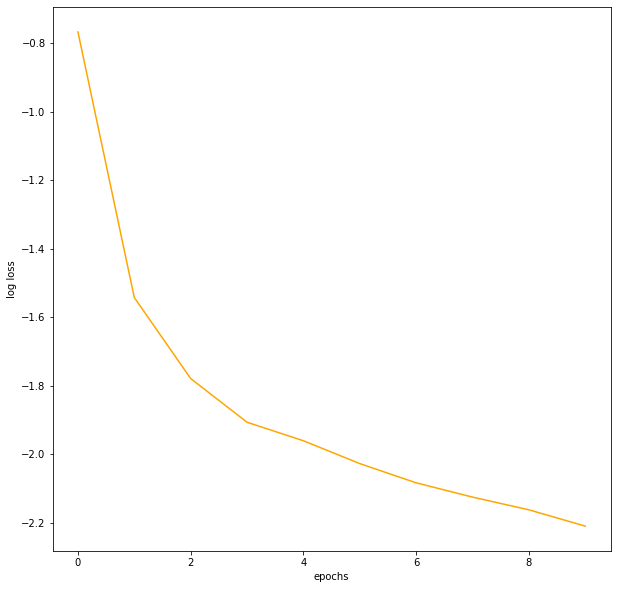

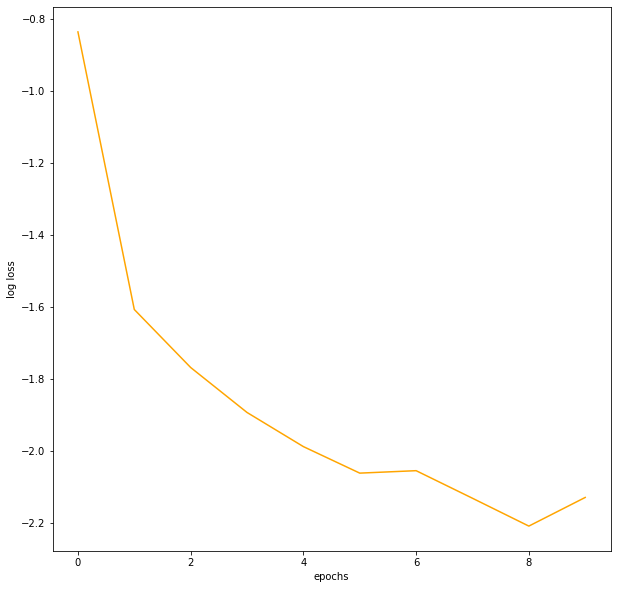

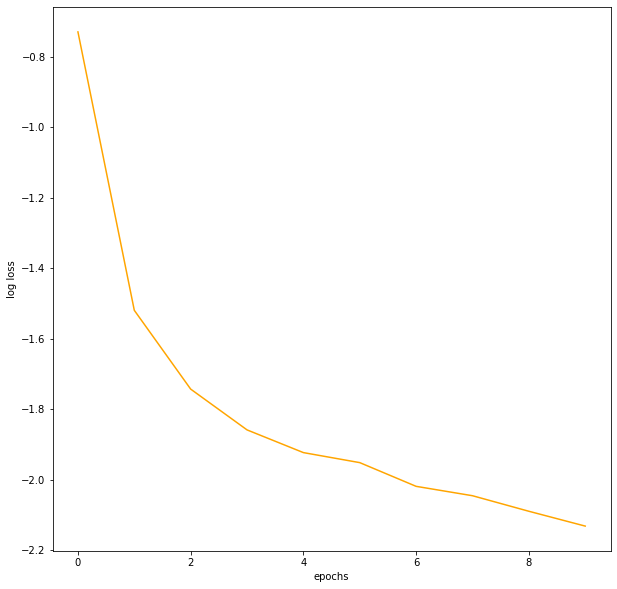

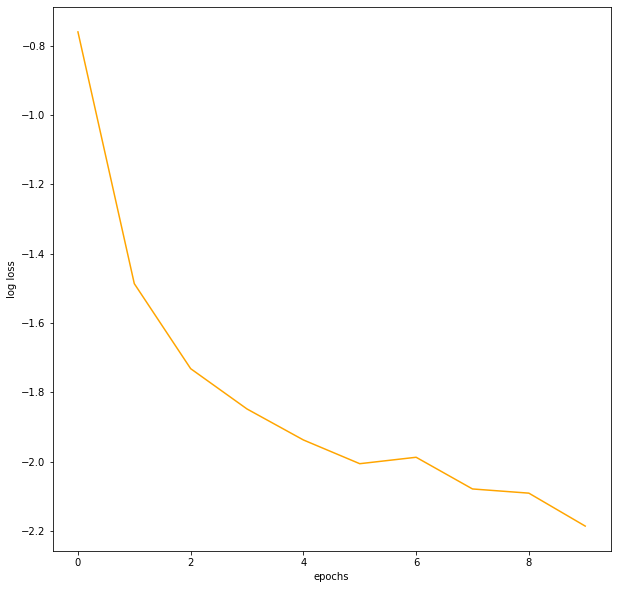

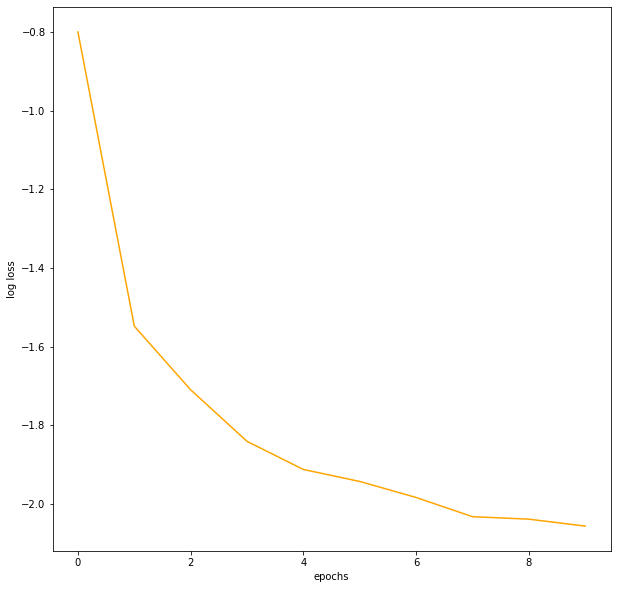

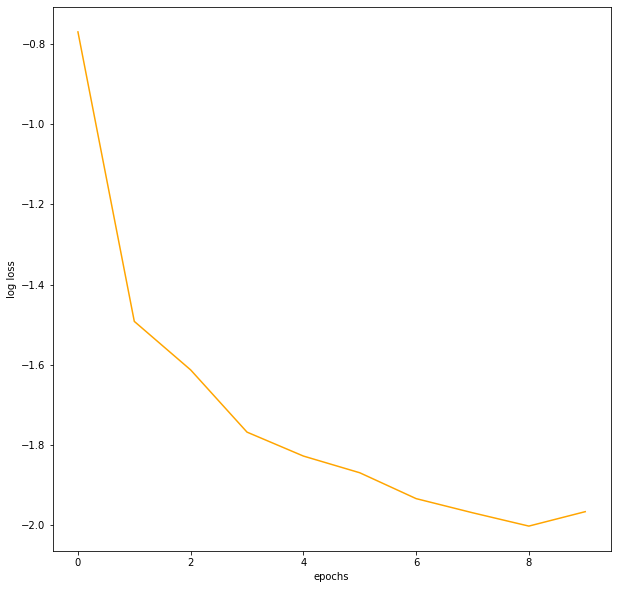

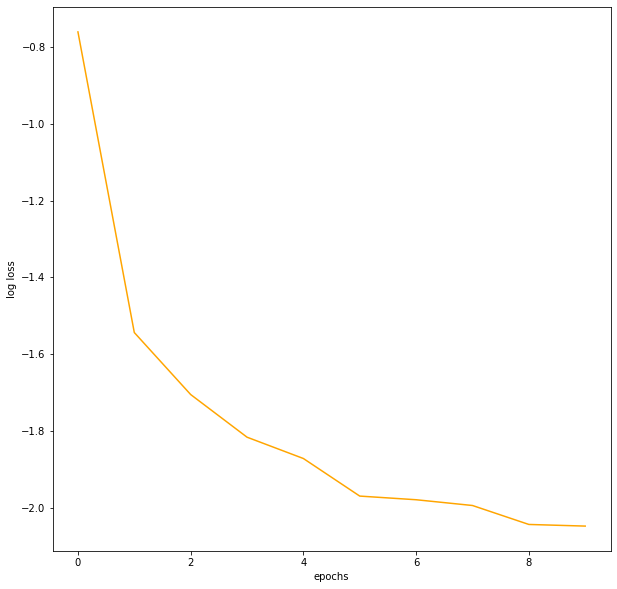

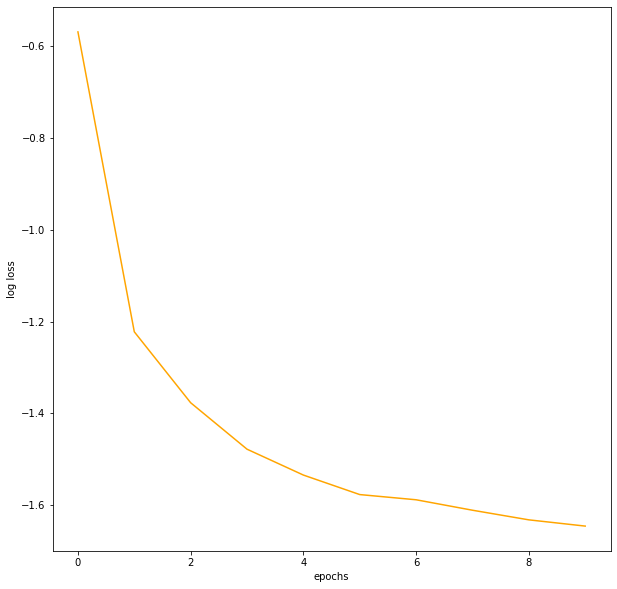

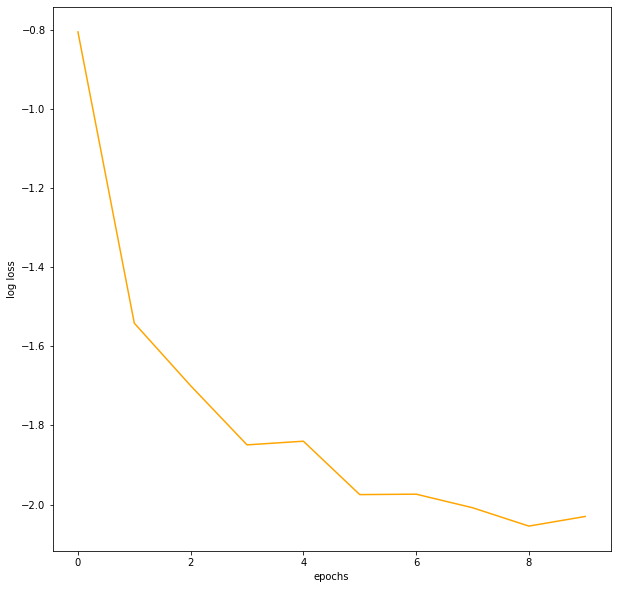

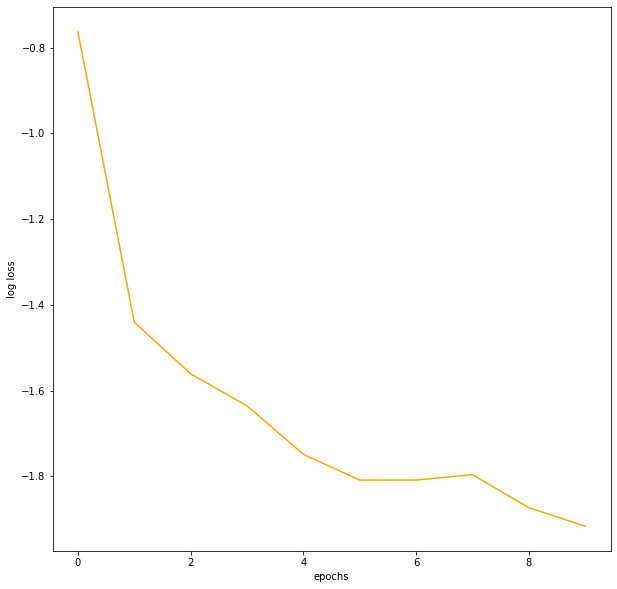

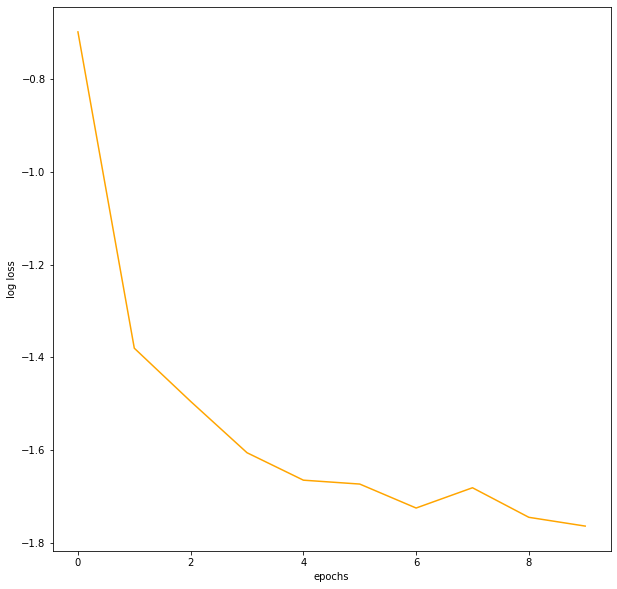

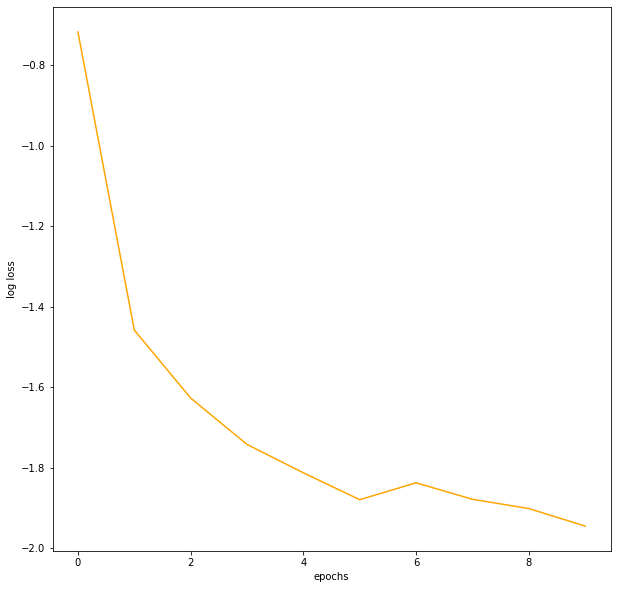

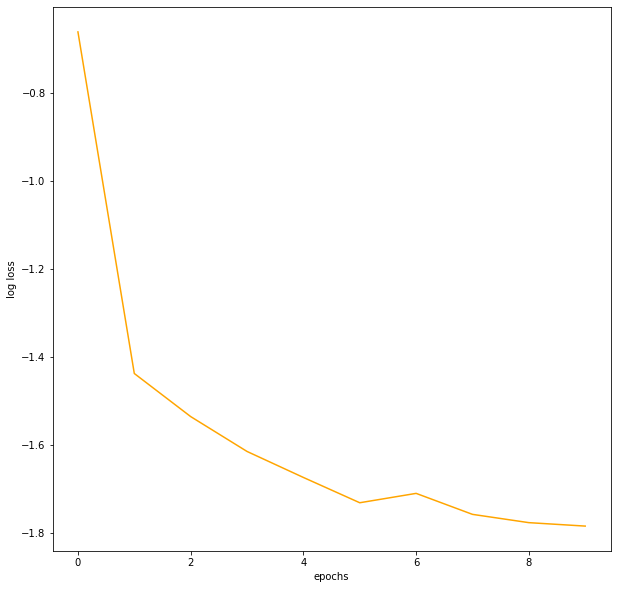

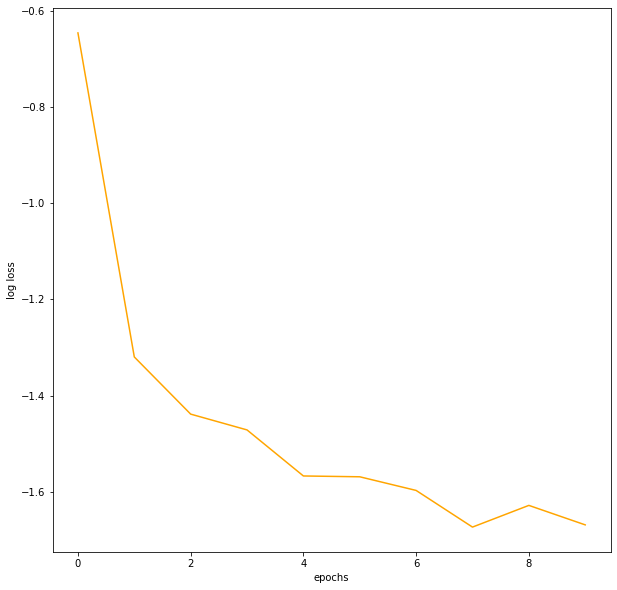

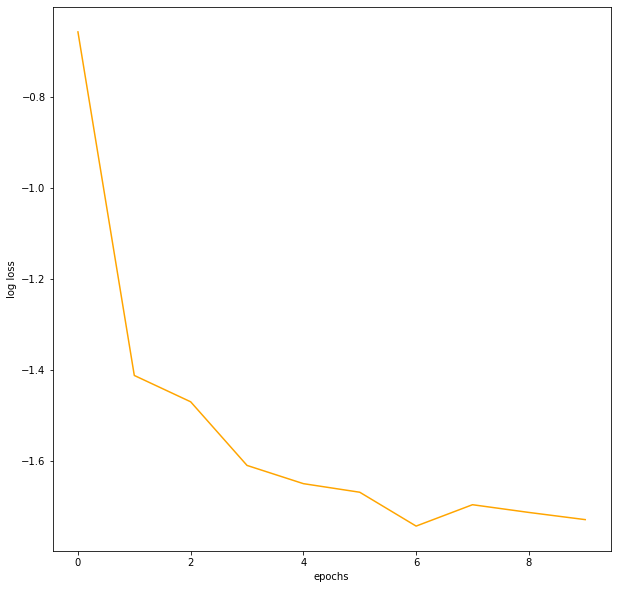

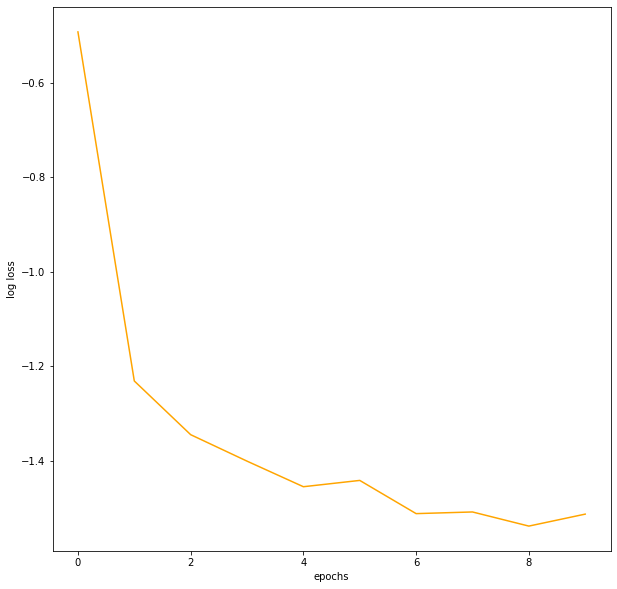

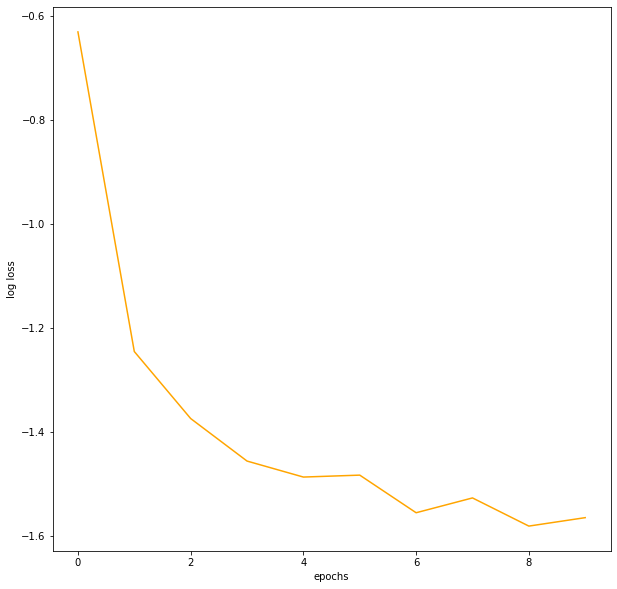

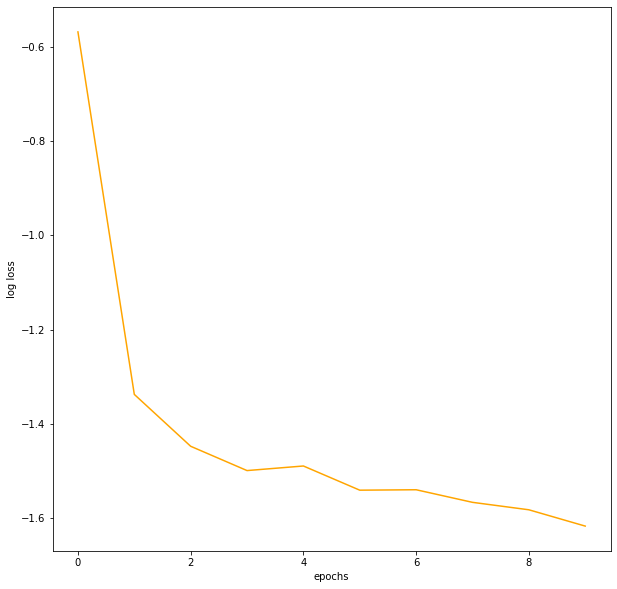

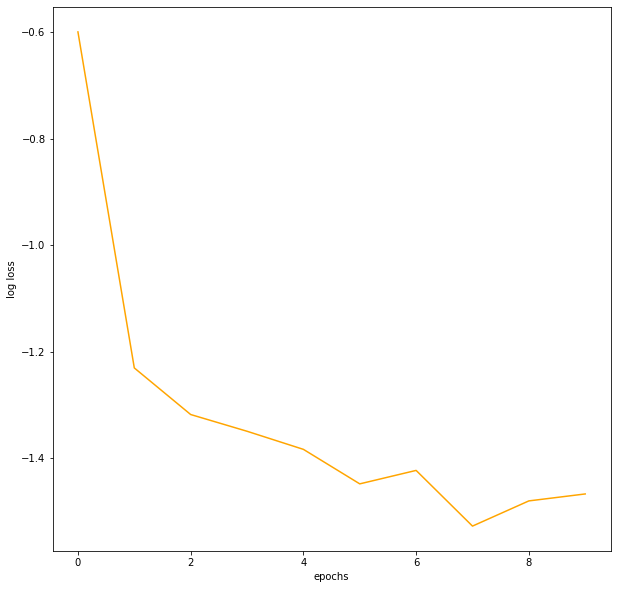

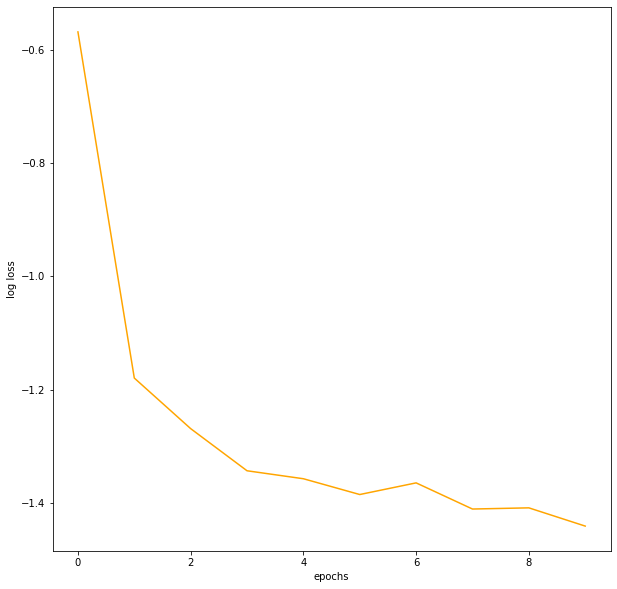

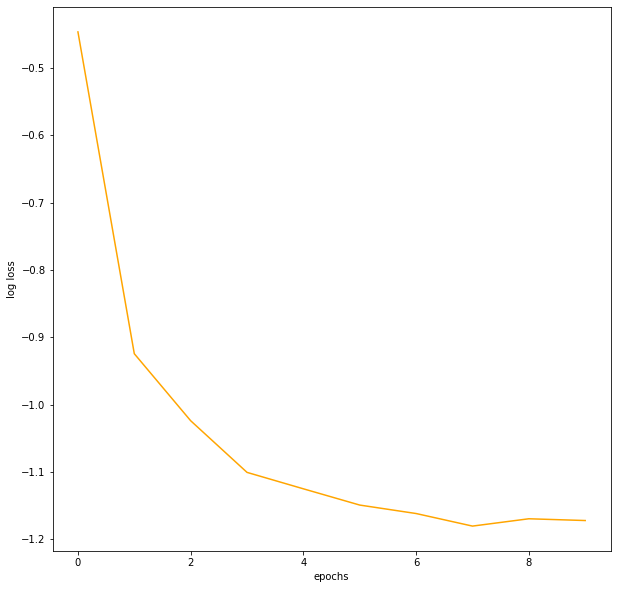

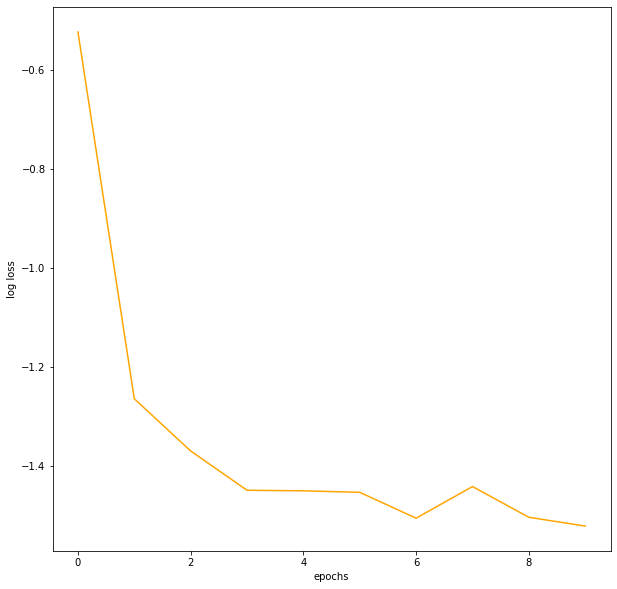

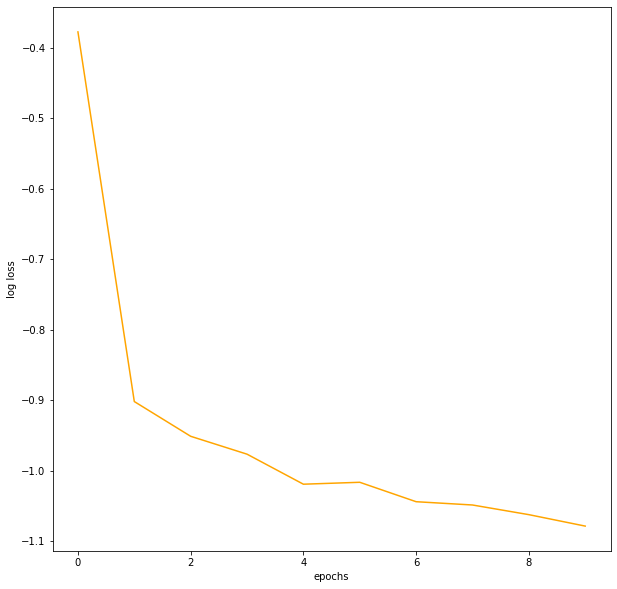

In [32]:
lrs = 10**torch.linspace(-5,-2,200)
losses=[]
for lr in tqdm(lrs):
    print('lr=',lr)
    model = Model(28*28, 500, 10,1, [0,0,0,0,0],0,False)
    loss=model.train(train_dl,epochs = 10, learning_rate=lr,lam=0)
    loss=torch.tensor(loss).exp()
    losses.append(min(loss).item())

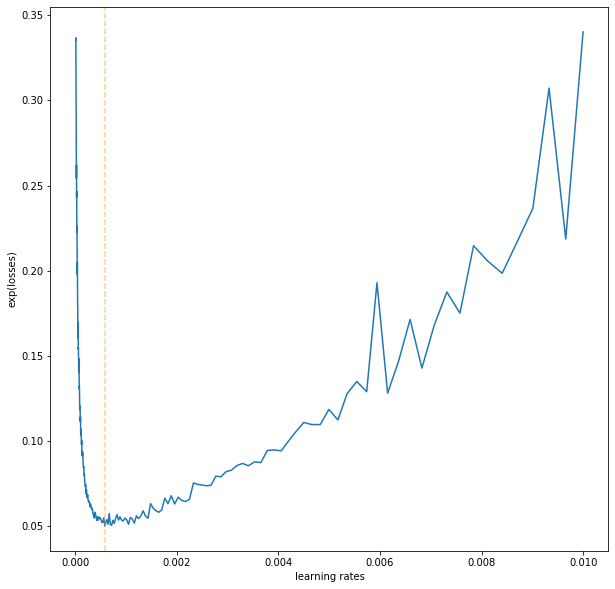

In [34]:
## lr vs losses:
optimal_lr = lrs[losses.index(min(losses))]
plt.figure(figsize=(10,10))
plt.plot(lrs,torch.tensor(losses))
plt.xlabel('learning rates')
plt.ylabel('exp(losses)')
plt.axvline(x=optimal_lr,color='orange',linestyle='--',alpha=0.5)

In [35]:
print('optimal learning rate: \n',optimal_lr.item())
print('least training loss',min(losses))

optimal learning rate: 
 0.0005805226974189281
least training loss 0.0501641184091568


#### 2. correct regularization coefficient (lambda) 

Taking the optimal learning rate we now move on with similar experimental setup to find the optimal regularisation term.

In [ ]:
lambdas = 10**torch.linspace(-7,-3,100)
losses=[]
for lam in tqdm(lambdas):
    model = Model(28*28, 500, 10,1, [0,0,0,0,0],0,True)
    model.train(train_dl,epochs = 10, learning_rate=optimal_lr.item(),lam=lam)
    loss = model.test(test_dl)
    losses.append(loss)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

epoch: 0 loss: 0.447299987077713
epoch: 1 loss: 0.20814640820026398
epoch: 2 loss: 0.14728085696697235
epoch: 3 loss: 0.11664135754108429
epoch: 4 loss: 0.10107999294996262
epoch: 5 loss: 0.08293846994638443
epoch: 6 loss: 0.07053624093532562
epoch: 7 loss: 0.06743089109659195
epoch: 8 loss: 0.05891140177845955
epoch: 9 loss: 0.052334755659103394
0.07892911319467652


  1%|▊                                                                              | 1/100 [02:24<3:58:43, 144.68s/it]

epoch: 0 loss: 0.4383862018585205
epoch: 1 loss: 0.20350678265094757
epoch: 2 loss: 0.14151881635189056
epoch: 3 loss: 0.1136433556675911
epoch: 4 loss: 0.09373463690280914
epoch: 5 loss: 0.08365693688392639
epoch: 6 loss: 0.06838252395391464
epoch: 7 loss: 0.06393331289291382
epoch: 8 loss: 0.05748672038316727
epoch: 9 loss: 0.05408301204442978
0.07549278955992099


  2%|█▌                                                                             | 2/100 [04:49<3:56:21, 144.71s/it]

epoch: 0 loss: 0.4508199393749237
epoch: 1 loss: 0.21495026350021362
epoch: 2 loss: 0.15108326077461243
epoch: 3 loss: 0.11851873248815536
epoch: 4 loss: 0.10085299611091614
epoch: 5 loss: 0.0824049860239029
epoch: 6 loss: 0.07495683431625366
epoch: 7 loss: 0.06555907428264618
epoch: 8 loss: 0.05888384208083153
epoch: 9 loss: 0.05199688673019409
0.07473673212085556


  3%|██▎                                                                            | 3/100 [07:14<3:53:53, 144.68s/it]

epoch: 0 loss: 0.44297319650650024
epoch: 1 loss: 0.20830164849758148
epoch: 2 loss: 0.1446325033903122
epoch: 3 loss: 0.11658098548650742
epoch: 4 loss: 0.09675198048353195
epoch: 5 loss: 0.08369768410921097
epoch: 6 loss: 0.07219360023736954
epoch: 7 loss: 0.06328506767749786
epoch: 8 loss: 0.060055993497371674
epoch: 9 loss: 0.054089244455099106
0.07639163377388275


  4%|███▏                                                                           | 4/100 [09:38<3:51:20, 144.59s/it]

epoch: 0 loss: 0.44086578488349915
epoch: 1 loss: 0.20500288903713226
epoch: 2 loss: 0.14557500183582306
epoch: 3 loss: 0.11527888476848602
epoch: 4 loss: 0.09688041359186172
epoch: 5 loss: 0.08650819957256317
epoch: 6 loss: 0.0745900496840477
epoch: 7 loss: 0.06326071172952652
epoch: 8 loss: 0.059082839637994766
epoch: 9 loss: 0.05358528718352318
0.08683951198502114


  5%|███▉                                                                           | 5/100 [12:02<3:48:48, 144.51s/it]

epoch: 0 loss: 0.4360676407814026
epoch: 1 loss: 0.2031361162662506
epoch: 2 loss: 0.14245368540287018
epoch: 3 loss: 0.11659190058708191
epoch: 4 loss: 0.09684205055236816
epoch: 5 loss: 0.08062683045864105
epoch: 6 loss: 0.07049677520990372
epoch: 7 loss: 0.0669562965631485
epoch: 8 loss: 0.05712945759296417
epoch: 9 loss: 0.0527835339307785
0.07590307761352108


  6%|████▋                                                                          | 6/100 [14:27<3:46:20, 144.47s/it]

epoch: 0 loss: 0.44584861397743225
epoch: 1 loss: 0.2049049735069275
epoch: 2 loss: 0.15094085037708282
epoch: 3 loss: 0.11611365526914597
epoch: 4 loss: 0.09833754599094391
epoch: 5 loss: 0.08505662530660629
epoch: 6 loss: 0.07422659546136856
epoch: 7 loss: 0.06258466839790344
epoch: 8 loss: 0.06022298336029053
epoch: 9 loss: 0.0543336383998394
0.08116087595610938


  7%|█████▌                                                                         | 7/100 [16:52<3:44:13, 144.67s/it]

epoch: 0 loss: 0.4377151131629944
epoch: 1 loss: 0.20309005677700043
epoch: 2 loss: 0.14856332540512085
epoch: 3 loss: 0.11678780615329742
epoch: 4 loss: 0.10010772943496704
epoch: 5 loss: 0.08113831281661987
epoch: 6 loss: 0.07509543746709824
epoch: 7 loss: 0.06322390586137772
epoch: 8 loss: 0.05796869099140167
epoch: 9 loss: 0.052178721874952316
0.06884002526175773


  8%|██████▎                                                                        | 8/100 [19:17<3:42:07, 144.87s/it]

epoch: 0 loss: 0.4359113276004791
epoch: 1 loss: 0.20485201478004456
epoch: 2 loss: 0.14749813079833984
epoch: 3 loss: 0.1148591861128807
epoch: 4 loss: 0.09557321667671204
epoch: 5 loss: 0.08125817775726318
epoch: 6 loss: 0.07193095982074738
epoch: 7 loss: 0.06618905067443848
epoch: 8 loss: 0.05837242305278778
epoch: 9 loss: 0.056429143995046616
0.08550173516055168


  9%|███████                                                                        | 9/100 [21:48<3:42:31, 146.72s/it]

epoch: 0 loss: 0.44496652483940125
epoch: 1 loss: 0.21235278248786926
epoch: 2 loss: 0.1464998871088028
epoch: 3 loss: 0.12108214199542999
epoch: 4 loss: 0.0960504561662674
epoch: 5 loss: 0.08587498962879181
epoch: 6 loss: 0.07256315648555756
epoch: 7 loss: 0.06655269861221313
epoch: 8 loss: 0.05777855962514877
epoch: 9 loss: 0.05413386970758438
0.0805635264510277


 10%|███████▊                                                                      | 10/100 [24:19<3:41:49, 147.88s/it]

epoch: 0 loss: 0.4512482285499573
epoch: 1 loss: 0.21048255264759064
epoch: 2 loss: 0.15161766111850739
epoch: 3 loss: 0.11932092159986496
epoch: 4 loss: 0.10016189515590668
epoch: 5 loss: 0.08307074010372162
epoch: 6 loss: 0.07338661700487137
epoch: 7 loss: 0.06721382588148117
epoch: 8 loss: 0.0597517229616642
epoch: 9 loss: 0.05239884927868843
0.09772303456564352


 11%|████████▌                                                                     | 11/100 [26:43<3:37:56, 146.93s/it]

epoch: 0 loss: 0.45501139760017395
epoch: 1 loss: 0.21533776819705963
epoch: 2 loss: 0.1479232907295227
epoch: 3 loss: 0.1189638003706932
epoch: 4 loss: 0.09821845591068268
epoch: 5 loss: 0.08595668524503708
epoch: 6 loss: 0.07274341583251953
epoch: 7 loss: 0.0651063546538353
epoch: 8 loss: 0.06250111758708954
epoch: 9 loss: 0.05278702452778816
0.07185789434842713


 12%|█████████▎                                                                    | 12/100 [29:09<3:34:50, 146.48s/it]

epoch: 0 loss: 0.44521892070770264
epoch: 1 loss: 0.21021230518817902
epoch: 2 loss: 0.15107116103172302
epoch: 3 loss: 0.12147212028503418
epoch: 4 loss: 0.09991533309221268
epoch: 5 loss: 0.08725549280643463
epoch: 6 loss: 0.07546798139810562
epoch: 7 loss: 0.06621308624744415
epoch: 8 loss: 0.06076827272772789
epoch: 9 loss: 0.053682006895542145
0.09996649944164519


 13%|██████████▏                                                                   | 13/100 [31:35<3:32:01, 146.23s/it]

epoch: 0 loss: 0.44418472051620483
epoch: 1 loss: 0.21124906837940216
epoch: 2 loss: 0.1476447433233261
epoch: 3 loss: 0.12016762793064117
epoch: 4 loss: 0.09989038854837418
epoch: 5 loss: 0.08539500087499619
epoch: 6 loss: 0.07287391275167465
epoch: 7 loss: 0.06681951880455017
epoch: 8 loss: 0.05911131948232651
epoch: 9 loss: 0.05406578630208969
0.09620644246475606


 14%|██████████▉                                                                   | 14/100 [33:59<3:28:48, 145.68s/it]

epoch: 0 loss: 0.4457337260246277
epoch: 1 loss: 0.2148507833480835
epoch: 2 loss: 0.14913691580295563
epoch: 3 loss: 0.11736047267913818
epoch: 4 loss: 0.0982208400964737
epoch: 5 loss: 0.08444350957870483
epoch: 6 loss: 0.07407495379447937
epoch: 7 loss: 0.06334830820560455
epoch: 8 loss: 0.05788728594779968
epoch: 9 loss: 0.05460190773010254
0.07117916244307615


 15%|███████████▋                                                                  | 15/100 [36:23<3:25:54, 145.35s/it]

epoch: 0 loss: 0.4384285807609558
epoch: 1 loss: 0.2060588002204895
epoch: 2 loss: 0.14984537661075592
epoch: 3 loss: 0.11376545578241348
epoch: 4 loss: 0.09625772386789322
epoch: 5 loss: 0.08607980608940125
epoch: 6 loss: 0.07242622971534729
epoch: 7 loss: 0.0659143403172493
epoch: 8 loss: 0.057168129831552505
epoch: 9 loss: 0.05156924948096275
0.0829771856192162


 16%|████████████▍                                                                 | 16/100 [38:49<3:23:20, 145.25s/it]

epoch: 0 loss: 0.4355171024799347
epoch: 1 loss: 0.20421653985977173
epoch: 2 loss: 0.14788928627967834
epoch: 3 loss: 0.11450127512216568
epoch: 4 loss: 0.09911303222179413
epoch: 5 loss: 0.08419108390808105
epoch: 6 loss: 0.07379037141799927
epoch: 7 loss: 0.06625528633594513
epoch: 8 loss: 0.056922391057014465
epoch: 9 loss: 0.05281805247068405
0.08661384515087062


 17%|█████████████▎                                                                | 17/100 [41:14<3:21:04, 145.35s/it]

epoch: 0 loss: 0.44201672077178955
epoch: 1 loss: 0.2118634432554245
epoch: 2 loss: 0.1463572233915329
epoch: 3 loss: 0.11818232387304306
epoch: 4 loss: 0.09987358748912811
epoch: 5 loss: 0.08444469422101974
epoch: 6 loss: 0.07428910583257675
epoch: 7 loss: 0.06726633757352829
epoch: 8 loss: 0.05944697558879852
epoch: 9 loss: 0.053339920938014984
0.07659700806503172


 18%|██████████████                                                                | 18/100 [43:39<3:18:20, 145.13s/it]

epoch: 0 loss: 0.44374415278434753
epoch: 1 loss: 0.20947960019111633
epoch: 2 loss: 0.14586424827575684
epoch: 3 loss: 0.1180412620306015
epoch: 4 loss: 0.09669872373342514
epoch: 5 loss: 0.08498328924179077
epoch: 6 loss: 0.07426946610212326
epoch: 7 loss: 0.06496387720108032
epoch: 8 loss: 0.05892849713563919
epoch: 9 loss: 0.05415590852499008
0.07219047294752791


 19%|██████████████▊                                                               | 19/100 [46:03<3:15:35, 144.89s/it]

epoch: 0 loss: 0.4382869601249695
epoch: 1 loss: 0.20770511031150818
epoch: 2 loss: 0.14730437099933624
epoch: 3 loss: 0.11749080568552017
epoch: 4 loss: 0.09757328778505325
epoch: 5 loss: 0.08276426792144775
epoch: 6 loss: 0.0742393359541893
epoch: 7 loss: 0.06305929273366928
epoch: 8 loss: 0.05892616882920265
epoch: 9 loss: 0.05355260148644447
0.06873357553890452


 20%|███████████████▌                                                              | 20/100 [48:28<3:13:09, 144.86s/it]

epoch: 0 loss: 0.45335397124290466
epoch: 1 loss: 0.20670856535434723
epoch: 2 loss: 0.1464385688304901
epoch: 3 loss: 0.11676512658596039
epoch: 4 loss: 0.09609920531511307
epoch: 5 loss: 0.08126742392778397
epoch: 6 loss: 0.07262903451919556
epoch: 7 loss: 0.0630643293261528
epoch: 8 loss: 0.05874539911746979
epoch: 9 loss: 0.05119859427213669


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.07820758995853506


 21%|████████████████▍                                                             | 21/100 [50:53<3:10:58, 145.05s/it]

epoch: 0 loss: 0.44767412543296814
epoch: 1 loss: 0.2144801765680313
epoch: 2 loss: 0.15007731318473816
epoch: 3 loss: 0.1188548132777214
epoch: 4 loss: 0.09599616378545761
epoch: 5 loss: 0.08451713621616364
epoch: 6 loss: 0.07272796332836151
epoch: 7 loss: 0.06192675977945328
epoch: 8 loss: 0.05853642523288727
epoch: 9 loss: 0.05408376455307007
0.08430637383857105


 22%|█████████████████▏                                                            | 22/100 [53:18<3:08:35, 145.07s/it]

epoch: 0 loss: 0.4404844045639038
epoch: 1 loss: 0.20780016481876373
epoch: 2 loss: 0.14902174472808838
epoch: 3 loss: 0.11392935365438461
epoch: 4 loss: 0.09795553237199783
epoch: 5 loss: 0.08811015635728836
epoch: 6 loss: 0.07490357011556625
epoch: 7 loss: 0.06639102101325989
epoch: 8 loss: 0.0601164735853672
epoch: 9 loss: 0.05591346696019173
0.08202632353235849


 23%|█████████████████▉                                                            | 23/100 [55:43<3:05:52, 144.84s/it]

epoch: 0 loss: 0.43523842096328735
epoch: 1 loss: 0.2014467716217041
epoch: 2 loss: 0.1439380794763565
epoch: 3 loss: 0.11636163294315338
epoch: 4 loss: 0.09652932733297348
epoch: 5 loss: 0.08331828564405441
epoch: 6 loss: 0.07266783714294434
epoch: 7 loss: 0.06528797000646591
epoch: 8 loss: 0.060152746737003326
epoch: 9 loss: 0.052640151232481
0.07423321886671136


 24%|██████████████████▋                                                           | 24/100 [58:09<3:03:57, 145.23s/it]

epoch: 0 loss: 0.4450216591358185
epoch: 1 loss: 0.21094004809856415
epoch: 2 loss: 0.14685416221618652
epoch: 3 loss: 0.1152910441160202
epoch: 4 loss: 0.10095406323671341
epoch: 5 loss: 0.082896888256073
epoch: 6 loss: 0.07350186258554459
epoch: 7 loss: 0.06596864014863968
epoch: 8 loss: 0.056881099939346313
epoch: 9 loss: 0.055353034287691116
0.07287564803505407


 25%|███████████████████                                                         | 25/100 [1:00:33<3:01:13, 144.98s/it]

epoch: 0 loss: 0.4493710696697235
epoch: 1 loss: 0.21429942548274994
epoch: 2 loss: 0.1514924168586731
epoch: 3 loss: 0.11987058818340302
epoch: 4 loss: 0.0977790579199791
epoch: 5 loss: 0.08221403509378433
epoch: 6 loss: 0.07794979959726334
epoch: 7 loss: 0.0659053847193718
epoch: 8 loss: 0.05771605297923088
epoch: 9 loss: 0.053849026560783386
0.07948305993967195


 26%|███████████████████▊                                                        | 26/100 [1:02:58<2:58:49, 145.00s/it]

epoch: 0 loss: 0.4461458623409271
epoch: 1 loss: 0.20544728636741638
epoch: 2 loss: 0.14684276282787323
epoch: 3 loss: 0.11954434216022491
epoch: 4 loss: 0.10059424489736557
epoch: 5 loss: 0.08252006769180298
epoch: 6 loss: 0.07470298558473587
epoch: 7 loss: 0.06417172402143478
epoch: 8 loss: 0.059337977319955826
epoch: 9 loss: 0.05582443252205849
0.0672972386628662


 27%|████████████████████▌                                                       | 27/100 [1:05:23<2:56:17, 144.89s/it]

epoch: 0 loss: 0.4441639184951782
epoch: 1 loss: 0.20556114614009857
epoch: 2 loss: 0.14586898684501648
epoch: 3 loss: 0.11556396633386612
epoch: 4 loss: 0.09471189975738525
epoch: 5 loss: 0.08630964159965515
epoch: 6 loss: 0.0730178952217102
epoch: 7 loss: 0.06540510803461075
epoch: 8 loss: 0.06101655587553978
epoch: 9 loss: 0.052160389721393585
0.07950744737586952


 28%|█████████████████████▎                                                      | 28/100 [1:07:48<2:53:56, 144.95s/it]

epoch: 0 loss: 0.4413512945175171
epoch: 1 loss: 0.20983169972896576
epoch: 2 loss: 0.1473357230424881
epoch: 3 loss: 0.11711331456899643
epoch: 4 loss: 0.0945131853222847
epoch: 5 loss: 0.08534912019968033
epoch: 6 loss: 0.0757698193192482
epoch: 7 loss: 0.06488411128520966
epoch: 8 loss: 0.05979740619659424
epoch: 9 loss: 0.05052414536476135
0.08001579003389395


 29%|██████████████████████                                                      | 29/100 [1:10:13<2:51:30, 144.94s/it]

epoch: 0 loss: 0.4365943968296051
epoch: 1 loss: 0.208639457821846
epoch: 2 loss: 0.14836353063583374
epoch: 3 loss: 0.11725369840860367
epoch: 4 loss: 0.09676175564527512
epoch: 5 loss: 0.08094891905784607
epoch: 6 loss: 0.07442135363817215
epoch: 7 loss: 0.06351377069950104
epoch: 8 loss: 0.05905715376138687
epoch: 9 loss: 0.05137795954942703
0.07829948929282159


 30%|██████████████████████▊                                                     | 30/100 [1:12:38<2:49:10, 145.00s/it]

epoch: 0 loss: 0.4461769759654999
epoch: 1 loss: 0.2040477693080902
epoch: 2 loss: 0.14399133622646332
epoch: 3 loss: 0.11326903104782104
epoch: 4 loss: 0.09885285049676895
epoch: 5 loss: 0.08493421226739883
epoch: 6 loss: 0.07477656751871109
epoch: 7 loss: 0.06591734290122986
epoch: 8 loss: 0.05667511746287346
epoch: 9 loss: 0.05455297604203224
0.07264719642952963


 31%|███████████████████████▌                                                    | 31/100 [1:15:04<2:46:57, 145.18s/it]

epoch: 0 loss: 0.4430186450481415
epoch: 1 loss: 0.20882061123847961
epoch: 2 loss: 0.14829662442207336
epoch: 3 loss: 0.11810346692800522
epoch: 4 loss: 0.09765298664569855
epoch: 5 loss: 0.08347540348768234
epoch: 6 loss: 0.07277088612318039
epoch: 7 loss: 0.06557099521160126
epoch: 8 loss: 0.06052296981215477
epoch: 9 loss: 0.05252920463681221
0.0800684254417193


 32%|████████████████████████▎                                                   | 32/100 [1:17:29<2:44:25, 145.08s/it]

epoch: 0 loss: 0.43868380784988403
epoch: 1 loss: 0.20642609894275665
epoch: 2 loss: 0.14736956357955933
epoch: 3 loss: 0.11448857188224792
epoch: 4 loss: 0.09924402832984924
epoch: 5 loss: 0.0831431895494461
epoch: 6 loss: 0.07199590653181076
epoch: 7 loss: 0.0649847462773323
epoch: 8 loss: 0.05879500135779381
epoch: 9 loss: 0.05077135190367699
0.07461288559679355


 33%|█████████████████████████                                                   | 33/100 [1:19:54<2:42:14, 145.29s/it]

epoch: 0 loss: 0.44197505712509155
epoch: 1 loss: 0.21543607115745544
epoch: 2 loss: 0.14919692277908325
epoch: 3 loss: 0.11824954301118851
epoch: 4 loss: 0.09769034385681152
epoch: 5 loss: 0.08516772836446762
epoch: 6 loss: 0.07606668770313263
epoch: 7 loss: 0.0661676898598671
epoch: 8 loss: 0.05930468440055847
epoch: 9 loss: 0.05363428592681885
0.07068823193843901


 34%|█████████████████████████▊                                                  | 34/100 [1:22:19<2:39:46, 145.25s/it]

epoch: 0 loss: 0.45515453815460205
epoch: 1 loss: 0.22011317312717438
epoch: 2 loss: 0.15036194026470184
epoch: 3 loss: 0.1209796592593193
epoch: 4 loss: 0.10062974691390991
epoch: 5 loss: 0.08660672605037689
epoch: 6 loss: 0.0765693187713623
epoch: 7 loss: 0.06465957313776016
epoch: 8 loss: 0.060247939079999924
epoch: 9 loss: 0.054220110177993774
0.06825228578144318


 35%|██████████████████████████▌                                                 | 35/100 [1:24:45<2:37:21, 145.25s/it]

epoch: 0 loss: 0.435707151889801
epoch: 1 loss: 0.2107275277376175
epoch: 2 loss: 0.1454496830701828
epoch: 3 loss: 0.11773350834846497
epoch: 4 loss: 0.1009163111448288
epoch: 5 loss: 0.08463995158672333
epoch: 6 loss: 0.07454447448253632
epoch: 7 loss: 0.0676368772983551
epoch: 8 loss: 0.05870357155799866
epoch: 9 loss: 0.05466138944029808
0.0754866574631556


 36%|███████████████████████████▎                                                | 36/100 [1:27:10<2:35:05, 145.40s/it]

epoch: 0 loss: 0.4535718858242035
epoch: 1 loss: 0.2167121320962906
epoch: 2 loss: 0.15295682847499847
epoch: 3 loss: 0.1175200492143631
epoch: 4 loss: 0.09994590282440186
epoch: 5 loss: 0.08643903583288193
epoch: 6 loss: 0.07562374323606491
epoch: 7 loss: 0.06563511490821838
epoch: 8 loss: 0.06065673753619194
epoch: 9 loss: 0.05479159951210022
0.08834572690332756


 37%|████████████████████████████                                                | 37/100 [1:29:36<2:32:43, 145.45s/it]

epoch: 0 loss: 0.45397529006004333
epoch: 1 loss: 0.2144801765680313
epoch: 2 loss: 0.14956234395503998
epoch: 3 loss: 0.11899800598621368
epoch: 4 loss: 0.09902502596378326
epoch: 5 loss: 0.08770166337490082
epoch: 6 loss: 0.07687728852033615
epoch: 7 loss: 0.06656090170145035
epoch: 8 loss: 0.055822551250457764
epoch: 9 loss: 0.05550508201122284
0.07961985722915092


 38%|████████████████████████████▉                                               | 38/100 [1:32:02<2:30:27, 145.61s/it]

epoch: 0 loss: 0.4436151683330536
epoch: 1 loss: 0.20957736670970917
epoch: 2 loss: 0.14827445149421692
epoch: 3 loss: 0.11628559976816177
epoch: 4 loss: 0.10011973232030869
epoch: 5 loss: 0.08528943359851837
epoch: 6 loss: 0.07545065134763718
epoch: 7 loss: 0.06564391404390335
epoch: 8 loss: 0.06032270938158035
epoch: 9 loss: 0.05520778149366379
0.09223536966969789


 39%|█████████████████████████████▋                                              | 39/100 [1:34:28<2:28:00, 145.58s/it]

epoch: 0 loss: 0.435668021440506
epoch: 1 loss: 0.20518435537815094
epoch: 2 loss: 0.14908722043037415
epoch: 3 loss: 0.11696978658437729
epoch: 4 loss: 0.098783478140831
epoch: 5 loss: 0.08448019623756409
epoch: 6 loss: 0.07337525486946106
epoch: 7 loss: 0.0651334673166275
epoch: 8 loss: 0.0570441335439682
epoch: 9 loss: 0.0542454719543457
0.09714871200679837


 40%|██████████████████████████████▍                                             | 40/100 [1:36:54<2:25:53, 145.89s/it]

epoch: 0 loss: 0.4554479718208313
epoch: 1 loss: 0.21140383183956146
epoch: 2 loss: 0.1524229198694229
epoch: 3 loss: 0.11868837475776672
epoch: 4 loss: 0.10060156881809235
epoch: 5 loss: 0.08697197586297989
epoch: 6 loss: 0.07814790308475494
epoch: 7 loss: 0.06744439899921417
epoch: 8 loss: 0.061188794672489166
epoch: 9 loss: 0.051873814314603806
0.1083810722832627


 41%|███████████████████████████████▏                                            | 41/100 [1:39:22<2:24:06, 146.55s/it]

epoch: 0 loss: 0.446063756942749
epoch: 1 loss: 0.21384143829345703
epoch: 2 loss: 0.15487653017044067
epoch: 3 loss: 0.1213315948843956
epoch: 4 loss: 0.10187634825706482
epoch: 5 loss: 0.08638011664152145
epoch: 6 loss: 0.07718756794929504
epoch: 7 loss: 0.06489472836256027
epoch: 8 loss: 0.06099995598196983
epoch: 9 loss: 0.0513172410428524
0.08675766533721073


 42%|███████████████████████████████▉                                            | 42/100 [1:41:51<2:22:22, 147.29s/it]

epoch: 0 loss: 0.4373416304588318
epoch: 1 loss: 0.1999225914478302
epoch: 2 loss: 0.14452826976776123
epoch: 3 loss: 0.11407753825187683
epoch: 4 loss: 0.09560636430978775
epoch: 5 loss: 0.08583416789770126
epoch: 6 loss: 0.07432518154382706
epoch: 7 loss: 0.06478653103113174
epoch: 8 loss: 0.058415159583091736
epoch: 9 loss: 0.05326005071401596
0.07408184882135888


 43%|████████████████████████████████▋                                           | 43/100 [1:44:27<2:22:11, 149.67s/it]

epoch: 0 loss: 0.4410882890224457
epoch: 1 loss: 0.2112937867641449
epoch: 2 loss: 0.1498158723115921
epoch: 3 loss: 0.11976394802331924
epoch: 4 loss: 0.09686052054166794
epoch: 5 loss: 0.0851891040802002
epoch: 6 loss: 0.07329921424388885
epoch: 7 loss: 0.06447649002075195
epoch: 8 loss: 0.05792143568396568
epoch: 9 loss: 0.05270560085773468
0.08665613334688957


 44%|█████████████████████████████████▍                                          | 44/100 [1:47:04<2:21:59, 152.13s/it]

epoch: 0 loss: 0.4526721239089966
epoch: 1 loss: 0.2124747782945633
epoch: 2 loss: 0.1527917981147766
epoch: 3 loss: 0.1217113584280014
epoch: 4 loss: 0.1007213220000267
epoch: 5 loss: 0.08798324316740036
epoch: 6 loss: 0.0742279663681984
epoch: 7 loss: 0.06880836933851242
epoch: 8 loss: 0.05919957533478737
epoch: 9 loss: 0.0531548410654068
0.07411368817103514


 45%|██████████████████████████████████▏                                         | 45/100 [1:49:49<2:22:50, 155.83s/it]

epoch: 0 loss: 0.44904625415802
epoch: 1 loss: 0.20854152739048004
epoch: 2 loss: 0.14598314464092255
epoch: 3 loss: 0.11888515949249268
epoch: 4 loss: 0.09735863655805588
epoch: 5 loss: 0.08358076214790344
epoch: 6 loss: 0.07310386002063751
epoch: 7 loss: 0.06281966716051102
epoch: 8 loss: 0.06133582442998886
epoch: 9 loss: 0.05060206353664398
0.07772152635889258


 46%|██████████████████████████████████▉                                         | 46/100 [1:52:35<2:22:57, 158.84s/it]

epoch: 0 loss: 0.4496989846229553
epoch: 1 loss: 0.21136374771595
epoch: 2 loss: 0.14869225025177002
epoch: 3 loss: 0.11924567073583603
epoch: 4 loss: 0.09938521683216095
epoch: 5 loss: 0.08627679198980331
epoch: 6 loss: 0.07457786798477173
epoch: 7 loss: 0.06695694476366043
epoch: 8 loss: 0.06044676527380943
epoch: 9 loss: 0.05862341448664665
0.08449133726196434


 47%|███████████████████████████████████▋                                        | 47/100 [1:55:17<2:21:13, 159.88s/it]

epoch: 0 loss: 0.4455784857273102
epoch: 1 loss: 0.20594513416290283
epoch: 2 loss: 0.1457681506872177
epoch: 3 loss: 0.11750800907611847
epoch: 4 loss: 0.09548022598028183
epoch: 5 loss: 0.08677605539560318
epoch: 6 loss: 0.0728810653090477
epoch: 7 loss: 0.06667732447385788
epoch: 8 loss: 0.0593835674226284
epoch: 9 loss: 0.0536481998860836
0.07768774993755985


 48%|████████████████████████████████████▍                                       | 48/100 [1:58:01<2:19:43, 161.22s/it]

epoch: 0 loss: 0.4439375102519989
epoch: 1 loss: 0.2074732780456543
epoch: 2 loss: 0.15017321705818176
epoch: 3 loss: 0.12051186710596085
epoch: 4 loss: 0.10101855546236038
epoch: 5 loss: 0.08140573650598526
epoch: 6 loss: 0.07380996644496918
epoch: 7 loss: 0.06853988766670227
epoch: 8 loss: 0.05957518517971039
epoch: 9 loss: 0.05452892184257507
0.08407989524148664


 49%|█████████████████████████████████████▏                                      | 49/100 [2:00:49<2:18:39, 163.13s/it]

epoch: 0 loss: 0.4477756917476654
epoch: 1 loss: 0.21339312195777893
epoch: 2 loss: 0.1522834599018097
epoch: 3 loss: 0.11370571702718735
epoch: 4 loss: 0.09478779882192612
epoch: 5 loss: 0.08216482400894165
epoch: 6 loss: 0.07755690813064575
epoch: 7 loss: 0.06494562327861786
epoch: 8 loss: 0.06014491617679596
epoch: 9 loss: 0.054412275552749634
0.08003509922201385


 50%|██████████████████████████████████████                                      | 50/100 [2:03:28<2:14:51, 161.83s/it]

epoch: 0 loss: 0.4533469080924988
epoch: 1 loss: 0.2171456664800644
epoch: 2 loss: 0.15375395119190216
epoch: 3 loss: 0.11812059581279755
epoch: 4 loss: 0.0996425598859787
epoch: 5 loss: 0.08337248116731644
epoch: 6 loss: 0.07694504410028458
epoch: 7 loss: 0.06639356166124344
epoch: 8 loss: 0.05904080718755722
epoch: 9 loss: 0.0536293163895607
0.07712715867681347


 51%|██████████████████████████████████████▊                                     | 51/100 [2:06:09<2:12:04, 161.73s/it]

epoch: 0 loss: 0.4517761170864105
epoch: 1 loss: 0.21050456166267395
epoch: 2 loss: 0.14759908616542816
epoch: 3 loss: 0.11869267374277115
epoch: 4 loss: 0.10075034201145172
epoch: 5 loss: 0.08683588355779648
epoch: 6 loss: 0.07428474724292755
epoch: 7 loss: 0.06587272882461548
epoch: 8 loss: 0.059541966766119
epoch: 9 loss: 0.055497605353593826
0.07600447964741071


 52%|███████████████████████████████████████▌                                    | 52/100 [2:08:48<2:08:40, 160.85s/it]

epoch: 0 loss: 0.44694265723228455
epoch: 1 loss: 0.2118878811597824
epoch: 2 loss: 0.1522945612668991
epoch: 3 loss: 0.1175294890999794
epoch: 4 loss: 0.09773468226194382
epoch: 5 loss: 0.0848693773150444
epoch: 6 loss: 0.07359578460454941
epoch: 7 loss: 0.06722990423440933
epoch: 8 loss: 0.056867241859436035
epoch: 9 loss: 0.05432932451367378
0.07708943025444788


 53%|████████████████████████████████████████▎                                   | 53/100 [2:11:22<2:04:29, 158.93s/it]

epoch: 0 loss: 0.44796857237815857
epoch: 1 loss: 0.21125197410583496
epoch: 2 loss: 0.14968763291835785
epoch: 3 loss: 0.11851496249437332
epoch: 4 loss: 0.09435795992612839
epoch: 5 loss: 0.08595214039087296
epoch: 6 loss: 0.07284560799598694
epoch: 7 loss: 0.06761717796325684
epoch: 8 loss: 0.06200719624757767
epoch: 9 loss: 0.05355840176343918
0.08310431449399978


 54%|█████████████████████████████████████████                                   | 54/100 [2:14:00<2:01:35, 158.60s/it]

epoch: 0 loss: 0.4484585225582123
epoch: 1 loss: 0.21540012955665588
epoch: 2 loss: 0.14995287358760834
epoch: 3 loss: 0.1187286227941513
epoch: 4 loss: 0.09836489707231522
epoch: 5 loss: 0.08847010135650635
epoch: 6 loss: 0.0778847485780716
epoch: 7 loss: 0.06485871225595474
epoch: 8 loss: 0.06163876876235008
epoch: 9 loss: 0.054594576358795166
0.08009402530840333


 55%|█████████████████████████████████████████▊                                  | 55/100 [2:16:42<1:59:34, 159.43s/it]

epoch: 0 loss: 0.443464994430542
epoch: 1 loss: 0.21114245057106018
epoch: 2 loss: 0.15023602545261383
epoch: 3 loss: 0.11831893771886826
epoch: 4 loss: 0.1006878912448883
epoch: 5 loss: 0.0836063027381897
epoch: 6 loss: 0.07506600767374039
epoch: 7 loss: 0.0673031285405159
epoch: 8 loss: 0.05906427651643753
epoch: 9 loss: 0.0543728843331337
0.07986883898125667


 56%|██████████████████████████████████████████▌                                 | 56/100 [2:19:26<1:57:54, 160.79s/it]

epoch: 0 loss: 0.4320750832557678
epoch: 1 loss: 0.20306098461151123
epoch: 2 loss: 0.1465625911951065
epoch: 3 loss: 0.1165008693933487
epoch: 4 loss: 0.10043003410100937
epoch: 5 loss: 0.08378996700048447
epoch: 6 loss: 0.07563695311546326
epoch: 7 loss: 0.06414669752120972
epoch: 8 loss: 0.057629216462373734
epoch: 9 loss: 0.054850541055202484
0.08345080589797478


 57%|███████████████████████████████████████████▎                                | 57/100 [2:22:07<1:55:27, 161.11s/it]

epoch: 0 loss: 0.44476518034935
epoch: 1 loss: 0.21453359723091125
epoch: 2 loss: 0.1478808969259262
epoch: 3 loss: 0.11495573073625565
epoch: 4 loss: 0.09825064986944199
epoch: 5 loss: 0.08256913721561432
epoch: 6 loss: 0.07610936462879181
epoch: 7 loss: 0.06572006642818451
epoch: 8 loss: 0.05866360664367676
epoch: 9 loss: 0.0521879568696022
0.07938247621606496


 58%|████████████████████████████████████████████                                | 58/100 [2:24:51<1:53:14, 161.77s/it]

epoch: 0 loss: 0.4459485411643982
epoch: 1 loss: 0.2069156914949417
epoch: 2 loss: 0.14791131019592285
epoch: 3 loss: 0.120843805372715
epoch: 4 loss: 0.09890537708997726
epoch: 5 loss: 0.08657250553369522
epoch: 6 loss: 0.07594451308250427
epoch: 7 loss: 0.06964042782783508
epoch: 8 loss: 0.06135731190443039
epoch: 9 loss: 0.05264841020107269
0.0749829971996693


 59%|████████████████████████████████████████████▊                               | 59/100 [2:27:27<1:49:20, 160.01s/it]

epoch: 0 loss: 0.4525780975818634
epoch: 1 loss: 0.21788819134235382
epoch: 2 loss: 0.15305185317993164
epoch: 3 loss: 0.11852414906024933
epoch: 4 loss: 0.10070249438285828
epoch: 5 loss: 0.08711133897304535
epoch: 6 loss: 0.07778239250183105
epoch: 7 loss: 0.0674147829413414
epoch: 8 loss: 0.059950090944767
epoch: 9 loss: 0.05426811799407005
0.0697735894767603


 60%|█████████████████████████████████████████████▌                              | 60/100 [2:30:08<1:46:51, 160.28s/it]

epoch: 0 loss: 0.4447455406188965
epoch: 1 loss: 0.211228609085083
epoch: 2 loss: 0.14996269345283508
epoch: 3 loss: 0.12105856835842133
epoch: 4 loss: 0.09949729591608047
epoch: 5 loss: 0.08768869936466217
epoch: 6 loss: 0.07734248042106628
epoch: 7 loss: 0.06626351922750473
epoch: 8 loss: 0.06250163167715073
epoch: 9 loss: 0.05502011254429817
0.07525670236710436


 61%|██████████████████████████████████████████████▎                             | 61/100 [2:32:49<1:44:24, 160.64s/it]

epoch: 0 loss: 0.45333871245384216
epoch: 1 loss: 0.21304911375045776
epoch: 2 loss: 0.14839155972003937
epoch: 3 loss: 0.11943387985229492
epoch: 4 loss: 0.09670686721801758
epoch: 5 loss: 0.08503653854131699
epoch: 6 loss: 0.07376521825790405
epoch: 7 loss: 0.06570278853178024
epoch: 8 loss: 0.057495057582855225
epoch: 9 loss: 0.05453195795416832
0.08085630042957366


 62%|███████████████████████████████████████████████                             | 62/100 [2:35:37<1:43:01, 162.68s/it]

epoch: 0 loss: 0.453585684299469
epoch: 1 loss: 0.21332208812236786
epoch: 2 loss: 0.15118928253650665
epoch: 3 loss: 0.12334565818309784
epoch: 4 loss: 0.0979415699839592
epoch: 5 loss: 0.08640432357788086
epoch: 6 loss: 0.07450517266988754
epoch: 7 loss: 0.06796826422214508
epoch: 8 loss: 0.06155414506793022
epoch: 9 loss: 0.05779537931084633
0.0729192303968122


 63%|███████████████████████████████████████████████▉                            | 63/100 [2:38:12<1:39:01, 160.58s/it]

epoch: 0 loss: 0.4561798870563507
epoch: 1 loss: 0.21433767676353455
epoch: 2 loss: 0.14792080223560333
epoch: 3 loss: 0.11886487156152725
epoch: 4 loss: 0.09718998521566391
epoch: 5 loss: 0.08677531778812408
epoch: 6 loss: 0.07603192329406738
epoch: 7 loss: 0.0668727234005928
epoch: 8 loss: 0.05968548730015755
epoch: 9 loss: 0.05486665666103363
0.08613537950625443


 64%|████████████████████████████████████████████████▋                           | 64/100 [2:40:50<1:35:51, 159.78s/it]

epoch: 0 loss: 0.44887420535087585
epoch: 1 loss: 0.21477137506008148
epoch: 2 loss: 0.15117967128753662
epoch: 3 loss: 0.11753083020448685
epoch: 4 loss: 0.09976319968700409
epoch: 5 loss: 0.08408161997795105
epoch: 6 loss: 0.07530555874109268
epoch: 7 loss: 0.06972070038318634
epoch: 8 loss: 0.06026126444339752
epoch: 9 loss: 0.054523419588804245
0.08194109086883755


 65%|█████████████████████████████████████████████████▍                          | 65/100 [2:43:33<1:33:48, 160.81s/it]

epoch: 0 loss: 0.45232099294662476
epoch: 1 loss: 0.2179199606180191
epoch: 2 loss: 0.15378162264823914
epoch: 3 loss: 0.12002872675657272
epoch: 4 loss: 0.10264354199171066
epoch: 5 loss: 0.08830395340919495
epoch: 6 loss: 0.07887611538171768
epoch: 7 loss: 0.069647416472435
epoch: 8 loss: 0.06203506886959076
epoch: 9 loss: 0.05548129230737686
0.0700949922327801


 66%|██████████████████████████████████████████████████▏                         | 66/100 [2:46:11<1:30:34, 159.85s/it]

epoch: 0 loss: 0.44357502460479736
epoch: 1 loss: 0.21215224266052246
epoch: 2 loss: 0.15336571633815765
epoch: 3 loss: 0.12090303748846054
epoch: 4 loss: 0.10095240920782089
epoch: 5 loss: 0.0875696912407875
epoch: 6 loss: 0.0764520913362503
epoch: 7 loss: 0.07057561725378036
epoch: 8 loss: 0.06316814571619034
epoch: 9 loss: 0.05602410435676575
0.07901424816161205


 67%|██████████████████████████████████████████████████▉                         | 67/100 [2:48:47<1:27:17, 158.70s/it]

epoch: 0 loss: 0.4543731212615967
epoch: 1 loss: 0.21939416229724884
epoch: 2 loss: 0.15264186263084412
epoch: 3 loss: 0.12221229076385498
epoch: 4 loss: 0.09854715317487717
epoch: 5 loss: 0.08616159856319427
epoch: 6 loss: 0.07837601006031036
epoch: 7 loss: 0.06755219399929047
epoch: 8 loss: 0.06280382722616196
epoch: 9 loss: 0.055778685957193375
0.0854532021006475


 68%|███████████████████████████████████████████████████▋                        | 68/100 [2:51:29<1:25:06, 159.58s/it]

epoch: 0 loss: 0.4503571391105652
epoch: 1 loss: 0.2168320119380951
epoch: 2 loss: 0.1522206962108612
epoch: 3 loss: 0.12074019759893417
epoch: 4 loss: 0.10148891806602478
epoch: 5 loss: 0.08661192655563354
epoch: 6 loss: 0.07413560897111893
epoch: 7 loss: 0.06719822436571121
epoch: 8 loss: 0.06538830697536469
epoch: 9 loss: 0.05491029843688011
0.11805274283301227


 69%|████████████████████████████████████████████████████▍                       | 69/100 [2:54:09<1:22:31, 159.73s/it]

epoch: 0 loss: 0.4425826966762543
epoch: 1 loss: 0.2036009132862091
epoch: 2 loss: 0.14861921966075897
epoch: 3 loss: 0.11539152264595032
epoch: 4 loss: 0.10129790008068085
epoch: 5 loss: 0.08665458112955093
epoch: 6 loss: 0.07951097190380096
epoch: 7 loss: 0.06674270331859589
epoch: 8 loss: 0.06353271007537842
epoch: 9 loss: 0.06005219370126724
0.08472487766146837


 70%|█████████████████████████████████████████████████████▏                      | 70/100 [2:56:47<1:19:37, 159.26s/it]

epoch: 0 loss: 0.4450497627258301
epoch: 1 loss: 0.20903700590133667
epoch: 2 loss: 0.14846724271774292
epoch: 3 loss: 0.11568475514650345
epoch: 4 loss: 0.09778309613466263
epoch: 5 loss: 0.08515367656946182
epoch: 6 loss: 0.07693703472614288
epoch: 7 loss: 0.06999202817678452
epoch: 8 loss: 0.05885060131549835
epoch: 9 loss: 0.057724568992853165
0.07952679817445422


 71%|█████████████████████████████████████████████████████▉                      | 71/100 [2:59:29<1:17:25, 160.17s/it]

epoch: 0 loss: 0.4418846070766449
epoch: 1 loss: 0.2114793211221695
epoch: 2 loss: 0.1494447886943817
epoch: 3 loss: 0.11776384711265564
epoch: 4 loss: 0.09782639890909195
epoch: 5 loss: 0.08527015894651413
epoch: 6 loss: 0.07476592808961868
epoch: 7 loss: 0.0685538649559021
epoch: 8 loss: 0.06426307559013367
epoch: 9 loss: 0.05450396612286568
0.06875354898769315


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [3:02:05<1:14:12, 159.01s/it]

epoch: 0 loss: 0.4462953507900238
epoch: 1 loss: 0.21836432814598083
epoch: 2 loss: 0.15152697265148163
epoch: 3 loss: 0.12206746637821198
epoch: 4 loss: 0.10029715299606323
epoch: 5 loss: 0.08840307593345642
epoch: 6 loss: 0.07609695196151733
epoch: 7 loss: 0.07042699307203293
epoch: 8 loss: 0.05932032689452171
epoch: 9 loss: 0.056030627340078354
0.07514431369579339


 73%|███████████████████████████████████████████████████████▍                    | 73/100 [3:04:46<1:11:47, 159.54s/it]

epoch: 0 loss: 0.44675174355506897
epoch: 1 loss: 0.21022284030914307
epoch: 2 loss: 0.14904938638210297
epoch: 3 loss: 0.11819540709257126
epoch: 4 loss: 0.09898011386394501
epoch: 5 loss: 0.08749677240848541
epoch: 6 loss: 0.07556091994047165
epoch: 7 loss: 0.06995917111635208
epoch: 8 loss: 0.06121612712740898
epoch: 9 loss: 0.05932258814573288
0.08379357059477369


 74%|████████████████████████████████████████████████████████▏                   | 74/100 [3:07:30<1:09:42, 160.88s/it]

epoch: 0 loss: 0.4460557997226715
epoch: 1 loss: 0.2052868902683258
epoch: 2 loss: 0.14842894673347473
epoch: 3 loss: 0.11809749156236649
epoch: 4 loss: 0.10339193046092987
epoch: 5 loss: 0.08597370237112045
epoch: 6 loss: 0.077542744576931
epoch: 7 loss: 0.07061534374952316
epoch: 8 loss: 0.06002181023359299
epoch: 9 loss: 0.05715274065732956
0.08381723265529793


 75%|█████████████████████████████████████████████████████████                   | 75/100 [3:10:20<1:08:09, 163.57s/it]

epoch: 0 loss: 0.4510155916213989
epoch: 1 loss: 0.2122964859008789
epoch: 2 loss: 0.15304438769817352
epoch: 3 loss: 0.12391777336597443
epoch: 4 loss: 0.10249745100736618
epoch: 5 loss: 0.08780038356781006
epoch: 6 loss: 0.07692590355873108
epoch: 7 loss: 0.06820310652256012
epoch: 8 loss: 0.06413714587688446
epoch: 9 loss: 0.056792862713336945
0.0977441222963949


 76%|█████████████████████████████████████████████████████████▊                  | 76/100 [3:13:07<1:05:48, 164.54s/it]

epoch: 0 loss: 0.4532778859138489
epoch: 1 loss: 0.22160924971103668
epoch: 2 loss: 0.15748080611228943
epoch: 3 loss: 0.123271144926548
epoch: 4 loss: 0.10591387748718262
epoch: 5 loss: 0.09008507430553436
epoch: 6 loss: 0.07860150933265686
epoch: 7 loss: 0.07147078216075897
epoch: 8 loss: 0.06500925123691559
epoch: 9 loss: 0.0597844272851944
0.08781976388882304


 77%|██████████████████████████████████████████████████████████▌                 | 77/100 [3:15:51<1:03:01, 164.41s/it]

epoch: 0 loss: 0.45187535881996155
epoch: 1 loss: 0.21393772959709167
epoch: 2 loss: 0.1483711451292038
epoch: 3 loss: 0.12109152227640152
epoch: 4 loss: 0.10205423086881638
epoch: 5 loss: 0.08832195401191711
epoch: 6 loss: 0.07674296200275421
epoch: 7 loss: 0.06896700710058212
epoch: 8 loss: 0.06483250111341476
epoch: 9 loss: 0.057500746101140976
0.074286165788307


 78%|████████████████████████████████████████████████████████████▊                 | 78/100 [3:18:32<59:52, 163.31s/it]

epoch: 0 loss: 0.44315746426582336
epoch: 1 loss: 0.21465681493282318
epoch: 2 loss: 0.15433485805988312
epoch: 3 loss: 0.1219819039106369
epoch: 4 loss: 0.10230381786823273
epoch: 5 loss: 0.09293239563703537
epoch: 6 loss: 0.08029760420322418
epoch: 7 loss: 0.07089735567569733
epoch: 8 loss: 0.06406573951244354
epoch: 9 loss: 0.06026677042245865
0.08272068238893783


 79%|█████████████████████████████████████████████████████████████▌                | 79/100 [3:21:18<57:26, 164.11s/it]

epoch: 0 loss: 0.45214396715164185
epoch: 1 loss: 0.2181822657585144
epoch: 2 loss: 0.15483658015727997
epoch: 3 loss: 0.12347042560577393
epoch: 4 loss: 0.10423403978347778
epoch: 5 loss: 0.08983731269836426
epoch: 6 loss: 0.08097931742668152
epoch: 7 loss: 0.0728728324174881
epoch: 8 loss: 0.06604469567537308
epoch: 9 loss: 0.060654040426015854
0.07355404657582883


 80%|██████████████████████████████████████████████████████████████▍               | 80/100 [3:24:04<54:55, 164.79s/it]

epoch: 0 loss: 0.4505319595336914


In [ ]:
## lr vs losses:
optimal_lam = lambdas[losses.index(min(losses))]
plt.figure(figsize=(10,10))
plt.plot(lambdas,losses)
plt.xlabel('lambdas')
plt.ylabel('log(losses)')
plt.axvline(x=optimal_lam,color='orange',linestyle='--',alpha=0.5)

In [ ]:
print(f'optimal lambda: \n{optimal_lam.item():.7f}')
print(f'least training loss: {min(losses):.4f}')

#### 3. Shallow network without regularisation

In [ ]:
#shallow non regularised
model1 = Model(28*28, 500, 10,1, [0,0,0,0,0],0,False)
model1.to(device)
model1.train(train_dl,epochs = 100, learning_rate=optimal_lr,lam=optimal_lam)
print("Loss on test:")
model1.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model1)
print("Test accuracy:")
get_accuracy(mnist_test,model1)
print("Training f1 score:")
get_f1(mnist_train,model1)
print("Test f1 score:")
get_f1(mnist_test,model1)

#### 4. Shallow network with regularisation

In [ ]:
model2 = Model(28*28, 500, 10,1, [1,1,1,1,1],0.2,True)
model2.to(device)
model2.train(train_dl,epochs = 100, learning_rate=optimal_lr,lam=optimal_lam)
print("Loss on test:")
model2.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model2)
print("Test accuracy:")
get_accuracy(mnist_test,model2)
print("Training f1 score:")
get_f1(mnist_train,model2)
print("Test f1 score:")
get_f1(mnist_test,model2)

#### 5. Deep network without regularisation

In [ ]:
model3 = Model(28*28, 500, 10,5, [0,0,0,0,0],0,False)
model3.to(device)
model3.train(train_dl,epochs = 100, learning_rate=optimal_lr,lam=optimal_lam)
print("Loss on test:")
model3.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model3)
print("Test accuracy:")
get_accuracy(mnist_test,model3)
print("Training f1 score:")
get_f1(mnist_train,model3)
print("Test f1 score:")
get_f1(mnist_test,model3)

#### 6. Deep network with regularisation

In [ ]:
model4 = Model(28*28, 500, 10,5, [1,1,1,1,1],0.05,True)
model4.to(device)
model4.train(train_dl,epochs = 5, learning_rate=optimal_lr,lam=optimal_lam)
print("Loss on test:")
model4.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model4)
print("Test accuracy:")
get_accuracy(mnist_test,model4)
print("Training f1 score:")
get_f1(mnist_train,model4)
print("Test f1 score:")
get_f1(mnist_test,model4)

In [25]:
get_f1(mnist_test)

F1 score: 0.9702000021934509


### 7.5.3 Get the best model! (1 + 1 point (bonus))

* Present your model during a tutorial session. Justify your decisions when designing your model/solution.
* If you achieve one of the top N results, you get yet another extra point!

In [448]:
model(xs[15].view(-1,28*28)).argmax()

tensor(6)

tensor(6)


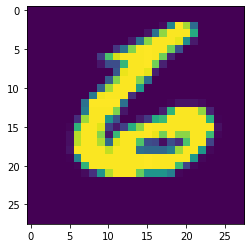

In [449]:
plt.imshow(xs[15][0])
print(ys[15])